In [1]:
#load requirements for working with PCs
from vedo import *
from ipyvtklink.viewer import ViewInteractiveWidget
import numpy as np
import tensorflow as tf

#limit GPU memory ------------------------------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    memlim = 16*1024 #22*1024
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memlim)])
  except RuntimeError as e:
    print(e)
#-----------------------------------------------------------------

import time
import cv2
import sys
import os
current = os.getcwd()
parent_directory = os.path.dirname(current)
sys.path.append(parent_directory)
sys.path.append(parent_directory+"/point_cloud_rectification")
from ICET_spherical import ICET
from linear_corrector import LC

from utils import R_tf
from metpy.calc import lat_lon_grid_deltas
from scipy.spatial.transform import Rotation as R
from matplotlib import pyplot as plt
import copy
import trimesh

from pillow_heif import register_heif_opener
from matplotlib import pyplot as p
from colmapParsingUtils import *
from scipy.spatial.transform import Rotation as R
import cv2
from lidar_nerf_utils import *

from tqdm import tqdm_notebook as tqdm
from PIL import Image

%load_ext autoreload
%autoreload 2
%autosave 180
# %matplotlib notebook

2025-01-26 12:31:47.659065: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-26 12:31:48.360234: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-26 12:31:49.645720: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/local/lib:
2025-01-26 12:31:49.645884: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7:

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2025-01-26 12:31:52.944570: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-26 12:31:52.946521: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-01-26 12:31:52.946899: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-01-26 12:31:52.947181: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Autosaving every 180 seconds


# Manually Load and Crop Image data

In [2]:
# from remove_motion_basic import linear_correction_old as lc

dir_name = "/media/derm/06EF-127D4/Newer College Dataset/"
experiment_name = "01_short_experiment-20230331T172433Z-009/01_short_experiment/"
fn_gt = dir_name + experiment_name + "ground_truth/registered_poses.csv"
#sec,nsec,x,y,z,qx,qy,qz,qw
gt = np.loadtxt(fn_gt, delimiter=',',skiprows = 1)
seconds = gt[:, 0]
nano_seconds = gt[:, 1]
xyz = gt[:, 2:5]
qxyzw = gt[:, 5:]
num_poses = qxyzw.shape[0]
sensor_poses = np.eye(4, dtype=np.float64).reshape(1, 4, 4).repeat(num_poses, axis=0)
sensor_poses[:, :3, :3] = R.from_quat(qxyzw).as_matrix()
sensor_poses[:, :3, 3] = xyz
T_CL = np.eye(4, dtype=np.float32)
T_CL[:3, :3] = R.from_quat([0.0, 0.0, 0.924, 0.383]).as_matrix() #was this --1134.97 deg
T_CL[:3, 3] = np.array([-0.084, -0.025, 0.050], dtype=np.float32) #was this
sensor_poses = np.einsum("nij,jk->nik", sensor_poses, T_CL)
initial_pose = np.linalg.inv(sensor_poses[0]) 
poses_timestamps = seconds * 10e9 + nano_seconds
sensor_poses = np.einsum("ij,njk->nik", np.linalg.inv(sensor_poses[0]), sensor_poses) #TRY COMMENTING OUT...

#get body frame vel to remove motion disortion from training data
vel_world_frame = np.diff(sensor_poses[:,:3,-1], axis = 0)
vel_body_frame = np.linalg.pinv(sensor_poses[1:,:3,:3]) @ vel_world_frame[:,:,None]
vel_body_frame = vel_body_frame[:,:,0]
#smooth out velocity estimates
def moving_average(a, n=10):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
window=50
MAx = moving_average(vel_body_frame[:,0], n = window)
MAy = moving_average(vel_body_frame[:,1], n = window)
MAz = moving_average(vel_body_frame[:,2], n = window)
vel_body_frame = np.array([MAx, MAy, MAz]).T

rot_vel_euls = np.diff(R.from_matrix(sensor_poses[:,:3,:3]).as_euler('xyz'), axis = 0)
idx = np.argwhere(rot_vel_euls > (np.pi))
rot_vel_euls[idx] = 0
idx = np.argwhere(rot_vel_euls < (-np.pi))
rot_vel_euls[idx] = 0

#courtyard
pl = '/media/derm/06EF-127D4/Newer College Dataset/new-college-29-01-2020-1cm-resolution-1stSection - mesh.ply'
HD_map = trimesh.load(pl).vertices
# #forest
# pl1 = '/media/derm/06EF-127D4/Newer College Dataset/new-college-29-01-2020-1cm-resolution-4thSection.ply'
# HD_map1 = trimesh.load(pl1).vertices
# pl2 = '/media/derm/06EF-127D4/Newer College Dataset/new-college-29-01-2020-1cm-resolution-5thSection.ply'
# HD_map2 = trimesh.load(pl2).vertices
# HD_map = np.append(HD_map1, HD_map2, axis=0)

show_nth = 10 #5
submap = HD_map[::show_nth]

In [3]:
#debug-- look at map
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]          
disp.append(Points(submap, c = 'grey', r = 3, alpha = 0.1))
plt.show(disp, "debugging rays_o and rays_d")
ViewInteractiveWidget(plt.window)  

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

In [6]:
#DEBUG -- try ICET on forest map ------------------------
idx = 12000
submap_in_pc1_frame = (np.linalg.pinv(sensor_poses[idx]) @ initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T #test
print(np.shape(submap_in_pc1_frame))
submap_in_pc1_frame = submap_in_pc1_frame[:,:3]
print(np.shape(submap_in_pc1_frame))

#remove too close 
d = np.sqrt(np.sum(submap_in_pc1_frame**2, axis = 1))
print(np.shape(d))
good  = np.argwhere(d > 2.)[:,0]
print(len(good))
submap_in_pc1_frame = submap_in_pc1_frame[good]
#and too far??
d = np.sqrt(np.sum(submap_in_pc1_frame**2, axis = 1))
good  = np.argwhere(d < 50.)[:,0]
submap_in_pc1_frame = submap_in_pc1_frame[good]

initial_guess = tf.constant([0.,0.,0.,0.,0.,0.])
it = ICET(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 50, niter = 8, 
draw = False, group = 2, RM = False, DNN_filter = False, x0 = initial_guess)

pc1_in_map_frame = (initial_pose @ sensor_poses[idx] @ np.append(pc1, np.ones([len(pc1),1]), axis =1).T).T #test
pc1_in_map_frame = pc1_in_map_frame[:,:3]

pc1_corrected_in_map_frame = (initial_pose @ sensor_poses[idx] @ np.append(it.cloud2_tensor.numpy(), np.ones([len(it.cloud2_tensor.numpy()),1]), axis =1).T).T #test
pc1_corrected_in_map_frame = pc1_corrected_in_map_frame[:,:3]    

#draw red scan corrected by output of ICET
redFix = np.eye(4)
redFix[:3,-1] = it.X[:3]
redFix[:3,:3] = redFix[:3,:3] @ R.from_euler('xyz', [it.X[3], it.X[4], it.X[5]]).as_matrix()
redfix_hist[i] = redFix

redScanFixed = (redFix @ np.append(pc1, np.ones([len(pc1),1]), axis =1).T).T
redScanFixed = (sensor_poses[idx] @ np.append(redScanFixed[:,:3], np.ones([len(redScanFixed),1]), axis =1).T).T
#----------------------------------------------------------------------------------------------------------------

(402473, 4)
(402473, 3)
(402473,)
402287


NameError: name 'pc1' is not defined

In [4]:
def add_patch(rays_o, rays_d, image):    
    """given rays_o and rays_d, and a training image, 
        display the corresponding point cloud in the world frame"""
    
    #flatten first
    rays_d_flat = np.reshape(rays_d, [-1,3])
    
    #convert to spherical
    rays_d_spherical = cartesian_to_spherical(rays_d_flat).numpy()

    #reshape rays_d to same size as image
    rays_d_spherical = np.reshape(rays_d_spherical, [np.shape(rays_d)[0], np.shape(rays_d)[1], 3])
    rays_d_spherical[:,:,0] *= image
    rays_d_spherical = np.reshape(rays_d_spherical, [-1,3])
    xyz = spherical_to_cartesian(rays_d_spherical)
    
    xyz += np.reshape(rays_o, [-1,3])
    
    return xyz
        

/home/derm/ASAR/v3/nerf/lidar_nerf_utils.py:766: RuntimeWarning: divide by zero encountered in double_scalars
  period_base = (2*np.pi)/m_hat[-1]


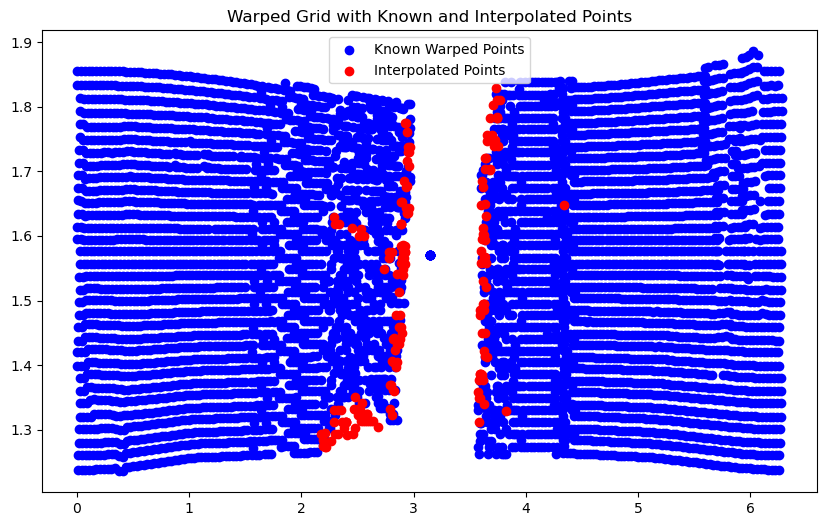

[[nan nan]
 [nan nan]
 [nan nan]
 ...
 [nan nan]
 [nan nan]
 [nan nan]]


In [5]:
def interpolate_missing_angles(pc1):
    """pc1 = cartesian coordinates of point cloud AFTER distortion correction has been applied"""

    pc1_spherical = cartesian_to_spherical(pc1).numpy()
    #test moving wrap around to center -- reduce NaNs??
    pc1_spherical[:,1] += np.pi
    pc1_spherical = tf.cast(pc1_spherical, tf.float32)
    
    ray_drops = tf.where(pc1_spherical[:,0]<0.001)
    non_ray_drops = tf.where(pc1_spherical[:,0]>0.001)

    # Generate a regular 2D grid (source grid)
    source_grid_x, source_grid_y = np.meshgrid(np.linspace(0, 63, 64), np.linspace(0, 1023, 1024))
    source_points = np.column_stack((source_grid_x.flatten(), source_grid_y.flatten()))
    warped_points = pc1_spherical[:,1:].numpy()
#     print("warped_points", np.shape(warped_points))

    # Select known warped points (subset for interpolation)
    known_indices = non_ray_drops[:,0]
    known_source_points = source_points[known_indices]
    known_warped_points = warped_points[known_indices]

    # Interpolate missing points on the warped grid
    missing_indices = np.setdiff1d(np.arange(len(source_points)), known_indices)  # Remaining points
    missing_source_points = source_points[missing_indices]

    # Use griddata to estimate locations of missing points on the warped grid
    interpolated_points = griddata(known_source_points, known_warped_points, missing_source_points, method='cubic')
#     interpolated_points = np.nan_to_num(interpolated_points, 0)
#     print("\n interpolated_points", np.shape(interpolated_points), interpolated_points)

    #fill interpolated points back in to missing locations
    full_points_spherical = tf.zeros_like(pc1_spherical).numpy()[:,:2]
    #combine via mask old and new interpolated points
    full_points_spherical[non_ray_drops[:,0]] = known_warped_points
    full_points_spherical[ray_drops[:,0]] = interpolated_points

    full_points_spherical = np.append(np.ones([len(full_points_spherical), 1]), full_points_spherical, axis = 1)
    full_points = spherical_to_cartesian(full_points_spherical)
#     print("\n full_points_spherical", np.shape(full_points_spherical), tf.math.reduce_sum(full_points_spherical))

    p.figure(figsize=(10, 6))
    p.scatter(*zip(*known_warped_points[::10]), color='blue', label='Known Warped Points')
    p.scatter(*zip(*interpolated_points[::10]), color='red', label='Interpolated Points')
    p.legend()
    p.title("Warped Grid with Known and Interpolated Points")
    p.show()

    print(interpolated_points)

    return full_points

idx = 8200
fn1 = "/media/derm/06EF-127D4/Newer College Dataset/01_Short_Experiment/point_clouds/frame_" + str(idx) + ".npy"
pc1 = np.load(fn1)
m_hat = np.array([1.,0,0,0,0,0.])
pc1 = apply_motion_profile(pc1, m_hat, period_lidar=1.)
full_points = interpolate_missing_angles(pc1)

# plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
# disp=[]          
# disp.append(Points(full_points, c = 'grey', r = 3, alpha = 0.5))
# plt.show(disp, "debugging rays_o and rays_d")
# ViewInteractiveWidget(plt.window)  

In [6]:
#generate training data...
n_images = 10 #1200 #240 #220 #1000 #50 
n_rots = 128 #128    #number of horizontal patches in 360 degrees
n_vert_patches = 1 #1 #number of vertical patches between phimin and phimaxs
useICET = True #True #need to turn off when working with the foliage dataset???
image_width = 1024//n_rots
image_height = 64//n_vert_patches
shrink_factor = 0.005 #courtyard
# shrink_factor = 0.005 #forest

# n_cols_to_skip = 0 #comment out for debug
n_cols_to_skip = n_rots // 8 #remove this much from the beginning and end of each scan
                             #   (need to remove parts of frame containing researcher carrying LIDAR)
#Ouster OS1-64
phimin = np.deg2rad(-15.594) #took forever to figure this out...
phimax = np.deg2rad(17.743)
vert_fov = np.rad2deg(phimax-phimin)

poses = np.zeros([n_images*n_rots*n_vert_patches,4,4])
images = np.ones([n_images*n_rots*n_vert_patches, 64//n_vert_patches, 1024//n_rots, 2]) #depth and raydrop channels
# [n total "patches", patch height, patch width, xyz]
rays_o_all = np.zeros([n_images*n_rots*n_vert_patches, 64//n_vert_patches, 1024//n_rots, 3]) 
rays_d_all = np.zeros([n_images*n_rots*n_vert_patches, 64//n_vert_patches, 1024//n_rots, 3]) 

H, W = images.shape[1:3]
redfix_hist = np.zeros([n_images,4,4]) #holds on to the corrective transforms we get from ICET 

for i in range(n_images):
    print(i) 
    #full loop first courtyard
    idx = i*50 + 7650 
#     idx = i + 7650
#     idx = i*40 + 10600 #forest
#     idx = i*5 + 10600 #forest
    fn1 = "/media/derm/06EF-127D4/Newer College Dataset/01_Short_Experiment/point_clouds/frame_" + str(idx) + ".npy"
    pc1 = np.load(fn1)

#     # distortion correction ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    m_hat = np.array([-vel_body_frame[idx,0],
                      -vel_body_frame[idx,1],
                      -vel_body_frame[idx,2],
#                       -rot_vel_euls[idx,0], 
#                       -rot_vel_euls[idx,1],
#                       -rot_vel_euls[idx,2]
                      0.,0.,0.
                     ])   
#     m_hat = np.array([0.,0.,0.,0.,0.,0.])
    pc1 = apply_motion_profile(pc1, m_hat, period_lidar=1.)
#     #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    pc1 = np.flip(pc1, axis = 0)# uncomment to flip and maintain CCW convention used in VICET

    if useICET:
        #Register undistorted PC against HD Map using ICET to correct issues in ground truth------------------------
        submap_in_pc1_frame = (np.linalg.pinv(sensor_poses[idx]) @ initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T #test
        submap_in_pc1_frame = submap_in_pc1_frame[:,:3]
        
        #remove too close 
        d = np.sqrt(np.sum(submap_in_pc1_frame**2, axis = 1))
        good  = np.argwhere(d > 2.)[:,0]
        submap_in_pc1_frame = submap_in_pc1_frame[good]
        #and too far??
        d = np.sqrt(np.sum(submap_in_pc1_frame**2, axis = 1))
        good  = np.argwhere(d < 50.)[:,0]
        submap_in_pc1_frame = submap_in_pc1_frame[good]

        initial_guess = tf.constant([0.,0.,0.,0.,0.,0.])
        it = ICET(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 50, niter = 8, 
           draw = False, group = 2, RM = False, DNN_filter = False, x0 = initial_guess)

        pc1_in_map_frame = (initial_pose @ sensor_poses[idx] @ np.append(pc1, np.ones([len(pc1),1]), axis =1).T).T #test
        pc1_in_map_frame = pc1_in_map_frame[:,:3]

        pc1_corrected_in_map_frame = (initial_pose @ sensor_poses[idx] @ np.append(it.cloud2_tensor.numpy(), np.ones([len(it.cloud2_tensor.numpy()),1]), axis =1).T).T #test
        pc1_corrected_in_map_frame = pc1_corrected_in_map_frame[:,:3]    

        #draw red scan corrected by output of ICET
        redFix = np.eye(4)
        redFix[:3,-1] = it.X[:3]
        redFix[:3,:3] = redFix[:3,:3] @ R.from_euler('xyz', [it.X[3], it.X[4], it.X[5]]).as_matrix()
        redfix_hist[i] = redFix

        redScanFixed = (redFix @ np.append(pc1, np.ones([len(pc1),1]), axis =1).T).T
        redScanFixed = (sensor_poses[idx] @ np.append(redScanFixed[:,:3], np.ones([len(redScanFixed),1]), axis =1).T).T
        #----------------------------------------------------------------------------------------------------------------
    else:
        redFix = np.eye(4)
        redfix_hist[i] = redFix
        redScanFixed = (redFix @ np.append(pc1, np.ones([len(pc1),1]), axis =1).T).T
        redScanFixed = (sensor_poses[idx] @ np.append(redScanFixed[:,:3], np.ones([len(redScanFixed),1]), axis =1).T).T

    #convert to depth image
    pc1_spherical = cartesian_to_spherical(pc1).numpy() #[r, theta, phi]
    pcs = np.reshape(pc1_spherical, [-1,64,3])
    pcs = np.flip(pcs, axis = 1)
    raw_data = pcs[:,:,:]
    raw_data = np.transpose(pcs, [1,0,2])

    #destagger depth images (OS1 unit has delay in sensor return bus)
    data = np.zeros([64, 1024])
    for k in range(np.shape(data)[0]//4):
#         #         #shift left (nope)
#         data[4*k,:-18] = raw_data[4*k,18:,0]
#         data[4*k+1,:-12] = raw_data[4*k+1,12:,0]
#         data[4*k+2,:-6] = raw_data[4*k+2,6:,0]
#         data[4*k+3,:] = raw_data[4*k+3,:,0]
# # #         #shift right -- https://ouster.com/insights/blog/firmware-2-4-industry-standard-protocols-and-improved-alerts
#         data[4*k,:] = raw_data[4*k,:,0]
#         data[4*k+1,6:] = raw_data[4*k+1,:-6,0]
#         data[4*k+2,12:] = raw_data[4*k+2,:-12,0]
#         data[4*k+3,18:] = raw_data[4*k+3,:-18,0]
        #keep centered
        data[4*k,1:-8] = raw_data[4*k,9:,0]
        data[4*k+1,1:-2] = raw_data[4*k+1,3:,0]
        data[4*k+2,4:] = raw_data[4*k+2,:-4,0]
        data[4*k+3,10:] = raw_data[4*k+3,:-10,0]
    data = np.flip(data, axis =1) #do not comment out

# #     #test not correcting bus-delay induced skew in raw data
#     data = np.flip(raw_data, axis =1)[:,:,0] #do not comment out

    #NEW--- get rays_o and rays_d directly inside data generation loop ~~~~~~~~~~~~~~~~~~~~~~~

    rotm = sensor_poses[idx] @ redfix_hist[i]
#     rotm = np.linalg.pinv(initial_pose) @ rotm #had this (TODO: try commenting out...)

#     courtyard1
    rotm[0,-1] += 30
    rotm[1,-1] += 30
    rotm[2,-1] += 15 
    rotm[:3,-1] *= shrink_factor #0.02 #0.005 #COURTYARD
    #courtyard
    rotm[0,-1] += 0.01 
    rotm[1,-1] += 0.25 
    rotm[2,-1] += 0.25 #translate above xy plane
#     #forest
#     rotm[0,-1] += 1.2 
#     rotm[1,-1] += 1.25 
#     rotm[2,-1] += 0.25 #translate above xy plane

    ro, rd = get_rays_from_point_cloud(pc1, m_hat, rotm)
#     print("rd", rd)

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    for j in range(n_rots):
        for k in range(n_vert_patches):

#             print("k*image_height:(k+1)*image_height", k*image_height,":",(k+1)*image_height )
#             print("j*image_width:(j+1)*image_width", j*image_width, ":",(j+1)*image_width)
    
            #store rays_o and rays_d info
            rd_in_patch = rd[k*image_height:(k+1)*image_height,j*image_width:(j+1)*image_width, :]
            rays_d_all[k+(j+(i*n_rots))*n_vert_patches,:,:,:] = rd_in_patch
            ro_in_patch = ro[k*image_height:(k+1)*image_height,j*image_width:(j+1)*image_width, :]
            rays_o_all[k+(j+(i*n_rots))*n_vert_patches,:,:,:] = ro_in_patch            

            #get cropped depth image ~~~~~~~~~~~~~~~~~~~~    
            #crop vertically and horizontally
            pcs = data[k*image_height:(k+1)*image_height,j*image_width:(j+1)*image_width] 

            #save depth information to first channel
            images[k+(j+(i*n_rots))*n_vert_patches,:,:,0] = pcs
            #save raydrop mask to 2nd channel
            a = np.argwhere(abs(pcs) < 1)
            images[k+(j+(i*n_rots))*n_vert_patches, a[:,0],a[:,1],1] = 0

            #get transformation matrix ~~~~~~~~~~~~~~~~~~
            #centers origin at actual origin of HD map 
            rotm = sensor_poses[idx] @ redfix_hist[i]
#             rotm = np.linalg.pinv(initial_pose) @ rotm #COMMENT THIS OUT!!!!

            #center camera horizontally in each patch
#             crop_angle = j*(2*np.pi/n_rots) + (np.pi/n_rots)
#             rotm_crop = R.from_euler('xyz', [0,-crop_angle,0]).as_matrix() #old-- why is this about y???
#             rotm[:3,:3] = rotm[:3,:3] @ rotm_crop

            #test 9/7 ~~~~~~~~~~~~~~~
            crop_angle = j*(2*np.pi/n_rots) - np.pi/2 + (np.pi/n_rots)
            #account for the fact that sensor points back and to the left
            #used this rotation value on the VICET paper-- (I don't think their setup was a perfect 45deg as specified in their paper)
#             crop_angle -= np.deg2rad(44.97)
            rotm_crop = R.from_euler('xyz', [0,0,-crop_angle]).as_matrix() #test
            rotm[:3,:3] = rotm[:3,:3] @ rotm_crop
            #~~~~~~~~~~~~~~~~~~~~~~~~

            #courtyard1
            rotm[0,-1] += 30
            rotm[1,-1] += 30
            rotm[2,-1] += 15 
            rotm[:3,-1] *= shrink_factor #0.02 #0.005 #COURTYARD
            images[k+(j+(i*n_rots))*n_vert_patches,:,:,0] *= shrink_factor #0.02 #0.005
            #courtyard
            rotm[0,-1] += 0.01 #TEST -- shift up just a little
            rotm[1,-1] += 0.25 #shift towards positive x
            rotm[2,-1] += 0.25 #translate above xy plane
#             #forest
#             rotm[0,-1] += 1.2 
#             rotm[1,-1] += 1.25 
#             rotm[2,-1] += 0.25 #translate above xy plane

            poses[k+(j+(i*n_rots))*n_vert_patches] = rotm 

# # Remove patches where sensor is occluded by person holding lidar ~~~~~~~~~~
#calculate how many columns of patches we need to skip at the beginning and end of each scan to avoid
bad_idx = np.zeros([0,n_rots - 2*n_cols_to_skip])
a = np.linspace(0,n_rots*n_images*n_vert_patches-1,n_rots*n_images*n_vert_patches)
# print(np.shape(a))
for i in range(n_vert_patches*n_cols_to_skip):
    bad_i_left = a[i::n_rots*n_vert_patches]
    bad_idx = np.append(bad_idx, bad_i_left)
#     print("\n bad_idx_left:", bad_i_left)

    bad_i_right = a[(i+n_vert_patches*(n_rots-n_cols_to_skip))::n_rots*n_vert_patches]
    bad_idx = np.append(bad_idx, bad_i_right)
#     print("\n bad_idx_right:", bad_i_right)

bad_idx = np.sort(bad_idx)
all_idx = np.linspace(0,n_rots*n_images*n_vert_patches-1,n_rots*n_images*n_vert_patches)
good_idx = np.setdiff1d(all_idx, bad_idx).astype(int)

# print(good_idx)

images = images[good_idx,:,:,:]
poses = poses[good_idx,:,:]
rays_d_all = rays_d_all[good_idx,:,:,:]
rays_o_all = rays_o_all[good_idx,:,:,:]
# #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

images = images.astype(np.float32)
poses = poses.astype(np.float32)

#     return(images, poses, rays_d_all, rays_o_all)
# images, poses, rays_d_all, rays_o_all = gen_training_data()

0


2025-01-26 12:32:08.102605: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2025-01-26 12:32:08.104620: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2025-01-26 12:32:08.104638: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2025-01-26 12:32:08.104716: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:189] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.


iter 0


2025-01-26 12:32:09.812608: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-01-26 12:32:09.900319: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x55af8ac4c710


iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7

 estimated solution vector X: 
 tf.Tensor([-0.04392772 -0.06846206  0.03775662 -0.01114418  0.01241772  0.00970468], shape=(6,), dtype=float32)
dirs_undistorted (65536, 3)
rays_o (64, 1024, 3)
rays_d (64, 1024, 3)
1
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7

 estimated solution vector X: 
 tf.Tensor([ 0.08882682  0.04330798 -0.01222502  0.00001761 -0.00049599  0.02871695], shape=(6,), dtype=float32)
dirs_undistorted (65536, 3)
rays_o (64, 1024, 3)
rays_d (64, 1024, 3)
2
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7

 estimated solution vector X: 
 tf.Tensor([ 0.12871316  0.07277265 -0.00827222  0.00858051  0.01380562 -0.02309906], shape=(6,), dtype=float32)
dirs_undistorted (65536, 3)
rays_o (64, 1024, 3)
rays_d (64, 1024, 3)
3
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7

 estimated solution vector X: 
 tf.Tensor([ 0.25278705  0.06250642 -0.0264751   0.00428363  0.01124833 -0.0281271 ], shape=(6,), dt

In [94]:
def draw_frame_from_rays(disp, n_rots=128, n_vert_patches=1, frameIdx=0, 
                         color = 'red', stitched_map = np.zeros([0,3]) ):

    phimin = np.deg2rad(-15.594) #took forever to figure this out...
    phimax = np.deg2rad(17.743)
    H = 64 // n_vert_patches
    W = 1024 // n_rots
    vertical_bins = np.linspace(phimin, phimax, n_vert_patches+1)  
    phivals = np.linspace(phimin, phimax, 64)#new (correct) way to bin elevation angles
    n_cols_to_skip = n_rots // 8
    
    #old way (directly using rays_o and rays_d) ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#     print("\n old method:", rays_o_all[frameIdx*(n_rots - 2*n_cols_to_skip),0,0])

    pts1 = np.zeros([1,3])
    for p in range(frameIdx*(n_rots - 2*n_cols_to_skip), (frameIdx + 1 )*(n_rots - 2*n_cols_to_skip)):
        for i in range(n_vert_patches):
            img_i = i
            idx_first=len(phivals) - (img_i%(n_vert_patches))*(64//n_vert_patches)-1
            idx_second= (len(phivals)- ((img_i+1)%(n_vert_patches))*(64//n_vert_patches))%len(phivals)
            phimin_patch = phivals[idx_first]
            phimax_patch = phivals[idx_second]

            pose = poses[i + p*n_vert_patches]
            rays_o = rays_o_all[i + p*n_vert_patches]
            rays_d = rays_d_all[i + p*n_vert_patches]
            
            inMap1 = add_patch(rays_o, rays_d, images[i+p*n_vert_patches,:,:,0])

            pts1 = np.append(pts1, inMap1, axis = 0)
        disp.append(Points(rays_o[0,:1,:], r = 15, c = 'purple')) #DEBUG 

    color = 'red'#for debug
    vizPts1 = Points(pts1, c = color, r = 3., alpha = 0.125)
    disp.append(vizPts1)
    
    stitched_map = np.append(stitched_map, pts1, axis = 0)
    return stitched_map

#     #new-- try to get rays_o and rays_d indirectly via poses ~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#     pts2 = np.zeros([1,3])
#     for p in range(frameIdx*(n_rots - 2*n_cols_to_skip), (frameIdx + 1 )*(n_rots - 2*n_cols_to_skip)):
# #         print("alt strategy starting pose idx:", frameIdx*(n_rots - 2*n_cols_to_skip))
        
#         rotm = poses[frameIdx*(n_rots - 2*n_cols_to_skip)].copy()
#         # account for image crop in rotation
#         crop_angle =  p*(2*np.pi/n_rots) - np.pi/2 + (np.pi/n_rots)
#         rotm_crop = R.from_euler('xyz', [0,0,-crop_angle]).as_matrix() #actually need to rot about z
#         rotm[:3,:3] = rotm[:3,:3] @ rotm_crop
#         rotm = rotm.astype(np.float32)

#         rays_o, rays_d = get_rays(H, W, rotm, phimin_patch, phimax_patch)
#         inMap2 = add_patch(rays_o, rays_d, images[p,:,:,0])

#         pts2 = np.append(pts2, inMap2, axis = 0)
#         disp.append(Points(rays_o[0,:1,:], r = 15, c = 'purple')) #DEBUG 

#     print("new method:", rays_o[0,0])
    
#     color = 'blue'#for debug
#     vizPts1 = Points(pts2, c = color, r = 3., alpha = 0.125)
#     disp.append(vizPts1)
#     #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]          

n_images = 1200
stitched_map = np.zeros([0,3])
# colors = ['red', 'orange', 'yellow', 'green', 'blue', 'indigo', 'violet', 'red']
colors = np.linspace(0.1,0.3,n_images)[:,None] * np.array([[1,1,1]])
# for i in range(len(colors)):
for i in range(0,1200,100):
    print(i)
    stitched_map = draw_frame_from_rays(disp, n_rots = 128, n_vert_patches=1, 
                                        frameIdx = i, color=colors[i], stitched_map=stitched_map)
    
plt.show(disp, "Drawing training data from depth images, rays_o, and rays_d")
ViewInteractiveWidget(plt.window)  

0
100
200
300
400
500
600
700
800
900
1000
1100


ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

# debug draw frames

In [ ]:
#Raw frames, in Newer College RHCS convention
phimin = np.deg2rad(-16) 
phimax = np.deg2rad(17.75)

plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

# new_point_cloud_spherical = np.zeros([np.shape(images)[1]*np.shape(images)[2],3])

for i in range(3):
#     #from gt output by dataset (old)
#     idx = i*20 + 600    
#     rotm = np.eye(4)
#     rotm[0,3] = gt[idx,2] #x
#     rotm[1,3] = gt[idx,3] #y
#     rotm[2,3] = gt[idx,4] #z
#     rotm[:3,:3] = R.from_quat(gt[idx,5:]).as_matrix() 

    #looking directly at "poses" used to train network
    n_rots = 128
    n_cols_to_skip = n_rots // 8
    idx = i*(n_rots - 2*n_cols_to_skip)
    rotm = poses[idx].copy()

#     #debug-- try temp rotating about green axis (red goes down)
#     red_go_down = R.from_euler('xyz', [0.,np.deg2rad(45),0.]).as_matrix()
#     rotm[:3,:3] = rotm[:3,:3] @ red_go_down 
# #     rotm[:3,:3] = red_go_down @ rotm[:3,:3] 

    #draw frames for each sub-scan 
    alph = 1-(i/200)
    scale = 1/100
    #forward view direction (-z in NeRF c2w convention)
    headings = rotm[:3,:3] @ np.array([0,0,-scale])
    disp.append(Arrows(rotm[:3,-1][None,:], (rotm[:3,-1] + headings)[None,:], c = "yellow", alpha = alph))
    # x
    headings = rotm[:3,:3] @ np.array([scale,0,0])
    disp.append(Arrows(rotm[:3,-1][None,:], (rotm[:3,-1] + headings)[None,:], c = "red", alpha = alph))
    #y
    headings = rotm[:3,:3] @ np.array([0,scale,0])
    disp.append(Arrows(rotm[:3,-1][None,:], (rotm[:3,-1] + headings)[None,:], c = "green", alpha = alph))
    #z
    headings = rotm[:3,:3] @ np.array([0,0,scale])
    disp.append(Arrows(rotm[:3,-1][None,:], (rotm[:3,-1] + headings)[None,:], c = "blue", alpha = alph))

disp.append(Points(np.array([[0,0,0]]), r = 10, c = 'black'))
plt.show(disp, "Ground Truth Path (v6) looks like actual data now?")
ViewInteractiveWidget(plt.window)

# debug get_rays projection

In [ ]:
plt = Plotter(N = 1, axes = 12, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[] 
num_cols_to_draw = 80

# phimin = np.deg2rad(-15.594) #observed in raw data 
# phimax = np.deg2rad(17.743) #observed in raw data
phimax = np.deg2rad(15.594) #debug 
phimin = np.deg2rad(-17.743) #debug
vertical_bins = np.linspace(phimin, phimax, n_vert_patches+1)
phimin_patch = vertical_bins[img_i%n_vert_patches] 
phimax_patch = vertical_bins[img_i%n_vert_patches + 1]

start_idx = 5*(n_rots - 2*n_cols_to_skip)

# #project rays_o and rays_d according to first p poses
# for p in range(num_cols_to_draw):    
#     rotm = poses[start_idx + p].copy()
#     rotm = rotm.astype(np.float32)
#     rays_o, rays_d = get_rays(H, W, rotm, phimin_patch, phimax_patch)
#     disp.append(Points(tf.reshape(rays_d.numpy(), [-1,3]), c = 'green', alpha = (p+1)/num_cols_to_draw, r = 3.5))
#     disp.append(Points(tf.reshape(rays_d.numpy(), [-1,3])[:10,:], c = 'red', r = 3.5, alpha =  0.6))


#start with pose[0] and draw rays_o, rays_d. Rotate sensor about z axis, re-calculate and redraw
for p in range(num_cols_to_draw):
        
    rotm = poses[start_idx].copy()
    # account for image crop in rotation
    crop_angle =  p*(2*np.pi/n_rots) - np.pi/2 #+ (np.pi/n_rots)
    rotm_crop = R.from_euler('xyz', [0,0,-crop_angle]).as_matrix() #actually need to rot about z
    
    rotm[:3,:3] = rotm[:3,:3] @ rotm_crop
    rotm = rotm.astype(np.float32)
    
    vertical_bins = np.linspace(phimin, phimax, n_vert_patches+1)
    phimin_patch = vertical_bins[img_i%n_vert_patches] 
    phimax_patch = vertical_bins[img_i%n_vert_patches + 1]

    #call NeRF using specified novel rotm
    rays_o, rays_d = get_rays(H, W, rotm, phimin_patch, phimax_patch)
    disp.append(Points(tf.reshape(rays_d.numpy(), [-1,3]), c = 'purple', alpha = (p+1)/num_cols_to_draw, r = 3.5))
    disp.append(Points(tf.reshape(rays_d.numpy(), [-1,3])[:10,:], c = 'red', r = 3.5, alpha =  0.6))
    
#draw what the corresponding rays_o and rays_d actually look like at that same sensor pose
#  (it was actually part of the training data)
for i in range(num_cols_to_draw*n_vert_patches):
    
    rays_o_i = rays_o_all[i + start_idx]
    rays_d_i = rays_d_all[i + start_idx]    

#     patch_for_i = tf.reshape(rays_d_i, [-1,3]) + tf.reshape(rays_o_i, [-1,3])
    patch_for_i = tf.reshape(rays_d_i, [-1,3])
#     patch_for_i = tf.reshape(rays_d_i, [-1,3]) @ tf.cast(tf.linalg.pinv(poses[i,:3,:3]), tf.double)
#     patch_for_i = tf.reshape(rays_d_i, [-1,3]) @ rot_corr.T
    disp.append(Points(patch_for_i, c = 'blue', r = 3.5, alpha = (i+2)/(2*n_vert_patches*num_cols_to_draw+1)))
    disp.append(Points(patch_for_i[:10], c = 'r', r = 6, alpha = 0.6))

plt.show(disp, "64x8 patches")
ViewInteractiveWidget(plt.window)
# print(rays_d[:,0])

In [ ]:
# print(R.from_matrix(redfix_hist[9,:3,:3]).as_euler('xyz'))
# print(poses[0])
print(R.from_matrix(poses[50,:3,:3]).as_euler('xyz'))
print(R.from_matrix(poses[60,:3,:3]).as_euler('xyz'))

In [ ]:
# from matplotlib import pyplot as p
# fig, ax = p.subplots()
# angs = R.from_matrix(poses[:,:3,:3]).as_euler('xyz');
# ax.plot(angs[:400,:]); #rotation angles xyz
# # ax.plot(poses[:,:3,-1]); #location xyz

In [13]:
#[7700, 8700, x100] n_rots=128, n_vert_patches=1
# np.save("/home/derm/Desktop/imagesUndistorted.npy", images)
# np.save("/home/derm/Desktop/posesUndistorted.npy", poses)
# np.save("/home/derm/Desktop/rays_oUndistorted.npy", rays_o_all)
# np.save("/home/derm/Desktop/rays_dUndistorted.npy", rays_d_all)
# #[7650, 8850, x240] n_rots=128, n_vert_patches=1 --used this to train best stochastic net so far...
# np.save("/home/derm/Desktop/imagesUndistortedV2.npy", images)
# np.save("/home/derm/Desktop/posesUndistortedV2.npy", poses)
# np.save("/home/derm/Desktop/rays_oUndistortedV2.npy", rays_o_all)
# np.save("/home/derm/Desktop/rays_dUndistortedV2.npy", rays_d_all)
# #[7650, 8850, 1200] n_rots=128, n_vert_patches=1
# np.save("/home/derm/Desktop/imagesUndistortedV5.npy", images)
# np.save("/home/derm/Desktop/posesUndistortedV5.npy", poses)
# np.save("/home/derm/Desktop/rays_oUndistortedV5.npy", rays_o_all)
# np.save("/home/derm/Desktop/rays_dUndistortedV5.npy", rays_d_all)

# ## -- fixed trainging data to rotate about sensor z (instead of y)
#[7650, 8850, x240] n_rots=128, n_vert_patches=1 
# np.save("/home/derm/Desktop/imagesUndistortedV6.npy", images)
# np.save("/home/derm/Desktop/posesUndistortedV6.npy", poses)
# np.save("/home/derm/Desktop/rays_oUndistortedV6.npy", rays_o_all)
# np.save("/home/derm/Desktop/rays_dUndistortedV6.npy", rays_d_all)
#[7650, 8850, x1200] n_rots=128, n_vert_patches=1 
# np.save("/home/derm/Desktop/imagesUndistortedV7.npy", images)
# np.save("/home/derm/Desktop/posesUndistortedV7.npy", poses)
# np.save("/home/derm/Desktop/rays_oUndistortedV7.npy", rays_o_all)
# np.save("/home/derm/Desktop/rays_dUndistortedV7.npy", rays_d_all)


# ##Forest, idx = i*40 + 10600, 60 frames,  n_rots=128, n_vert_patches=1
# np.save("/home/derm/Desktop/imagesUndistortedV3.npy", images)
# np.save("/home/derm/Desktop/posesUndistortedV3.npy", poses)
# np.save("/home/derm/Desktop/rays_oUndistortedV3.npy", rays_o_all)
# np.save("/home/derm/Desktop/rays_dUndistortedV3.npy", rays_d_all)
##Forest, idx = i*10 + 10600, 240 frames,  n_rots=128, n_vert_patches=1
# np.save("/home/derm/Desktop/imagesUndistortedV4.npy", images)
# np.save("/home/derm/Desktop/posesUndistortedV4.npy", poses)
# np.save("/home/derm/Desktop/rays_oUndistortedV4.npy", rays_o_all)
# np.save("/home/derm/Desktop/rays_dUndistortedV4.npy", rays_d_all)
##Forest, idx = i*5 + 10600, 480 frames,  n_rots=128, n_vert_patches=1, correct rotate about z sensor
# np.save("/home/derm/Desktop/imagesUndistortedV8.npy", images)
# np.save("/home/derm/Desktop/posesUndistortedV8.npy", poses)
# np.save("/home/derm/Desktop/rays_oUndistortedV8.npy", rays_o_all)
# np.save("/home/derm/Desktop/rays_dUndistortedV8.npy", rays_d_all)


# ##WITH ICET CORRECTIONS TO GROUND TRUTH 
# ##Forest, idx = i*5 + 10600, 480 frames,  n_rots=128, n_vert_patches=1, correct rotate about z sensor
# np.save("/home/derm/Desktop/imagesForestFixed.npy", images)
# np.save("/home/derm/Desktop/posesForestFixed.npy", poses)
# np.save("/home/derm/Desktop/rays_oForestFixed.npy", rays_o_all)
# np.save("/home/derm/Desktop/rays_dForestFixed.npy", rays_d_all)

# #big courtyard
# images = np.load("/home/derm/Desktop/imagesUndistortedV5.npy")
# poses = np.load("/home/derm/Desktop/posesUndistortedV5.npy")
# rays_o_all = np.load("/home/derm/Desktop/rays_oUndistortedV5.npy")
# rays_d_all = np.load("/home/derm/Desktop/rays_dUndistortedV5.npy")
# # big forest
# images = np.load("/home/derm/Desktop/imagesUndistortedV4.npy")
# poses = np.load("/home/derm/Desktop/posesUndistortedV4.npy")
# rays_o_all = np.load("/home/derm/Desktop/rays_oUndistortedV4.npy")
# rays_d_all = np.load("/home/derm/Desktop/rays_dUndistortedV4.npy")

# #new courtyard
images = np.load("/home/derm/Desktop/imagesUndistortedV7.npy")
poses = np.load("/home/derm/Desktop/posesUndistortedV7.npy")
rays_o_all = np.load("/home/derm/Desktop/rays_oUndistortedV7.npy")
rays_d_all = np.load("/home/derm/Desktop/rays_dUndistortedV7.npy")
# # #new forest
# n_images = 480
# images = np.load("/home/derm/Desktop/imagesUndistortedV8.npy")
# poses = np.load("/home/derm/Desktop/posesUndistortedV8.npy")
# rays_o_all = np.load("/home/derm/Desktop/rays_oUndistortedV8.npy")
# rays_d_all = np.load("/home/derm/Desktop/rays_dUndistortedV8.npy")
# images = np.load("/home/derm/Desktop/imagesForestFixed.npy")
# poses = np.load("/home/derm/Desktop/posesForestFixed.npy")
# rays_o_all = np.load("/home/derm/Desktop/rays_oForestFixed.npy")
# rays_d_all = np.load("/home/derm/Desktop/rays_dForestFixed.npy")

In [15]:
#look at dynamic spinning point clouds:

In [ ]:
i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy')
# print(i)
test1 = (-i + ((W-1)/2))  /(W) * (2*np.pi/(1024//(W)))
print(test1[0])

test2 = (i - ((W-1)/2))  /(W) * (2*np.pi/(1024//(W))) #- np.pi
print(test2[0])

In [ ]:
num_cols_to_draw = 10
phimin = np.deg2rad(-15.594) #observed in raw data 
phimax = np.deg2rad(17.743) #observed in raw data
# phimax = np.deg2rad(15.594) #debug 
# phimin = np.deg2rad(-17.743) #debug

plt = Plotter(N = 1, axes = 12, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[] 

#get rays_o and rays_d for a "novel" sensor pose
for p in range(num_cols_to_draw):
    n_rots = 128 #128 #number of horizontal patches per 2*pi
    n_vert_patches = 1 #8 #1 #number of vertical patches between phimin and phimax
    H = 64 // n_vert_patches
    W = 1024 // n_rots
    vertical_bins = np.linspace(phimin, phimax, n_vert_patches+1)  
    phivals = np.linspace(phimin, phimax, 64)#new (correct) way to bin elevation angles
    for i in range(n_vert_patches):
        img_i = i
        #top to bottom (correct)
        idx_first=len(phivals) - (img_i%(n_vert_patches))*(64//n_vert_patches)-1
        idx_second= (len(phivals)- ((img_i+1)%(n_vert_patches))*(64//n_vert_patches))%len(phivals)
        phimin_patch = phivals[idx_first]
        phimax_patch = phivals[idx_second]

    #     pose = tf.cast(np.eye(4), tf.float32)
        pose = poses[i + p*n_vert_patches]
        rays_o, rays_d, rays_d_OG = get_rays(H, W, pose, phimin_patch, phimax_patch, debug=True)
    
        disp.append(Points(tf.reshape(rays_d.numpy(), [-1,3]), c = 'green', alpha = (p+1)/num_cols_to_draw, r = 3.5))
        disp.append(Points(tf.reshape(rays_d.numpy(), [-1,3])[:10,:], c = 'red', r = 3.5, alpha =  0.6))
        
#         disp.append(Points(tf.reshape(rays_d_OG, [-1,3]), c = 'g', r = 3.5, alpha = 0.5))

#draw what the corresponding rays_o and rays_d actually look like at that same sensor pose
#  (it was actually part of the training data)
for i in range(num_cols_to_draw*n_vert_patches):
    rays_o_i = rays_o_all[i]
    rays_d_i = rays_d_all[i]    

#     patch_for_i = tf.reshape(rays_d_i, [-1,3]) + tf.reshape(rays_o_i, [-1,3])
    patch_for_i = tf.reshape(rays_d_i, [-1,3])
#     patch_for_i = tf.reshape(rays_d_i, [-1,3]) @ tf.cast(tf.linalg.pinv(poses[i,:3,:3]), tf.double)
#     patch_for_i = tf.reshape(rays_d_i, [-1,3]) @ rot_corr.T
    disp.append(Points(patch_for_i, c = 'blue', r = 3.5, alpha = (i+2)/(2*n_vert_patches*num_cols_to_draw+1)))
    disp.append(Points(patch_for_i[:10], c = 'r', r = 6, alpha = 0.6))
    
plt.show(disp, "64x8 patches")
ViewInteractiveWidget(plt.window)
# print(rays_d[:,0])

# Debug rays_o, rays_d

### NEW-- get rays_o and rays_d directly from distortion corrected point cloud
#### old method of assuming rays based on lidar index was preventing motion distortion correction from working!!!


In [ ]:
#draw subsequent scans aligned using poses with redfix
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

for i in range(5):
    idx = 5*i + 7650
#     idx = i*10 + 10600 #forest

    fn1 = "/media/derm/06EF-127D4/Newer College Dataset/01_Short_Experiment/point_clouds/frame_" + str(idx) + ".npy"
    pc1 = np.load(fn1)
# #     # distortion correction ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#      #looks great!
#     m_hat = np.array([-vel_body_frame[idx,0],
#                       -vel_body_frame[idx,1],
#                       -vel_body_frame[idx,2],
#                       -rot_vel_euls[idx,0],
#                       -rot_vel_euls[idx,1],
#                       -rot_vel_euls[idx,2]
#                      ])   
#     pc1 = apply_motion_profile(pc1, m_hat, period_lidar=1.)
# #     #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~        

    #centers origin at actual origin of HD map 
    rotm = sensor_poses[idx] @ redfix_hist[i]
    rotm = np.linalg.pinv(initial_pose) @ rotm
    
    #rescale
    rotm[2,-1] += 15 
    rotm[1,-1] += 30
    rotm[0,-1] += 30
    rotm[:3,-1] *= 0.005 #0.005 #0.02 #0.05 #COURTYARD
    rotm[2,-1] += 0.25 #translate above xy plane
    rotm[1,-1] += 0.25 #shift towards positive x
    rotm[0,-1] += 0.01 #TEST -- shift up just a little
    pc1 *= 0.005
    
    pc1_aligned = (rotm @ np.append(pc1, np.ones([len(pc1),1]), axis =1).T).T
        
#     disp.append(Points(pc1_aligned[:,:3], c = 'r', r = 2.5, alpha = 0.125))
#     # rainbow by z height
    zheight = 100*(np.sin(0.25*pc1_aligned[:,2])+1)
    cname = np.array([1-zheight, zheight, 1.5*zheight]).T.tolist()
    disp.append(Points(pc1_aligned[:,:3], c = cname, r = 3, alpha = 0.1))

    
plt.show(disp, "Training Data with VICET correction")
ViewInteractiveWidget(plt.window)

In [ ]:
#debug applying motion profile to rays_d-- 
# need to get it to match how we are applying it to pc1
from lidar_nerf_utils import get_rays_from_point_cloud

idx = 7750
fn1 = "/media/derm/06EF-127D4/Newer College Dataset/01_Short_Experiment/point_clouds/frame_" + str(idx) + ".npy"
pc1 = np.load(fn1)

# m_hat = np.array([-vel_body_frame[idx,0],
#                   -vel_body_frame[idx,1],
#                   -vel_body_frame[idx,2],
#                   -rot_vel_euls[idx,0],
#                   -rot_vel_euls[idx,1],
#                   -rot_vel_euls[idx,2]
#                  ])   
m_hat = np.array([-1,0,0,0,0,0])
pc1 = apply_motion_profile(pc1, m_hat, period_lidar=1.)

c2w = tf.cast(np.eye(4), tf.float32) #DEBUG ONLY
ro, rd = get_rays_from_point_cloud(pc1, m_hat, c2w)

#draw
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]
# disp.append(Points(pc1[:30000], c = 'r', r = 2.5, alpha = 0.125))   
disp.append(Points(pc1, c = 'r', r = 2.5, alpha = 0.125))   
disp.append(Points(tf.reshape(rd, [-1,3]), c = 'b', r = 2.5, alpha = 0.125))   
disp.append(Points(tf.reshape(rd, [-1,3])[:200], c = 'r', r = 10, alpha = 0.125))   
plt.show(disp, "getting rays_d from raw point cloud")
ViewInteractiveWidget(plt.window)

In [ ]:
#draw subsequent scans aligned using poses without redfix
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

for i in range(10):
    idx = i*100 + 7700
#     idx = i*40 + 10600 #forest
    
    fn1 = "/media/derm/06EF-127D4/Newer College Dataset/01_Short_Experiment/point_clouds/frame_" + str(idx) + ".npy"
    pc1 = np.load(fn1)      

    #centers origin at actual origin of HD map 
    rotm = sensor_poses[idx]
    rotm = np.linalg.pinv(initial_pose) @ rotm

    pc1_aligned = (rotm @ np.append(pc1, np.ones([len(pc1),1]), axis =1).T).T
    pc1_aligned += 5
    
    disp.append(Points(pc1_aligned[:,:3], c = 'blue', r = 3., alpha = 0.05))
    
plt.show(disp, "Training Data with raw \"ground truth\" poses")
ViewInteractiveWidget(plt.window)

In [ ]:
H = 64
W = 1024
phimax_patch = np.deg2rad(-15.594) #works best flipped
phimin_patch = np.deg2rad(17.743)

i, j = tf.meshgrid(tf.range(1024, dtype=tf.float32), tf.range(64, dtype=tf.float32), indexing='xy')
test = (-(i - ((W-1)/2))  /(W) * (2*np.pi/(1024//(W))) - 2*np.pi )  % (2*np.pi) - np.pi
# test = (i - ((W-1)/2))  /(W) * (2*np.pi/(1024//(W))) - np.pi
print(test)

idx  = 7800
fn1 = "/media/derm/06EF-127D4/Newer College Dataset/01_Short_Experiment/point_clouds/frame_" + str(idx) + ".npy"
pc1 = np.load(fn1)
pc1_spherical = cartesian_to_spherical(pc1)

fig, ax = p.subplots(2,1)
ax[0].plot(test[0,:])
# ax[0].plot(np.flip(test, axis = 1)[0,:])
ax[1].plot(pc1_spherical[:,1])

In [ ]:
#LOAD [-15,17.5]x1000, @0.005
# poses = np.load("/home/derm/Desktop/poses.npy") # <--- used these for best NeRF training
# images = np.load("/home/derm/Desktop/images.npy")
# poses = np.load("/home/derm/Desktop/posesEval.npy") # <--- every 5th frame, [7700:8800] for benchmarking
# images = np.load("/home/derm/Desktop/imagesEval.npy")

# #forest sample
# poses = np.load("/home/derm/Desktop/posesForest.npy")
# images = np.load("/home/derm/Desktop/imagesForest.npy")

# # #LOAD [-15,17]x1000, 8x8 @ 0.005
# poses = np.load("/home/derm/Desktop/poses8x8.npy")
# images = np.load("/home/derm/Desktop/images8x8.npy")

# #Linearly scale down translations and ranges ~~~~~~~~~~~~~~~~~~~
# rotm[:3,-1] *= 0.002 #0.005 #0.02 #0.05
# images[k+(j+(i*n_rots))*n_vert_patches,:,:,0] *= 0.002 #0.005 #0.02 #0.005 #0.05
# #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [ ]:
#messing with replicating np.diff function in tensorflow so we can run render func in graph mode... 
print(np.shape(gtCDF))
old = np.gradient(CDF, axis = 2) + 1e-8
print(np.shape(old))

weights = (CDF[:, :, 1:] - CDF[:, :, :-1]) + 1e-8
weights = tf.concat([weights, weights[:, :, -1:]], axis=2)  # Match the shape of the original axis
print(np.shape(weights))

print(np.sum((old == weights)))
print(64*8*128)

# Train NeRF using old single-network strategy

Note: for training forest scene we need to start a 5e-5, runFine = True, N_samples>=128 

2025-01-26 12:42:16.176176: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500


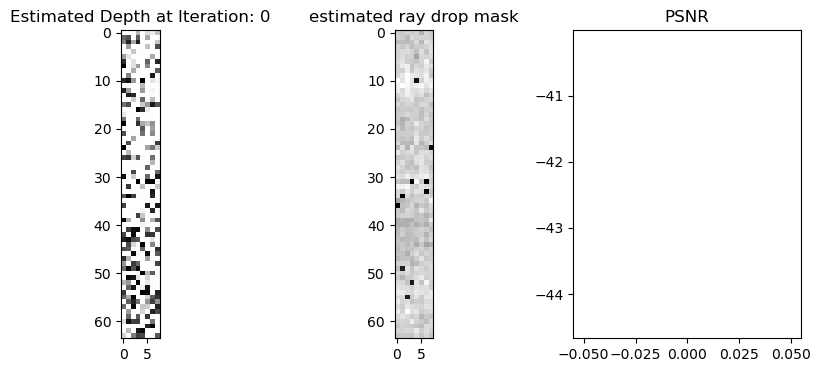


KeyboardInterrupt



In [14]:
from lidar_nerf_utils import *
from numpy.lib.stride_tricks import sliding_window_view

model = init_model()
# model = model_fine # DEBUG - use from coarse to fine 
# optimizer = tf.keras.optimizers.Adam(5e-4) #default tiny-NeRF
# optimizer = tf.keras.optimizers.Adam(1e-4)
optimizer = tf.keras.optimizers.Adam(5e-5) #anneal to this (LiDAR NeRF)
# optimizer = tf.keras.optimizers.Adam(1e-5)
# optimizer = tf.keras.optimizers.Adam(5e-6) #anneal to this (Mip-NeRF)
# optimizer = tf.keras.optimizers.Adam(1e-6) #TEST

N_samples = 128 #128 #256
near=0.
far= 1.
N_iters = 5_000_000
psnrs = []
iternums = []
i_plot = 128
accumulate_gradients_steps = 1 #32
# runfine = True
runfine = False

#IMPORTANT-- this needs to match values used when setting up training data 
n_rots = 128 #128 #number of horizontal patches per 2*pi
n_vert_patches = 1 #1 #number of vertical patches between phimin and phimax (at time of data generation)
H = 64 // n_vert_patches
W = 1024 // n_rots
testimg = images[12]
testpose = poses[12]

phimin = np.deg2rad(-15.594) #observed in raw data 
phimax = np.deg2rad(17.743) #observed in raw data

vertical_bins = np.linspace(phimin, phimax, n_vert_patches+1)  
phivals = np.linspace(phimin, phimax, 64)#new (correct) way to bin elevation angles

gradients = [tf.zeros_like(var) for var in model.trainable_variables]
accumulated_loss = 0.0

for i in range(N_iters+1):
    img_i = np.random.randint(images.shape[0])

    #use full verical patch
    target = images[img_i,:,:,:1]
    target_drop_mask = images[img_i,:,:,1:]
    pose = poses[img_i]
    rays_d = rays_d_all[img_i]
    rays_o = rays_o_all[img_i]
    
#     #break up scans vertically at train time
#     # this works but make sure to drop the LR proportionally!
#     patch_height = 16
#     vert_crop_start = np.random.randint(0,H - patch_height - 1)
#     vert_crop_end = vert_crop_start + patch_height
#     target = images[img_i,vert_crop_start:vert_crop_end,:,:1]
#     target_drop_mask = images[img_i,vert_crop_start:vert_crop_end,:,1:]
#     pose = poses[img_i]
#     rays_d = rays_d_all[img_i, vert_crop_start:vert_crop_end]
#     rays_o = rays_o_all[img_i, vert_crop_start:vert_crop_end]
    
    with tf.GradientTape() as tape:

        # run coarse network~~~~~~~~~~~~~~~~~
        z_vals = tf.linspace(near, far, N_samples)  #IMPORTANT NOTE: z_vals must be in ascending order 
        z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
#         z_vals += 0.001*tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
        z_vals = z_vals[:,:,:,None]#manually expand dimensions before passing in to coarse network (all pixels will share the same z_vals)
        depth, ray_drop, CDF, weights = render_rays(model, rays_o, rays_d,  z_vals, fine = False)
        depth = depth[:,:,None]
        ray_drop = ray_drop[:,:,None]
        gtCDF = z_vals[:,:,:,0] > target[:,:,:]
        gtCDF = tf.cast(gtCDF, tf.float32)
        #PLINK
        loss_coarse = calculate_loss(depth, ray_drop, target, target_drop_mask, CDF = CDF, gtCDF = gtCDF) #punish similar depth returns
        #benchmarking with LiDAR-NeRF
#         loss_coarse = calculate_loss_Mai_City(depth, ray_drop, target, target_drop_mask)
        
        loss = loss_coarse

        #not technically correct but helps to give a warm start
        if runfine:
            # run through a 2nd time network ~~~~~~~~~~~~~~~~~~
            #pad weights with zeros
#             fwd = np.append(np.zeros([np.shape(weights)[0], np.shape(weights)[1], 1]), weights, axis = -1)
#             rev = np.append(weights, np.zeros([np.shape(weights)[0], np.shape(weights)[1], 1]), axis = -1)
#             #use additional axis to calculate all at once
#             fwd_test = np.max(sliding_window_view(fwd, window_shape = 2, axis = 2), axis = -1)
#             rev_test = np.max(sliding_window_view(rev, window_shape = 2, axis = 2), axis = -1)
            #TEST-- slightly wider blur-pool
            fwd = np.append(np.zeros([np.shape(weights)[0], np.shape(weights)[1], 3]), weights, axis = -1)
            rev = np.append(weights, np.zeros([np.shape(weights)[0], np.shape(weights)[1], 3]), axis = -1)
            fwd_test = np.max(sliding_window_view(fwd, window_shape = 4, axis = 2), axis = -1)
            rev_test = np.max(sliding_window_view(rev, window_shape = 4, axis = 2), axis = -1)

    
            #blur-pool as vectorized operation
            test2 = (fwd_test + rev_test) /2 #blur
    #         test2 += 1/N_samples #shift up slightly
            test2 += 1/(3*N_samples) #shift up slightly
            test2 = test2 / np.sum(test2, axis = -1)[:,:,None] #renormalize
            
            cum_hist_vals = np.cumsum(test2, axis = -1)
            cum_hist_vals_flat = cum_hist_vals.flatten()
    
            #modify cum_hist_vals so it is monotonically increasing (needed for interp func to work)
            step_corr = np.linspace(0,W*H-1,W*H)
            step_corr = np.tile(step_corr,(N_samples,1)).T
            step_corr = np.reshape(step_corr, [1,-1])[0,:]
            cum_hist_vals_flat+= step_corr
    
            linear_spaced = np.linspace(near, H*W, N_samples*H*W)
#             #fix spacing-- go all the way through [min, max] on every channel???
#             linear_spaced = np.linspace(near, far, N_samples)
#             linear_spaced = np.tile(linear_spaced, (H*W))
#             linear_spaced += step_corr

            ans = np.interp(x=linear_spaced, xp=cum_hist_vals_flat, fp=linear_spaced)
            ans -= step_corr
            ans *= far #scale back to max value
#             ans = np.abs(ans) #old-- was shifted to the left
            ans = np.abs(ans) + 1/N_samples #took forever to figure this one out...
            z_vals = np.reshape(ans, [H,W,N_samples,1])
            
            gtCDF = z_vals[:,:,:,0] > target[:,:,:]
            gtCDF = tf.cast(gtCDF, tf.float32)
            
#             print(rays_o[0,0,:])
#             print(rays_d[0,0,:])
#             print(z_vals[0,0,:,0])
            rays_o  = tf.cast(rays_o, tf.float32)
            rays_d  = tf.cast(rays_d, tf.float32)
            z_vals  = tf.cast(z_vals, tf.float32)
    
            #run actual 2nd pass through same network
            depth, ray_drop, CDF, weights = render_rays(model, rays_o, rays_d,  z_vals, fine = True)
            depth = depth[:,:,None]
            depth = tf.cast(depth, tf.float32) #why do I have to cast this here???
            ray_drop = ray_drop[:,:,None]
            
            # loss_fine = calculate_loss(depth, ray_drop, target, target_drop_mask)
            loss_fine = calculate_loss(depth, ray_drop, target, target_drop_mask, CDF = CDF, gtCDF = gtCDF)
            loss = 0.1*loss_coarse + 0.9*loss_fine 
            # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~   
        
        #NEW--prevent NaN gradients from crashing training routine(?) -- needed for monotonically increasing outputs?
        current_gradients = tape.gradient(loss, model.trainable_variables)
        current_gradients = [grad if grad is not None else tf.zeros_like(var) for grad, var in zip(current_gradients, model.trainable_variables)]
        gradients = [grad_accum + current_grad for grad_accum, current_grad in zip(gradients, current_gradients)]        

#         #OLD-- not working with CDF stuff
#         current_gradients = tape.gradient(loss, model.trainable_variables)
#         gradients = [grad_accum + current_grad for grad_accum, current_grad in zip(gradients, current_gradients)]    
        
        accumulated_loss += loss
    
    if i%accumulate_gradients_steps==0:    
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        accumulated_loss = 0.0
        gradients = [tf.zeros_like(var) for var in model.trainable_variables]
        accumulated_loss = 0
    
    if i%i_plot==0:
#         rays_o, rays_d = get_rays(H, W, testpose, vertical_bins[-2], vertical_bins[-1]) #constant validation image
        z_vals = tf.linspace(near, far, N_samples) 
        z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
        z_vals = z_vals[:,:,:,None]
        depth, ray_drop, CDF, weights = render_rays(model, rays_o, rays_d,  z_vals)
        depth = depth[:,:,None]
        ray_drop = ray_drop[:,:,None]
        target = testimg[:,:,:1]
        target_drop_mask = testimg[:,:,1:]
        psnr = -10. * tf.math.log(loss) / tf.math.log(10.)
        psnrs.append(psnr.numpy())
        iternums.append(i)
        p.figure(figsize=(10,4))
        p.subplot(131)
        p.imshow(depth,cmap = "gray")#, norm='log')
        p.title(f'Estimated Depth at Iteration: {i}')
        p.subplot(133)
        p.plot(iternums, psnrs)
        p.title('PSNR')
        p.subplot(132)
        p.imshow(ray_drop, cmap="gray")#, norm = 'log')
        p.title("estimated ray drop mask")
        p.show()
print('Done')

In [ ]:
#Testing Yifan's code
# model = init_model(D=10, W=512)
optimizer = tf.keras.optimizers.Adam(5e-5) #default tiny-NeRF

N_samples =128  #128 #256
near=0.
far= 1.
N_iters = 1_000_00
psnrs = []
iternums = []
i_plot = 128
accumulate_gradients_steps = 1 #32

n_rots = 128 #128 #number of horizontal patches per 2*pi
n_vert_patches = 1 #number of vertical patches between phimin and phimax (at time of data generation)
H = 64 // n_vert_patches
W = 1024 // n_rots
testimg = images[12]
testpose = poses[12]

#actual upper and lower elevation limits of LiDAR sensor -- ignore the values in the Ouster OS1 Spec sheet!!
phimin = np.deg2rad(-15.594) #observed in raw data 
phimax = np.deg2rad(17.743) #observed in raw data

vertical_bins = np.linspace(phimin, phimax, n_vert_patches+1)  
phivals = np.linspace(phimin, phimax, 64)
gradients = [tf.zeros_like(var) for var in model.trainable_variables]
accumulated_loss = 0.0

for i in range(N_iters+1):
    img_i = np.random.randint(images.shape[0])

    target = images[img_i,:,:,:1]
    target_drop_mask = images[img_i,:,:,1:]
    pose = poses[img_i]
    rays_d = rays_d_all[img_i]
    rays_o = rays_o_all[img_i]
    
    with tf.GradientTape() as tape:

        # run coarse network~~~~~~~~~~~~~~~~~
        z_vals = tf.linspace(near, far, N_samples)  #z_vals must be in ascending order 
        z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
        z_vals = z_vals[:,:,:,None] #manually expand dimensions before passing in to coarse network (all pixels will share the same z_vals)
        depth, ray_drop, CDF, weights = render_rays(model, rays_o, rays_d,  z_vals)
        depth = depth[:,:,None]
        ray_drop = ray_drop[:,:,None]
        gtCDF = z_vals[:,:,:,0] > target[:,:,:]
        gtCDF = tf.cast(gtCDF, tf.float32)

        loss = calculate_loss(depth, ray_drop, target, target_drop_mask, CDF = CDF, gtCDF = gtCDF)

        #prevent NaN gradients from crashing training routine
        current_gradients = tape.gradient(loss, model.trainable_variables)
        current_gradients = [grad if grad is not None else tf.zeros_like(var) for grad, var in zip(current_gradients, model.trainable_variables)]
        gradients = [grad_accum + current_grad for grad_accum, current_grad in zip(gradients, current_gradients)]        
        accumulated_loss += loss
    
    if i%accumulate_gradients_steps==0:    
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        accumulated_loss = 0.0
        gradients = [tf.zeros_like(var) for var in model.trainable_variables]
        accumulated_loss = 0
    
    if i%i_plot==0:
        rays_o, rays_d = get_rays(H, W, testpose, vertical_bins[-2], vertical_bins[-1]) #constant validation image
        z_vals = tf.linspace(near, far, N_samples) 
        z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
        z_vals = z_vals[:,:,:,None]
        depth, ray_drop, CDF, weights = render_rays(model, rays_o, rays_d,  z_vals)
        depth = depth[:,:,None]
        ray_drop = ray_drop[:,:,None]
        target = testimg[:,:,:1]
        target_drop_mask = testimg[:,:,1:]
        psnr = -10. * tf.math.log(loss) / tf.math.log(10.)
        psnrs.append(psnr.numpy())
        iternums.append(i)
        p.figure(figsize=(10,4))
        p.subplot(131)
        p.imshow(depth,cmap = "gray")#, norm='log')
        p.title(f'Estimated Depth at Iteration: {i}')
        p.subplot(133)
        p.plot(iternums, psnrs)
        p.title('PSNR')
        p.subplot(132)
        p.imshow(ray_drop, cmap="gray")#, norm = 'log')
        p.title("estimated ray drop mask")
        p.show()
print('Done')

In [ ]:
# print(model.summary())

# reproduce first training scan using network

In [ ]:
plt = Plotter(N = 1, axes = 0, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

N_samples = 128
# runfine = True
runfine = False

for j in range(n_rots * n_vert_patches - 2*n_cols_to_skip*n_vert_patches):
    #idx = j
    idx = j + 20*(n_rots - 2*n_cols_to_skip)
    print(j)
    
    pose = poses[idx]
    rays_d = rays_d_all[idx]
    rays_o = rays_o_all[idx]
    
    z_vals = tf.linspace(near, far, N_samples) 
    z_vals += 1.0*tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    z_vals = z_vals[:,:,:,None]
    
    depth, ray_drop, CDF, weights = render_rays(model, rays_o, rays_d,  z_vals, fine = False)
    
    new_point_cloud_spherical = np.zeros([np.shape(depth)[0]*np.shape(depth)[1],3])
    depth = tf.transpose(depth).numpy() #need this
    depth = np.flip(depth, axis = 0) #needed

    #not technically correct but helps a to give a warm start
    if runfine:
        # run through a 2nd time network ~~~~~~~~~~~~~~~~~~
        #pad weights with zeros
#             fwd = np.append(np.zeros([np.shape(weights)[0], np.shape(weights)[1], 1]), weights, axis = -1)
#             rev = np.append(weights, np.zeros([np.shape(weights)[0], np.shape(weights)[1], 1]), axis = -1)
#             #use additional axis to calculate all at once
#             fwd_test = np.max(sliding_window_view(fwd, window_shape = 2, axis = 2), axis = -1)
#             rev_test = np.max(sliding_window_view(rev, window_shape = 2, axis = 2), axis = -1)
        #TEST-- slightly wider blur-pool
        fwd = np.append(np.zeros([np.shape(weights)[0], np.shape(weights)[1], 3]), weights, axis = -1)
        rev = np.append(weights, np.zeros([np.shape(weights)[0], np.shape(weights)[1], 3]), axis = -1)
        fwd_test = np.max(sliding_window_view(fwd, window_shape = 4, axis = 2), axis = -1)
        rev_test = np.max(sliding_window_view(rev, window_shape = 4, axis = 2), axis = -1)


        #blur-pool as vectorized operation
        test2 = (fwd_test + rev_test) /2 #blur
        test2 += 1/(3*N_samples) #shift up slightly
        test2 = test2 / np.sum(test2, axis = -1)[:,:,None] #renormalize

        cum_hist_vals = np.cumsum(test2, axis = -1)
        cum_hist_vals_flat = cum_hist_vals.flatten()

        #modify cum_hist_vals so it is monotonically increasing (needed for interp func to work)
        step_corr = np.linspace(0,W*H-1,W*H)
        step_corr = np.tile(step_corr,(N_samples,1)).T
        step_corr = np.reshape(step_corr, [1,-1])[0,:]
        cum_hist_vals_flat+= step_corr

        linear_spaced = np.linspace(near, H*W, N_samples*H*W)

        ans = np.interp(x=linear_spaced, xp=cum_hist_vals_flat, fp=linear_spaced)
        ans -= step_corr
        ans *= far #scale back to max value
#             ans = np.abs(ans) #old-- was shifted to the left
        ans = np.abs(ans) + 1/N_samples #took forever to figure this one out...
        z_vals = np.reshape(ans, [H,W,N_samples,1])

        gtCDF = z_vals[:,:,:,0] > target[:,:,:]
        gtCDF = tf.cast(gtCDF, tf.float32)
        rays_o  = tf.cast(rays_o, tf.float32)
        rays_d  = tf.cast(rays_d, tf.float32)
        z_vals  = tf.cast(z_vals, tf.float32)

        #run actual 2nd pass through same network
        depth, ray_drop, CDF, weights = render_rays(model, rays_o, rays_d,  z_vals, fine = False)
        depth = tf.transpose(depth).numpy() #need this
        depth = np.flip(depth, axis = 0) #needed
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~   

    
    #scale back up to normal size
    depth *= 200 #courtyard only
    ray_drop = tf.transpose(ray_drop).numpy()
    ray_drop = np.flip(ray_drop, axis = 0)
    
    count = 0
    for w in range(W):
        for h in range(H):
#             new_point_cloud_spherical[count,0] = depth[w,h] #radius #draw all points
            if ray_drop[w,h] > 0.9:             
                    new_point_cloud_spherical[count,0] = depth[w,h] #radius
            else:
                    new_point_cloud_spherical[count,0] = 0#100 # suppress ray dropped points
            new_point_cloud_spherical[count,1] = (w-(1024//(2*n_rots)))/(2048//(2*n_rots))*(2*np.pi/n_rots)   #was this
            new_point_cloud_spherical[count,2] = np.pi/2 + phimax - (phimax-phimin)*(h/(H - 1)) #[17.74,-15.59] #(correct)       
            count+= 1

#     new_point_cloud_spherical[:,1] -= (np.pi/n_rots) - j*(2*np.pi/n_rots) + np.pi #was this
    new_point_cloud_spherical[:,1] -= (np.pi/n_rots) + j*(2*np.pi/n_rots) + np.pi #test
    new_point_cloud_spherical[:,2] -= (phimax+phimin)
    
    new_point_cloud_cart = LC.s2c(LC,new_point_cloud_spherical).numpy() #was this
    new_point_cloud_cart[:,2] = -new_point_cloud_cart[:,2] #need to flip z 
#     new_point_cloud_cart[:,1] = -new_point_cloud_cart[:,1] #flip another axis to get back to LHCS (synthetic data only?)

    disp.append(Points(new_point_cloud_cart, c = 'gray', r = 3, alpha = 0.5))
#     disp.append(Points(rays_d[:10,0,:], c = 'blue', r = 10))
#     disp.append(Points(np.random.randn(10,3), c = 'red', r = 3))
    
plt.show(disp, "reproducing first training scan using network")
ViewInteractiveWidget(plt.window)   

# Infer cloud at novel frame using single network

In [ ]:
num_view = 128 #128 #number of (rotational?) patches to draw
N_samples = 128 #128 #2048 #does not have to match what was used in training
near=0.
far= 1.
n_rots = 128 #128 #number |of horizontal patches per 2*pi
n_vert_patches = 1 #number of vertical patches between phimin and phimax

H = 64 // n_vert_patches
W = 1024 // n_rots
phimin = np.deg2rad(-15.593) #was this
phimax = np.deg2rad(17.743)
# phimin = np.deg2rad(-17.743) #TEST
# phimax = np.deg2rad(15.593) #TEST

vertical_bins = np.linspace(phimin, phimax, n_vert_patches+1)  
phivals = np.linspace(phimin, phimax, 64)#new (correct) way to bin elevation angles

plt = Plotter(N = 1, axes = 0, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]
savepc = np.zeros([0,3]) #to save point cloud to external file

for j in range(num_view):
#    #get sensor transformation matrix
#     rotm = poses[0].copy()
    rotm = poses[20*(n_rots - 2*n_cols_to_skip)].copy()
#     rotm[:3,:3] = np.eye(3)
    
    # account for image crop in rotation
    crop_angle =  (np.pi/n_rots) - j*(2*np.pi/n_rots)
#     rotm_crop = R.from_euler('xyz', [0,-crop_angle + np.pi/2,0]).as_matrix() #why does this work??
    rotm_crop = R.from_euler('xyz', [0,0,-crop_angle]).as_matrix() #actually rot about z
    rotm[:3,:3] = rotm[:3,:3] @ rotm_crop
    rotm = rotm.astype(np.float32)
    
    vertical_bins = np.linspace(phimin, phimax, n_vert_patches+1)
    phimin_patch = vertical_bins[img_i%n_vert_patches] 
    phimax_patch = vertical_bins[img_i%n_vert_patches + 1]

    #call NeRF using specified novel rotm
    rays_o, rays_d = get_rays(H, W, rotm, phimin_patch, phimax_patch)
    
    z_vals = tf.linspace(near, far, N_samples) 
    z_vals += 1.0*tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    z_vals = z_vals[:,:,:,None]
    
    depth, ray_drop, CDF, weights = render_rays(model, rays_o, rays_d,  z_vals, fine = False)
    
    new_point_cloud_spherical = np.zeros([np.shape(depth)[0]*np.shape(depth)[1],3])
    depth = tf.transpose(depth).numpy() #need this
    depth = np.flip(depth, axis = 0) #needed

    #scale back up to normal size
    depth *= 200 #courtyard only
    ray_drop = tf.transpose(ray_drop).numpy()
    ray_drop = np.flip(ray_drop, axis = 0)
    
    count = 0
    for w in range(W):
        for h in range(H):
#             new_point_cloud_spherical[count,0] = depth[w,h] #radius #draw all points
            if ray_drop[w,h] > 0.9:             
                    new_point_cloud_spherical[count,0] = depth[w,h] #radius
            else:
                    new_point_cloud_spherical[count,0] = 0#100 # suppress ray dropped points
            new_point_cloud_spherical[count,1] = (-w+(1024//(2*n_rots)))/(2048//(2*n_rots))*(2*np.pi/n_rots)   #was this
            new_point_cloud_spherical[count,2] = np.pi/2 + phimax - (phimax-phimin)*(h/(H - 1)) #[17.74,-15.59] #(correct)       
            count+= 1

#     new_point_cloud_spherical[:,1] -= (np.pi/n_rots) - j*(2*np.pi/n_rots) + np.pi #was this
    new_point_cloud_spherical[:,1] -= (np.pi/n_rots) + j*(2*np.pi/n_rots) + np.pi #test
    new_point_cloud_spherical[:,2] -= (phimax+phimin)
    
    new_point_cloud_cart = LC.s2c(LC,new_point_cloud_spherical).numpy() #was this
    new_point_cloud_cart[:,2] = -new_point_cloud_cart[:,2] #need to flip z 
    new_point_cloud_cart[:,1] = -new_point_cloud_cart[:,1] #flip another axis to get back to LHCS (synthetic data only?)

    disp.append(Points(new_point_cloud_cart, c = 'gray', r = 3, alpha = 0.5))
#     # rainbow by z height
#     zheight = 100*(np.sin(0.25*new_point_cloud_cart[:,2])+1)
#     cname = np.array([1-zheight, zheight, 1.5*zheight]).T.tolist()
#     disp.append(Points(new_point_cloud_cart, c = cname, r = 2, alpha = 0.5))

plt.show(disp, "genterating point cloud at novel frame")
ViewInteractiveWidget(plt.window)

In [ ]:
temp = np.zeros([np.shape(images)[1],0])
print(np.shape(temp))
for img_i in range(0,50):
    temp = np.append(temp,images[img_i,:,:,0], axis = 1)

fig, ax = p.subplots(3,1)
ax[0].axis('off')
ax[0].imshow(temp)
ax[0].set_title("Depth Image")

# thresh_horiz = 0.05 #old 
# thresh_vert = 0.005 #old
thresh_horiz = 10. #test 
thresh_vert = 10. #test
temp = temp[:,:,None]
mask = np.ones(np.shape(temp[:,:,0]))
vertical_grad_target = np.gradient(temp[:,:,0])[0] 
vertical_past_thresh = np.argwhere(tf.abs(vertical_grad_target) > thresh_vert) #old
mask[vertical_past_thresh[:,0], vertical_past_thresh[:,1]] = 0 #1
horizontal_grad_target = np.gradient(target[:,:,0])[1]
horizontal_past_thresh = np.argwhere(tf.abs(horizontal_grad_target) > thresh_horiz) #old
mask[horizontal_past_thresh[:,0], horizontal_past_thresh[:,1]] = 0 #1

ax[1].imshow(mask, vmin = 0, vmax = 1)
ax[1].set_title("Gradient Mask")
ax[1].axis('off')

# #TEST ~~~ prevent gradient mask from getting rid of double returns in windows, etc.
save_non_ground = tf.zeros_like(mask).numpy()
save_non_ground[:40,:] = 1 #prevent anything in the top ~3/4 of image from getting masked
save_non_groud = tf.convert_to_tensor(save_non_ground)
together = tf.concat([save_non_groud[:,:,None], mask[:,:,None]], axis = -1)
mask = tf.math.reduce_max(together, axis = -1)
mask = tf.cast(mask, tf.float32)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

ax[2].imshow(mask, vmin = 0, vmax = 1)
ax[2].set_title("Gradient Mask, Preserving High 2nd Derivatives")
ax[2].axis('off')

# Test creating arbitrary bins for coarse and fine network outputs

### Left Riemann Sum

In [ ]:
n_bins_coarse = 7
bins_coarse = np.linspace(0,1,n_bins_coarse)
# bins_coarse = bins_coarse**2#TEST
w_coarse = np.gradient(bins_coarse)
print(bins_coarse)
print(w_coarse)
w_coarse[-1] = 0
vals_coarse = abs(1/(0.6 - bins_coarse))
vals_coarse = vals_coarse/np.sum(vals_coarse*w_coarse)

n_bins_fine = 30
bins_fine = np.linspace(0,1,n_bins_fine)**0.5
# bins_fine = np.sin(np.linspace(0,1,n_bins_fine))
vals_fine = abs(1/((0.6 - bins_fine)*(0.9 - bins_fine)))
w_fine = np.diff(bins_fine)
w_fine = np.append(w_fine, 0)
vals_fine = vals_fine/np.sum(vals_fine*w_fine)

In [ ]:
from matplotlib import pyplot as p
fig, ax = p.subplots()

ax.bar(bins_coarse+w_coarse/2, vals_coarse , width = w_coarse, 
       color ='red', edgecolor = 'black', label = "coarse (normalized)", alpha = 0.5);
ax.bar(bins_fine+w_fine/2, vals_fine, width = w_fine, color = 'blue', 
       label = "fine", edgecolor = 'black', alpha = 0.5);
ax.scatter(bins_coarse, vals_coarse, color = 'red')
ax.scatter(bins_fine, vals_fine, color = 'blue')

ax.set_xlabel("s")
ax.set_ylabel("R(s)")
ax.legend(loc="upper left")

In [ ]:
#Calculate loss for a given region in the coarse histogram
# print(bins_coarse)
# print(bins_fine)
# print(np.sum(vals_coarse), np.sum(vals_fine))

L = np.zeros(len(bins_coarse))
for i in range(len(bins_coarse) - 1):
    #get sample locations in fine distribution that fall within bin i of coarse distribution
    small_enough_idx = np.where(bins_fine < bins_coarse[i+1])
    big_enough_idx = np.where(bins_fine >= bins_coarse[i])
    idx_in_range = np.intersect1d(small_enough_idx, big_enough_idx)

    fine_in_bin = np.sum(vals_fine[idx_in_range]*w_fine[idx_in_range])
#     print("\n coarse at i: ", vals_coarse[i]*w_coarse[i])
#     print("val fine in bin i:", fine_in_bin)
#     print("fine at i:", fine_in_bin)
  
    L[i] = max(0, fine_in_bin -  vals_coarse[i]*w_coarse[i])
    print("L[i]", L[i])
print(np.sum(L))

### With centered bins

In [ ]:
n_bins_coarse = 10
bins_coarse = np.linspace(0,1,n_bins_coarse)

# # bins_coarse = bins_coarse**2
# bins_coarse = np.cumsum(abs(np.sin(10*bins_coarse)))
# bins_coarse /= bins_coarse[-1]

w_coarse = np.diff(bins_coarse)
w_coarse = np.append(w_coarse, 0)
bins_coarse = bins_coarse+w_coarse/2
# w_coarse[-1] = 0
vals_coarse = abs(1/(0.6 - bins_coarse))
vals_coarse = vals_coarse/np.sum(vals_coarse*w_coarse)

print("bins_coarse:\n", bins_coarse)
print("w_coarse:\n", w_coarse)

n_bins_fine = 30
bins_fine = np.linspace(0,1,n_bins_fine)**0.5
# bins_fine = np.sin(np.linspace(0,1,n_bins_fine))
vals_fine = abs(1/((0.6 - bins_fine)*(0.9 - bins_fine)))
w_fine = np.diff(bins_fine)
w_fine = np.append(w_fine, 0)
bins_fine = bins_fine+w_fine/2
vals_fine = vals_fine/np.sum(vals_fine*w_fine)

from matplotlib import pyplot as p
fig, ax = p.subplots()

ax.bar(bins_coarse, vals_coarse , width = w_coarse, 
       color ='red', edgecolor = 'black', label = "coarse (normalized)", alpha = 0.5);
ax.bar(bins_fine, vals_fine, width = w_fine, color = 'blue', 
       label = "fine", edgecolor = 'black', alpha = 0.5);
ax.scatter(bins_coarse, vals_coarse, color = 'red')
ax.scatter(bins_fine, vals_fine, color = 'blue')

ax.set_xlabel("s")
ax.set_ylabel("R(s)")
ax.legend(loc="upper left")

L = np.zeros(len(bins_coarse))
for i in range(len(bins_coarse) - 1):
    #get sample locations in fine distribution that fall within bin i of coarse distribution    
#     print(bins_coarse[i]-(w_coarse[i]/2), (bins_coarse[i]+(w_coarse[i+1]/2)))
    small_enough_idx = np.where(bins_fine < (bins_coarse[i]+(w_coarse[i+1]/2)))
    big_enough_idx = np.where(bins_fine >= bins_coarse[i]-(w_coarse[i]/2))

    idx_in_range = np.intersect1d(small_enough_idx, big_enough_idx)

    fine_in_bin = np.sum(vals_fine[idx_in_range]*w_fine[idx_in_range])
#     print("\n coarse at i: ", vals_coarse[i]*w_coarse[i])
#     print("val fine in bin i:", fine_in_bin)
#     print("fine at i:", fine_in_bin)
  
    L[i] = max(0, fine_in_bin -  vals_coarse[i]*w_coarse[i])
    print("L[i]", L[i])
print(np.sum(L))

# Recreating the above process in parallel using tensorflow

In [ ]:
import tensorflow_probability as tfp
#make arbitrary fine distributions (what the fine netork of the scene)
#  these vary in inferred density as well as sampling location
H = 64
W = 8
n_bins_fine = 64
n_bins_coarse = 8

#create random sinusoidal peaks
randy = np.pi*tf.random.uniform([H,W, 2])
randy2 = np.pi*tf.cast(tf.random.uniform([H,W, 2]),tf.float32) 

# print(np.shape(randy))
lin = tf.cast(tf.linspace(0,1,n_bins_fine), tf.float32)
lin = tf.tile(lin[None,None,:,None], [H,W,1,1])
weights_fine = (tf.math.sin(randy[...,:1,None]*np.pi*lin + randy[...,1:2,None]) +1)/2

z_vals_coarse = tf.cast(tf.linspace(0,1,n_bins_coarse), tf.float32)
#TEST -- nonlinear z values for coarse network -- looks like it works!
# z_vals_coarse = z_vals_coarse**2 
# z_vals_coarse = tf.math.sin(z_vals_coarse)
z_vals_coarse = tf.tile(z_vals_coarse[None,None,:,None], [H,W,1,1])
# print(np.shape(z_vals_coarse))
weights_coarse = (tf.math.sin(randy[...,:1,None]*np.pi*z_vals_coarse + randy[...,1:2,None]) +1)/2
weights_coarse = weights_coarse/tf.math.reduce_sum(weights_coarse, axis = 2)[:,:,:,None] #normalize to sum to 1
# print(np.shape(weights_coarse))
# print(np.shape(weights_fine))

w_coarse = tf.experimental.numpy.diff(z_vals_coarse, axis = 2)
padding_config = [[0, 0],[0, 0],[0, 1],[0, 0]]
w_coarse = tf.pad(w_coarse, padding_config, constant_values=0.001)
#shift definition of z_vals to the center (for centered Riemann Sums)

#init z_vals [h, w, n_samples, 1]
#create inconsistant spacing for z vals in fine rays
#same as "bins_fine" in previous
z_vals_fine = (tf.math.sin(3*np.pi*randy2[...,:1,None]*lin + randy2[...,1:,None]) + 2 ) /3
# z_vals = (tf.math.sin(np.pi*randy2[:,:1]*lin + randy2[:,1:]) + 1 ) /2
z_vals_fine = tf.cumsum(z_vals_fine, axis = -2)
# print("z_vals", np.shape(z_vals))
z_vals_fine -= z_vals_fine[:,:,:1,:]
z_vals_fine /= z_vals_fine[:,:,-1:,:]
# print("test", np.shape(z_vals_fine[:,:,-1:,:]))
# print(z_vals[0,0,:,0])


w_fine = tf.experimental.numpy.diff(z_vals_fine, axis = 2)
padding_config = [[0, 0],[0, 0],[0, 1],[0, 0]]
w_fine = tf.pad(w_fine, padding_config, constant_values=0.001)

#shift z_vals def to the center
z_vals_coarse = z_vals_coarse + w_coarse/2 
z_vals_fine = z_vals_fine + w_fine/2 

# #TEST -- renormalize fine widths ~~~~~~~
# w_fine = tf.experimental.numpy.diff(z_vals_fine, axis = 2)
# padding_config = [[0, 0],[0, 0],[0, 1],[0, 0]]
# w_fine = tf.pad(w_fine, padding_config, constant_values=0.001)
# #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

#correct weights so area under the curve is 1
area_fine = tf.math.reduce_sum(weights_fine * w_fine, axis = 2)[:,:,:,None]
weights_fine = weights_fine/area_fine
# print(tf.math.reduce_sum(weights_fine*w_fine, axis = 2))

area_coarse = tf.math.reduce_sum(weights_coarse * w_coarse, axis =2)[:,:,:,None]
weights_coarse = weights_coarse/area_coarse
# print(tf.math.reduce_sum(weights_coarse*w_coarse, axis = 2))

print(w_coarse[0,0,:,0])
print(tf.experimental.numpy.diff(z_vals_coarse, axis = 2)[0,0,:,0]) #<--- slightly different at very end

In [ ]:
def my_gradient_tf(a):
    rght = tf.concat((a[..., 1:], tf.expand_dims(a[..., -1], -1)), -1)
    left = tf.concat((tf.expand_dims(a[...,0], -1), a[..., :-1]), -1)
    ones = tf.ones_like(rght[..., 2:], tf.float32)
    one = tf.expand_dims(ones[...,0], -1)
    divi = tf.concat((one, ones*2, one), -1)
#     print(left[0,0,:])
#     print(rght[0,0,:])

    test = tf.concat((a[...,1:], tf.ones_like(a[:,:,:1])), axis = -1) - a
    print(test[0,0,:])
    
    return (rght-left) / divi

g = my_gradient_tf(z_vals_coarse[:,:,:,0])
print(g[0,0,:])

In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~
look_at = 0

#left riemann sums (old)
# zc = z_vals_coarse[look_at,0,:,0] 
zf = z_vals_fine[look_at,0,:,0]
#shift for centered riemann sums -- see if center of fine fits within left and right limits of coarse 
zc = z_vals_coarse[look_at,0,:,0] - w_coarse[look_at,0,:,0]/2 
zf = z_vals_fine[look_at,0,:,0]

# print("zc \n", zc)
# print("zf \n", zf)

#get index of which bin in coarse each bar in fine belongs inside of
indices = tf.searchsorted(zc, zf, side='right')-1
# print("idx: \n", indices)

#need to scale L_i by width of coarse bins
fine_sum = tf.math.segment_sum(weights_fine[look_at,0,:,0]*w_fine[look_at,0,:,0], indices)/w_coarse[look_at,0,:,0]
mask = tf.cast(fine_sum > weights_coarse[look_at,0,:,0], tf.float32)
L_i = tf.math.reduce_sum((mask*(fine_sum-weights_coarse[look_at,0,:,0])*w_coarse[look_at,0,:,0]))
L_along_ray = mask*((fine_sum-weights_coarse[look_at,0,:,0])) #don's scale (for plotting only)

print("fine_sum:", fine_sum)
# print("mask:", mask)
print("L_i:", L_i.numpy())
print("L_along_ray scaled \n", L_along_ray*w_coarse[look_at,0,:,0])
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~

fig, ax = p.subplots()

ax.scatter(z_vals_coarse[0,0,:,0],  weights_coarse[0,0,:,0], color  = 'green')
ax.scatter(z_vals_fine[0,0,:,0],  weights_fine[0,0,:,0], color = 'orange')
# ax.scatter(z_vals_coarse[0,0,:,0],  weights_coarse[0,0,:,0] *  (n_bins_coarse/n_bins_fine) )
#     ax.scatter(z_vals_fine[0,j,:,0],  weights_fine[0,j,:,0])
#     ax.plot(z_vals_fine[0,j,:,0],  weights_fine[0,j,:,0])
ax.bar(z_vals_coarse[look_at,0,:,0], weights_coarse[look_at,0,:,0], 
       width = w_coarse[look_at,0,:,0],label = "predicted ouput of fine network", edgecolor = 'black', 
       alpha = 0.5, hatch = '\\', color = 'green');
# ax.bar(z_vals_coarse[0,j,:,0]+w_coarse[0,j,:,0]/2, weights_coarse[0,j,:,0], width = w_coarse[0,j,:,0], 
#    label = "coarse (scaled)", edgecolor = 'black', alpha = 0.5);
ax.bar(z_vals_fine[look_at,0,:,0], weights_fine[look_at,0,:,0], width = w_fine[look_at,0,:,0], 
   label = "output of fine network", alpha = 0.5, color = 'orange') #, edgecolor = 'black');
ax.bar(z_vals_coarse[look_at,0,:,0], fine_sum, width = w_coarse[look_at,0,:,0], 
   label = "fine output in coarse bins", color = "blue", edgecolor = 'black', hatch = '//', alpha = 0.2);

# #stacked bar chart for loss
ax.bar(z_vals_coarse[look_at,0,:,0], L_along_ray,
       width = w_coarse[look_at,0,:,0], bottom = weights_coarse[look_at,0,:,0] ,
       label = "loss of coarse network", color = 'red', edgecolor = 'black', alpha = 0.35);

ax.set_xlabel("s")
ax.set_ylabel("R(s)")
ax.legend(loc = 'lower left')
# print("fine_sum", fine_sum)
# print(fine_sum > weights_coarse[0,0,:,0])

In [ ]:
print(tf.math.reduce_sum(w_coarse[look_at,0,:]))
print(tf.math.reduce_sum(w_fine[look_at,0,:]))

In [ ]:
#DEBUG: why are center reimann sums producing different results?

def safe_segment_sum(data, segment_ids, num_segments):
    # Initialize an array to store the segment sums
    segment_sums = tf.zeros((num_segments,), dtype=data.dtype)
    # Compute the segment sums using tensor_scatter_nd_add
    segment_sums = tf.tensor_scatter_nd_add(segment_sums, tf.expand_dims(segment_ids, 1), data)
    return segment_sums

i = 0
j = 0

# print(z_vals_coarse[0,0])
# print(w_coarse[0,0]/2)

zc = z_vals_coarse[i,j,:,0] - w_coarse[i,j,:,0]/2 
zf = z_vals_fine[i, j,:,0]
wc = weights_coarse[i, j,:,0]
wf = weights_fine[i, j,:,0]
width_fine_for_ray = w_fine[i,j,:,0] 
width_coarse_for_ray = w_coarse[i,j,:,0]

idx = tf.searchsorted(zc, zf, side='right') - 1
# print(idx)
# print(wf*width_fine_for_ray)
# print(len(zc))

fine_sum = safe_segment_sum(wf*width_fine_for_ray, idx, len(zc))/width_coarse_for_ray   
print("fine_sum \n", fine_sum)

mask = tf.cast(fine_sum > wc , tf.float32)
print("mask \n", mask)

# L_i = tf.math.reduce_sum(mask*(fine_sum-weights_coarse[look_at,0,:,0])*w_coarse[look_at,0,:,0]) #scale by coarse bin widths 
L_i = tf.math.reduce_sum((mask*(fine_sum-weights_coarse[i,j,:,0])*w_coarse[i,j,:,0]))
print("L_i \n", L_i)
# print("weights_coarse[i,j]", weights_coarse[i,j,:,0])
# print("w_coarse", w_coarse[i,j,:,0])

In [ ]:
def calculate_loss_coarse_network(z_vals_coarse, z_vals_fine, weights_coarse, weights_fine):
    '''Calculate loss for coarse network. Given histograms for scene density outptut by fine network,
    see how close the density estimated by the coarse network got us.'''
    
    def safe_segment_sum(data, segment_ids, num_segments):
        # Initialize an array to store the segment sums
        segment_sums = tf.zeros((num_segments,), dtype=data.dtype)
        # Compute the segment sums using tensor_scatter_nd_add
        segment_sums = tf.tensor_scatter_nd_add(segment_sums, tf.expand_dims(segment_ids, 1), data)
        return segment_sums
    
#     print("\n calculate loss coarse network \n")
#     print(" z_vals_coarse \n", np.shape(z_vals_coarse))
#     print(" z_vals_fine \n", np.shape(z_vals_fine))
#     print(" weights_coarse \n",np.shape(weights_coarse))
#     print(" weights_fine\n",np.shape(weights_fine))
    
    def run_on_ray(index): 
        i, j = index
#         zc = z_vals_coarse[i, j]
        zc = z_vals_coarse[i,j] - width_coarse[i,j]/2 
#         zc = z_vals_coarse[i,j] - w_coarse[i,j,:,0]/2 
#         print("zc: ", zc)
        zf = z_vals_fine[i, j]
        wc = weights_coarse[i, j]
        wf = weights_fine[i, j]
#         width_fine_for_ray = w_fine[i,j,:,0] 
#         width_coarse_for_ray = w_coarse[i,j,:,0]
        width_fine_for_ray = width_fine[i,j] 
        width_coarse_for_ray = width_coarse[i,j]            
    
        # Get index of which bin in coarse each bar in fine belongs inside of
        idx = tf.searchsorted(zc, zf, side='right') - 1

#         fine_sum = tf.math.segment_sum(wf*width_fine_for_ray, idx)/width_coarse_for_ray
        fine_sum = safe_segment_sum(wf*width_fine_for_ray, idx, len(zc))/width_coarse_for_ray        
        mask = tf.cast(fine_sum > wc , tf.float32)
#         L_i = tf.math.reduce_sum(mask*(fine_sum-wc)) #old
#         L_i = tf.math.reduce_sum(mask*(fine_sum-wc)*w_coarse) #scale by coarse bin widths 
#         L_i = tf.math.reduce_sum((mask*(fine_sum-weights_coarse[i,j,:,0])*w_coarse[i,j,:,0]))
        L_i = tf.math.reduce_sum((mask*(fine_sum-weights_coarse[i,j])*w_coarse[i,j,:,0]))

        if i == 0 and j == 0:
#             print("\n zc \n", zc)
#             print("loss along ray: \n", mask*(fine_sum-wc)*width_coarse_for_ray)
#             print("fine_sum: \n", fine_sum)
#             print("L_i \n", L_i)
#             print("mask \n", mask)
#             print("weights_coarse[i,j] \n", weights_coarse[i,j])
            print("w_coarse[i,j] \n", w_coarse[i,j,:,0]) #for some reason it works if we use this (generated externally)
#             print(np.shape(width_coarse))
#             print("idx: \n", idx) #looks like a match so far...
#             print("zc", np.shape(zc))
#             print("z_vals_coarse", np.shape(z_vals_coarse))
#             print("width_coarse", np.shape(width_coarse))
#             print("w_coarse", np.shape(w_coarse))
            
        return L_i
    
    #get spacing between subsequent z measurements in z_vals_fine to weight contributions
    width_fine = tf.experimental.numpy.diff(z_vals_fine, axis = 2)
#     print(np.shape(width_fine))
    padding_config = [[0, 0],[0, 0],[0, 1]]
    width_fine = tf.pad(width_fine, padding_config, constant_values=0.001)
#     print(np.shape(width_fine))
    
    width_coarse = tf.experimental.numpy.diff(z_vals_coarse, axis = 2) #not quite??
    padding_config = [[0, 0],[0, 0],[0, 1]]
    width_coarse = tf.pad(width_coarse, padding_config, constant_values=0.001)
#     print(np.shape(width_coarse))
    print("width_coarse[i,j]", width_coarse[i,j])

    #normalize coarse and fine to contain an area of 1
#     area_coarse = tf.math.reduce_sum(weights_coarse * w_coarse[:,:,:,0], axis =2)[:,:,None]
#     print("width_coarse", np.shape(width_coarse))
    area_coarse = tf.math.reduce_sum(weights_coarse * width_coarse, axis =2)[:,:,None]
    weights_coarse = weights_coarse/area_coarse
#     area_fine = tf.math.reduce_sum(weights_fine * w_fine[:,:,:,0], axis =2)[:,:,None]
    area_fine = tf.math.reduce_sum(weights_fine * width_fine, axis =2)[:,:,None]
    weights_fine = weights_fine/area_fine
    #print(tf.math.reduce_sum(weights_coarse * w_coarse[:,:,:,0], axis = 2)) #will be all ones if norm'd correctly
    #print(tf.math.reduce_sum(weights_fine * w_fine[:,:,:,0], axis = 2)) #will be all ones if norm'd correctly

    #map over each batch dimension
    indices = tf.stack(tf.meshgrid(tf.range(z_vals_coarse.shape[0]), tf.range(z_vals_coarse.shape[1]), indexing='ij'), axis=-1)
    indices = tf.reshape(indices, (-1, 2))
    
    # Use tf.map_fn to apply the run_on_ray() in parallel over batch dimensions    
    L = tf.map_fn(run_on_ray, indices, fn_output_signature=tf.float32)
    L = tf.reshape(L, (z_vals_coarse.shape[0], z_vals_coarse.shape[1]))
    
    return L

L = calculate_loss_coarse_network(z_vals_coarse[...,0], z_vals_fine[...,0], weights_coarse[...,0], weights_fine[...,0])
print(L[0,0])

In [ ]:
from coarse_network_utils import * 

fast = calculate_loss_coarse_network(z_vals_coarse[:,:,:,0] - w_coarse[:,:,:,0]/2, z_vals_fine[:,:,:,0], 
                                     weights_coarse[:,:,:,0], weights_fine[:,:,:,0],
                                     w_coarse[:,:,:,0], w_fine[:,:,:,0] )
print("fast: \n", np.shape(fast), fast[0,0])

# Upsampling from coarse to fine distribution

In [ ]:
look_at = 0 #0
zc = z_vals_coarse[look_at,0,:,0] - w_coarse[look_at,0,:,0]/2
zf = z_vals_fine[look_at,0,:,0]
wc = weights_coarse[look_at,0,:,0]
wf = weights_fine[look_at,0,:,0]
width_coarse = w_coarse[look_at,0,:,0]
width_fine = w_fine[look_at,0,:,0]

fig, ax = p.subplots(2,1)
ax[0].bar(zc + width_coarse/2, wc, width = width_coarse, 
   label = "predicted density", edgecolor = 'black', alpha = 0.5);
ax[0].scatter(zc,  tf.zeros_like(wc))

n_resample = 100
wc = tf.pad(wc[:,None], [[1,0], [0,0]] )[:-1,0]
# print(wc)
wc_cdf = tf.math.cumsum(wc/tf.math.reduce_sum(wc))
# print("wc_cdf: \n", wc_cdf.numpy())
randy = tf.sort(tf.random.uniform([n_resample]))
# print("randy: \n ", randy.numpy())
idx = tf.searchsorted(wc_cdf, randy, side='right')
# print("idx: \n", idx)

cdf_left = tf.gather(wc_cdf, idx - 1)
# print("cdf_left:\n", cdf_left.numpy())
cdf_right = tf.gather(wc_cdf, idx)
values_left = tf.gather(zc, idx - 1)
# print("values_left:\n", values_left.numpy())
values_right = tf.gather(zc, idx)

weights = (randy - cdf_left) / (cdf_right - cdf_left)
# print("weights \n", weights)
continuous_samples = values_left + weights * (values_right - values_left)
# print(continuous_samples)

ax[1].plot(wc_cdf)
ax[0].scatter(continuous_samples, tf.zeros_like(continuous_samples), alpha = 0.5)

In [ ]:
from coarse_network_utils import resample_z_vals

continuous_samples, width_z = resample_z_vals(z_vals_coarse - w_coarse/2, weights_coarse, w_coarse)
print(z_vals_coarse[0,0,:,0] - w_coarse[0,0,:,0]/2)

fig, ax = p.subplots()
look_at = 0
ax.bar(z_vals_coarse[look_at,0,:,0], weights_coarse[look_at,0,:,0], 
       width = w_coarse[look_at,0,:,0], label = "predicted density", edgecolor = 'black', alpha = 0.5);
ax.scatter(continuous_samples[look_at,0,:], tf.zeros_like(continuous_samples[look_at,0,:]), alpha = 0.5)

# ax.plot(z_vals_fine[look_at,0,:,0], weights_fine[look_at,0,:]) #/tf.math.reduce_sum(weights_fine[0,0,:]*np.gradient(z_vals_fine[0,0,:,0])))

In [ ]:
print(tf.math.reduce_sum(continuous_samples))

In [ ]:
#just confirming that the masking isn't killing our double returns on our new coordinate system...
thresh_horiz = 0.05 #test 
thresh_vert = 0.005 #test
mask = np.ones(np.shape(target[:,:,0]))
depth_nondrop = tf.math.multiply(depth, target_drop_mask)
target_nondrop = tf.math.multiply(target, target_drop_mask)
L_dist = tf.reduce_mean(tf.abs(depth_nondrop - target_nondrop))

vertical_grad_target = np.gradient(target[:,:,0])[0] 
vertical_past_thresh = np.argwhere(tf.abs(vertical_grad_target) > thresh_vert) #old

mask[vertical_past_thresh[:,0], vertical_past_thresh[:,1]] = 0 #1
horizontal_grad_target = np.gradient(target[:,:,0])[1]
horizontal_past_thresh = np.argwhere(tf.abs(horizontal_grad_target) > thresh_horiz) #old
# #test for double gradient
# horizontal_grad_target2 = np.gradient(horizontal_grad_target)[1]  
# horizontal_past_thresh = np.argwhere(tf.abs(horizontal_grad_target2) > thresh_horiz)
mask[horizontal_past_thresh[:,0], horizontal_past_thresh[:,1]] = 0 #1

vertical_grad_inference = np.gradient(depth[:,:,0])[0]
horizontal_grad_inference = np.gradient(depth[:,:,0])[1]
# mag_difference = tf.math.sqrt((vertical_grad_target-vertical_grad_inference)**2 + (horizontal_grad_target-horizontal_grad_inference)**2)
#DEBUG -- use struct reg. to amplify LR in sharp corners 
mag_difference = tf.reduce_mean(tf.abs(depth_nondrop - target_nondrop)) 

#suppress ray drop areas (for distance and gradient loss)
L_reg = np.multiply(mag_difference, mask)
L_reg = L_reg[:,:,None]
L_reg = tf.reduce_mean(tf.math.multiply(L_reg, target_drop_mask))
L_reg = tf.cast(L_reg, tf.float32)         

#if we're using CDF for loss instead of distance error ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
CDFdiff = tf.abs(CDF - gtCDF)
CDFdiff = tf.math.multiply(CDFdiff, target_drop_mask)

# ~~~ prevent gradient mask from getting rid of double returns in windows, etc.
save_non_ground = tf.zeros_like(mask).numpy()
#NEED TO TURN OFF WHEN WE HAVE MULTIPLE VERTICAL PATCHES 
save_non_ground[:40,:] = 1 #prevent anything in the top ~3/4 of image from getting masked
save_non_groud = tf.convert_to_tensor(save_non_ground)
together = tf.concat([save_non_groud[:,:,None], mask[:,:,None]], axis = -1)
mask = tf.math.reduce_max(together, axis = -1)
mask = tf.cast(mask, tf.float32)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


fig, ax = p.subplots(1,3)
ax[0].imshow(depth)
ax[1].imshow(target)
ax[2].imshow(mask)

# Train Dual Networks


 iteration: 0
loss_coarse: tf.Tensor(41.562366, shape=(), dtype=float32)
loss_fine: tf.Tensor(5497.023, shape=(), dtype=float32)


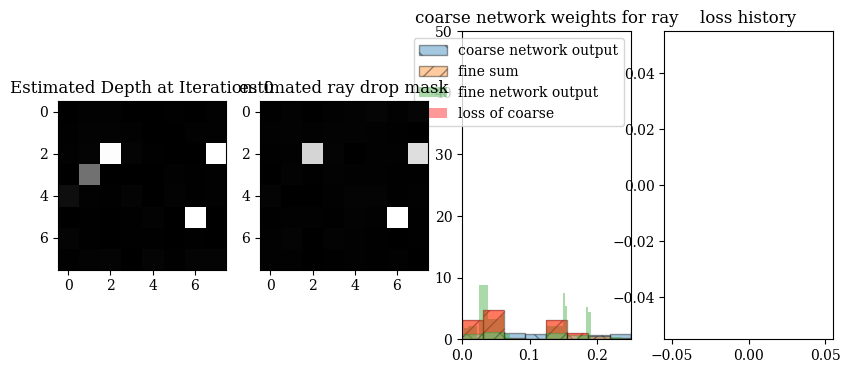

KeyboardInterrupt: 

In [499]:
from lidar_nerf_utils import *
from coarse_network_utils import*

model_coarse = init_model_proposal()
model_fine = init_model()
# model_fine = model #warm start from previous training loop
loss_hist = np.zeros([0])

# optimizer_coarse = tf.keras.optimizers.Adam(1e-3)
# optimizer_coarse = tf.keras.optimizers.Adam(1e-4)
# optimizer_coarse = tf.keras.optimizers.Adam(5e-5)
optimizer_coarse = tf.keras.optimizers.Adam(1e-5)
# optimizer_coarse = tf.keras.optimizers.Adam(5e-6)
# optimizer_coarse = tf.keras.optimizers.Adam(1e-6)
# optimizer_coarse = tf.keras.optimizers.Adam(1e-9)

# optimizer_fine = tf.keras.optimizers.Adam(5e-4)
# optimizer_fine = tf.keras.optimizers.Adam(1e-4)
# optimizer_fine = tf.keras.optimizers.Adam(5e-5)
# optimizer_fine = tf.keras.optimizers.Adam(2.5e-5)
optimizer_fine = tf.keras.optimizers.Adam(1e-5)
# optimizer_fine = tf.keras.optimizers.Adam(5e-6)
# optimizer_fine = tf.keras.optimizers.Adam(2.5e-6)
# optimizer_fine = tf.keras.optimizers.Adam(1e-6) # <---
# optimizer_fine = tf.keras.optimizers.Adam(1e-7)


n_bins_fine = 128 #512 #128
n_bins_coarse = 32 #64 #32
near=0.
far=1.
N_iters = 1_000_000 #5_000
psnrs = []
iternums = []
i_plot = 128 #256

n_rots = 128 #128 #number of horizontal patches per 2*pi
n_vert_patches = 1 #8 #number of vertical patches between phimin and phimax
H = 64 // n_vert_patches
W = 1024 // n_rots

vertical_bins = np.linspace(phimin, phimax, n_vert_patches+1)  
phivals = np.linspace(phimin, phimax, 64)#new (correct) way to bin elevation angles

loss_since_last_plot = np.zeros([0])
for i in range(N_iters):
    img_i = np.random.randint(images.shape[0])

#     #use full vertical span of patch 
#     target = images[img_i,:,:,:1]
#     target_drop_mask = images[img_i,:,:,1:]
#     pose = poses[img_i]
#     rays_d = rays_d_all[img_i]
#     rays_o = rays_o_all[img_i]
        
    #break up scans vertically at train time
    # this works but make sure to drop the LR proportionally!
    patch_height = 8 #16
    vert_crop_start = np.random.randint(0,H - patch_height - 1)
    vert_crop_end = vert_crop_start + patch_height
    target = images[img_i,vert_crop_start:vert_crop_end,:,:1]
    target_drop_mask = images[img_i,vert_crop_start:vert_crop_end,:,1:]
    pose = poses[img_i]
    rays_d = rays_d_all[img_i, vert_crop_start:vert_crop_end]
    rays_o = rays_o_all[img_i, vert_crop_start:vert_crop_end]
    
    
    idx_first=len(phivals) - (img_i%(n_vert_patches))*(64//n_vert_patches)-1
    idx_second= (len(phivals)- ((img_i+1)%(n_vert_patches))*(64//n_vert_patches))%len(phivals)
    phimin_patch = phivals[idx_first]
    phimax_patch = phivals[idx_second]

    with tf.GradientTape() as tape_coarse, tf.GradientTape() as tape_fine:
#     with tf.GradientTape() as tape_coarse:
        #run coarse network first to get locations to evaluate fine model at ~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        z_vals_coarse = tf.linspace(near, far - (far/n_bins_coarse), n_bins_coarse)  #IMPORTANT NOTE: z_vals must be in ascending order 
        z_vals_coarse += 0.0*tf.random.uniform(list(rays_o.shape[:-1]) + [n_bins_coarse]) * (far-near)/n_bins_coarse
        #DEBUG:
#         z_vals_coarse += 1.0*tf.random.uniform(list(rays_o.shape[:-1]) + [n_bins_coarse]) * (far-near)/n_bins_coarse
        z_vals_coarse = z_vals_coarse[:,:,:,None]#manually expand dimensions before passing in to coarse network (all pixels will share the same z_vals)
        #move z vals coarse to center of histogram bins ~~~~~~~~~~~
        width_coarse = tf.experimental.numpy.diff(z_vals_coarse, axis=2)
        width_coarse = tf.concat([width_coarse, 1.- z_vals_coarse[:,:,-1][:,:,None] ], axis=2)    
        z_vals_coarse = z_vals_coarse + width_coarse/2
#         print("z_vals_coarse", z_vals_coarse[0,0,:,0] - width_coarse[0,0,:,0]/2)
        
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~   
        z_vals_fine, width_fine, weights_coarse = run_coarse_network(model_coarse, z_vals_coarse, width_coarse, 
                                                                     rays_o, rays_d, n_resample = n_bins_fine) #,
                                                                     #repeat_coarse = False)    
        
        z_vals_fine = z_vals_fine[:, :, :, None]
        weights_coarse = weights_coarse[:, :, :, None]
                
        # run fine network to get actual scene density ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~        
        depth, ray_drop, CDF, weights_fine = render_rays(model_fine, rays_o, rays_d,  z_vals_fine, fine = False)
        depth = depth[:,:,None]
        ray_drop = ray_drop[:,:,None]
        gtCDF = z_vals_fine[:,:,:,0] > target[:,:,:]
        gtCDF = tf.cast(gtCDF, tf.float32)
        
        #weights of zero will produce zero area, leading to NaN loss
#         area_fine = tf.reduce_sum(weights_fine * width_fine, axis=2, keepdims=True)
#         print("weights fine before fix: \n", (weights_fine/area_fine)[0,0,:].numpy())             
        epsilon = 1e-6
#         padded_area_by_bin = weights_fine * width_fine + epsilon*tf.ones_like(width_fine) #was this
        padded_area_by_bin = (weights_fine + epsilon*tf.ones_like(width_fine)) * width_fine #slightly closer?
        area_fine = tf.reduce_sum(padded_area_by_bin, axis=2, keepdims=True)       
        weights_fine /= area_fine
#         print("weights fine after fix: \n", weights_fine[0,0,:].numpy())
#         print("min(area_fine)", tf.math.reduce_min(area_fine))

        #per mip-nerf 360, calculate fine losss first
        loss_fine = calculate_loss(depth, ray_drop, target, target_drop_mask, CDF = CDF, gtCDF = gtCDF)
        #for benchmarking-- run traditional "direct depth" loss
#         loss_fine = calculate_loss_Mai_City(depth, ray_drop, target, target_drop_mask)
        
        weights_fine_stopped = tf.stop_gradient(weights_fine)

        loss_coarse, fine_sum = calculate_loss_coarse_network(z_vals_coarse[:,:,:,0], 
                                                                z_vals_fine[:,:,:,0], 
                                                                weights_coarse[:,:,:,0], 
                                                                weights_fine_stopped, 
                                                                width_coarse[:,:,:,0],
                                                                width_fine[:,:,:],
                                                                debug = True)

        #TODO-- see if training works better without 
#         loss_coarse = loss_coarse * target_drop_mask[:,:,0] #suppress pixels with ray drop
        loss_coarse = tf.math.reduce_sum(loss_coarse)
        
        # Compute gradients and apply them
        gradients_fine = tape_fine.gradient(loss_fine, model_fine.trainable_variables)
        optimizer_fine.apply_gradients(zip(gradients_fine, model_fine.trainable_variables))        
        
        gradients_coarse = tape_coarse.gradient(loss_coarse, model_coarse.trainable_variables)
        optimizer_coarse.apply_gradients(zip(gradients_coarse, model_coarse.trainable_variables))


    if i % i_plot == 0:
        
        loss_hist = np.append(loss_hist, np.mean(loss_since_last_plot))
        loss_since_last_plot = np.zeros([0])
        
        #rescale weights_coarse before plotting ~~~~~~~~
        eps = 1e-3 #1e-3
        weights_coarse = weights_coarse + eps*tf.ones_like(weights_coarse)
        weights_coarse = weights_coarse/ tf.math.reduce_sum(width_coarse*weights_coarse, axis = 2)[:,:,None]
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        print("\n iteration:", i)            
        print("loss_coarse:", loss_coarse)
        print("loss_fine:", loss_fine)    
        mask = tf.cast(fine_sum > weights_coarse[:,:,:,0], tf.float32)
        L_along_ray = mask * (fine_sum - weights_coarse[:,:,:,0]) * width_coarse[:,:,:,0]

        look_at = 0
        p.figure(figsize=(10,4))
        p.subplot(141)
        p.imshow(depth,cmap = "gray")#, norm='log')
        p.title(f'Estimated Depth at Iteration: {i}')
        p.subplot(143)
        p.bar(z_vals_coarse[look_at,0,:,0], weights_coarse[look_at,0,:,0], width=width_coarse[look_at,0,:,0],
             alpha = 0.4, label = 'coarse network output', hatch = '\\', edgecolor = 'black')

        p.bar(z_vals_coarse[look_at,0,:,0], fine_sum[look_at,0,:], width=width_coarse[look_at,0,:,0],
             alpha = 0.4, label = 'fine sum', hatch = '//', edgecolor = 'black')

        p.bar(z_vals_fine[look_at,0,:,0], weights_fine[look_at,0,:], width=width_fine[look_at,0,:],
             alpha = 0.4, label= 'fine network output')
        p.bar(z_vals_coarse[look_at,0,:,0], L_along_ray[look_at,0,:]/width_coarse[look_at,0,:,0], width=width_coarse[look_at,0,:,0],
              bottom = weights_coarse[look_at,0,:,0], alpha = 0.4, color = 'red', 
              label= 'loss of coarse')    
        p.ylim([0,50])
        p.xlim([0,0.25])
        p.title('coarse network weights for ray')
        p.legend(loc="best")
        p.subplot(142)
        p.imshow(ray_drop, cmap="gray")#, norm = 'log')
        p.title("estimated ray drop mask")
        p.subplot(144)
        p.title("loss history")
        p.plot(loss_hist)
        p.show()
    else:
        loss_since_last_plot = np.append(loss_since_last_plot, loss_fine)

# Use Two Networks To Genrate Point Cloud At Novel Frame

In [552]:
num_view = 128 #512 #128 #number of (rotational?) patches to draw
n_bins_coarse = 64 #64
n_bins_fine = 512 #1024 #2048 #512 #256

start_frame_idx = 700 #320 #100 #20
start_idx = start_frame_idx*(128 - 2*(128 // 8))

near=0.
far= 1.
n_rots = 512 #128 #number of horizontal patches per 2*pi
n_vert_patches = 1 #number of vertical patches between phimin and phimax

H = 64 // n_vert_patches
W = 1024 // n_rots
# phimin = np.deg2rad(-15.593) #observed in raw data
# phimax = np.deg2rad(17.743)
phimax = np.deg2rad(15.593) #test -- might actually look better at render time?
phimin = np.deg2rad(-17.743)

plt = Plotter(N = 1, axes = 0, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]
savepc = np.zeros([0,3]) #to save point cloud to external file

very_beginning = time.time()

#tree only
# for j in range(120,150):
# for j in range(num_view):
for j in range(0,1): #165 #82
# suppress region of frame where researcher is blocking sensor returns
# for j in range(n_cols_to_skip, num_view - (n_cols_to_skip)//4):
    print(j,"/",n_rots)

    #get sensor transformation matrix
    rotm = poses[start_idx].copy()

#     center in courtyard
#     rotm[:3,-1] = np.array([5., 55., -13.])/200
#     center in forest -- startidx = 320
#     rotm[:3,-1] += np.array([25., 5, 0.])/200
    #raise slightly 
    rotm[2,-1] += 1/200

    # account for image crop in rotation
    crop_angle =  -(3*np.pi/n_rots) - j*(2*np.pi/n_rots) #test
    rotm_crop = R.from_euler('xyz', [0,0,-crop_angle + 3*np.pi/4]).as_matrix() 
    rotm[:3,:3] = rotm[:3,:3] @ rotm_crop
    rotm = rotm.astype(np.float32)
    vertical_bins = np.linspace(phimin, phimax, n_vert_patches+1)
    phimin_patch = vertical_bins[img_i%n_vert_patches] 
    phimax_patch = vertical_bins[img_i%n_vert_patches + 1]
    
    #RUN COARSE NETWORK
    rays_o, rays_d = get_rays(H, W, rotm, phimin_patch, phimax_patch)
    z_vals_coarse = tf.linspace(near, far - (far/n_bins_coarse), n_bins_coarse)  #IMPORTANT NOTE: z_vals must be in ascending order 
    z_vals_coarse += 0.00*tf.random.uniform(list(rays_o.shape[:-1]) + [n_bins_coarse]) * (far-near)/n_bins_coarse
    z_vals_coarse = z_vals_coarse[:,:,:,None]#manually expand dimensions before passing in to coarse network (all pixels will share the same z_vals)
    #move z vals coarse to center of histogram bins ~~~~~~~~~~~
    width_coarse = tf.experimental.numpy.diff(z_vals_coarse, axis=2)
    width_coarse = tf.concat([width_coarse, 1.- z_vals_coarse[:,:,-1][:,:,None] ], axis=2)    
    z_vals_coarse = z_vals_coarse + width_coarse/2
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~     
    z_vals_fine, width_fine, weights_coarse = run_coarse_network(model_coarse, z_vals_coarse, width_coarse, 
                                                                 rays_o, rays_d, n_resample = n_bins_fine,
                                                                 repeat_coarse=False)    
    eps = 1e-3 #1e-3
    weights_coarse_scaled = weights_coarse + eps*tf.ones_like(weights_coarse)
    weights_coarse_scaled = weights_coarse_scaled[:,:,:,None]/ tf.math.reduce_sum(width_coarse*weights_coarse_scaled[:,:,:,None], axis = 2)[:,:,None]
    
    z_vals_fine = z_vals_fine[:, :, :, None]
    weights_coarse = weights_coarse[:, :, :, None]
        
    #RUN FINE NETWORK
    depth, ray_drop, CDF, weights_fine = render_rays(model_fine, rays_o, rays_d,  z_vals_fine, 
                                                     roll_override=None)    
    
    new_point_cloud_spherical = np.zeros([np.shape(depth)[0]*np.shape(depth)[1],3])
    depth = tf.transpose(depth).numpy() #need this
    depth = np.flip(depth, axis = 0) #needed
    #scale back up to normal size
    depth *= 200 #50 #200
    ray_drop = tf.transpose(ray_drop).numpy() #test
    ray_drop = np.flip(ray_drop, axis = 0) #test
    count = 0
    for w in range(W):
        for h in range(H):
            new_point_cloud_spherical[count,0] = depth[w,h] #radius #draw all points
#             if ray_drop[w,h] > 0.95:             
#                     new_point_cloud_spherical[count,0] = depth[w,h] #radius
#             else:
#                     new_point_cloud_spherical[count,0] = 0#100 # suppress ray dropped points
            new_point_cloud_spherical[count,1] = (w+(1024//(2*n_rots)))/(2048//(2*n_rots))*(2*np.pi/n_rots)   #was this
            new_point_cloud_spherical[count,2] = np.pi/2 + phimax - (phimax-phimin)*(h/(H - 1)) #[17.74,-15.59] #(correct)       
            count+= 1

    new_point_cloud_spherical[:,1] -= -j*(2*np.pi/n_rots)
    new_point_cloud_spherical[:,2] -= (phimax+phimin)
    
    new_point_cloud_cart = LC.s2c(LC,new_point_cloud_spherical).numpy() #was this
    new_point_cloud_cart[:,2] = -new_point_cloud_cart[:,2] #need to flip z 
    savepc = np.append(savepc, new_point_cloud_cart, axis = 0)
    disp.append(Points(new_point_cloud_cart, c = 'gray', r = 3, alpha = 0.5))
#     disp.append(Points(new_point_cloud_cart, c = 'gray', r = 3, alpha = j/num_view))

plt.show(disp, "PLiNK")
ViewInteractiveWidget(plt.window)

0 / 512


ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

26.759647


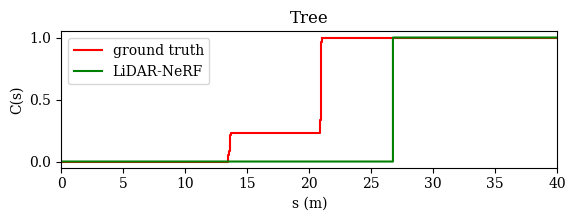

In [578]:
#need to plot at correct z vals (CDF is not linearly spaced)
h_idx = 20 #20
w_idx = 0
print(depth[w_idx,h_idx])

p.rc('font', family='DejaVu Serif')
fig, ax = p.subplots()
ax.set_xlabel('s (m)')
ax.set_ylabel('C(s)')
ax.set_title("Tree")
ax.set_xlim([0,40])
ax.set_aspect(10)

# for i in range(0,63):
#     ax.plot(z_vals_fine[i,w_idx,:]*200, CDF[i,w_idx,:])

# ax.plot(z_vals_fine[h_idx,w_idx,:]*200, CDF[h_idx,w_idx,:], c = 'blue')
# ax.plot(np.linspace(0,z_vals_fine[h_idx,w_idx,0],10)*200, np.ones([10])*CDF[h_idx,w_idx,200], c = 'blue', label = 'PLiNK')

# r = sorted(tree_hist[:,0])
# r = sorted(window_hist[:,0])
# r = sorted(wall_hist[:,0])
cdf = np.arange(1, len(r)+1)/len(r)
r = np.append(0, r)
cdf = np.append(0, cdf)
ax.step(r, cdf, where='post', c='red')
ax.plot(np.linspace(r[-1], r[-1]+20, 10), np.ones([10]), c = 'red', label = 'ground truth')

ln_cdf = np.zeros([1000])
ln_cdf[int(depth[w_idx,h_idx]/40*1000):] = 1
# print(ln_cdf)
ln_r = np.linspace(0,40,1000)
ax.step(ln_r, ln_cdf, where='post', c='green', label = 'LiDAR-NeRF')

ax.legend(loc='upper left')

In [577]:
# ln_cdf = np.zeros([1000])
# ln_cdf[435:] = 1
# ln_r = np.linspace(0,40,1000)

# print(z_vals_fine[h_idx,w_idx,:]*200)
# print(CDF[h_idx,w_idx,:])

to_save = np.array([ln_r, ln_cdf]).T
print(to_save)
# to_save = np.array([z_vals_fine[h_idx,w_idx,:]*200+2.7, CDF[h_idx,w_idx,:][:,None]])[:,:,0].T
# np.savetxt("LN_tree.txt", to_save)

[[ 0.          0.        ]
 [ 0.04004004  0.        ]
 [ 0.08008008  0.        ]
 ...
 [39.91991992  1.        ]
 [39.95995996  1.        ]
 [40.          1.        ]]


# Load in multiple raw point cloud from same pose sampled during ""dynamic spinning" dataset 

In [455]:
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]
tree_hist = np.zeros([0,3])
window_hist = np.zeros([0,3])
wall_hist = np.zeros([0,3])
for i in range(20): #7 30
    idx = 50 + i
#     colors = ['red', 'orange', 'yellow', 'green', 'blue', 'indigo', 'violet', 'purple', 'black']
    colors = ['gray'] * 100
    fn1 = "/media/derm/06EF-127D4/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(idx) + ".npy"
    pc1 = np.load(fn1)
    #remove zeros
    d = np.sqrt(pc1[:,0]**2 + pc1[:,1]**2 + pc1[:,2]**2) 
    pc1 = pc1[d > 0]
    
    #downsample to single look direction
    pc1_spherical = cartesian_to_spherical(pc1).numpy()
    #crop down sweep to look at single viewing angle
    #tree
    right_bound = np.where(pc1_spherical[:,1] > 1.495)
    left_bound = np.where(pc1_spherical[:,1] < 1.50)
    upper_bound = np.where(pc1_spherical[:,2] < 1.35)    
    lower_bound = np.where(pc1_spherical[:,2] > 1.34)    
    bounds = np.intersect1d(left_bound, right_bound)
    bounds = np.intersect1d(bounds, lower_bound)
    bounds = np.intersect1d(bounds, upper_bound)
    tree = spherical_to_cartesian(pc1_spherical[bounds])
    tree_hist = np.append(tree_hist, pc1_spherical[bounds], axis = 0)

    #window
    right_bound = np.where(pc1_spherical[:,1] > -2.59) #looks good but difficluty replicating
    left_bound = np.where(pc1_spherical[:,1] < -2.58)
    upper_bound = np.where(pc1_spherical[:,2] < 1.3)    
    lower_bound = np.where(pc1_spherical[:,2] > 1.29)    
#     right_bound = np.where(pc1_spherical[:,1] > -2.61) #test
#     left_bound = np.where(pc1_spherical[:,1] < -2.60) #test
#     upper_bound = np.where(pc1_spherical[:,2] < 1.5)  #test  
#     lower_bound = np.where(pc1_spherical[:,2] > 1.49)  #test
    bounds = np.intersect1d(left_bound, right_bound)
    bounds = np.intersect1d(bounds, lower_bound)
    bounds = np.intersect1d(bounds, upper_bound)
    window = spherical_to_cartesian(pc1_spherical[bounds])
    window_hist = np.append(window_hist, pc1_spherical[bounds], axis = 0)

    #wall
    right_bound = np.where(pc1_spherical[:,1] < 2.6)
    left_bound = np.where(pc1_spherical[:,1] > 2.595)
    upper_bound = np.where(pc1_spherical[:,2] < 1.36)    
    lower_bound = np.where(pc1_spherical[:,2] > 1.355)    
    bounds = np.intersect1d(left_bound, right_bound)
    bounds = np.intersect1d(bounds, lower_bound)
    bounds = np.intersect1d(bounds, upper_bound)
    wall = spherical_to_cartesian(pc1_spherical[bounds])
    wall_hist = np.append(wall_hist, pc1_spherical[bounds], axis = 0)

    disp.append(Points(pc1, c = colors[i], r = 3, alpha = 0.04))
    disp.append(Points(tree, c = 'red', r = 10, alpha = 1.))
    disp.append(Points(window, c = 'blue', r = 10, alpha = 1.))
    disp.append(Points(wall, c = 'green', r = 10, alpha = 1.))

print(len(window))
plt.show(disp, "Dynamic Spinning Raw Data")
ViewInteractiveWidget(plt.window)

3


ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

[[ 0.          0.        ]
 [17.21300126  0.05      ]
 [17.24000211  0.1       ]
 [17.26700029  0.15      ]
 [17.28400034  0.2       ]
 [17.28400034  0.25      ]
 [17.29499977  0.3       ]
 [17.30400065  0.35      ]
 [17.31500013  0.4       ]
 [17.3190003   0.45      ]
 [17.32500092  0.5       ]
 [17.33200093  0.55      ]
 [17.33200093  0.6       ]
 [17.33200093  0.65      ]
 [17.36400031  0.7       ]
 [17.37600102  0.75      ]
 [17.37800004  0.8       ]
 [17.41200094  0.85      ]
 [17.41700161  0.9       ]
 [17.46100069  0.95      ]
 [17.47500043  1.        ]]


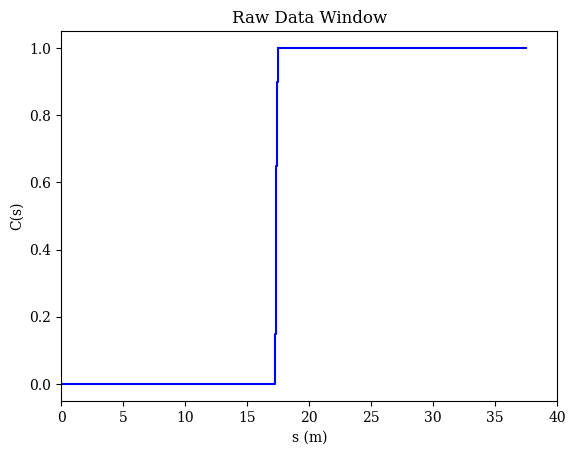

In [498]:
p.rc('font', family='DejaVu Serif')
fig, ax = p.subplots()
ax.set_xlabel('s (m)')
ax.set_ylabel('C(s)')
ax.set_title("Raw Data Window")
ax.set_xlim([0,40])

# r = sorted(tree_hist[:,0])
# r = sorted(window_hist[:,0])
r = sorted(wall_hist[:,0])
cdf = np.arange(1, len(r)+1)/len(r)
r = np.append(0, r)
cdf = np.append(0, cdf)

ax.step(r, cdf, where='post', label='CDF', c='blue')
ax.plot(np.linspace(r[-1], r[-1]+20, 10), np.ones([10]), c = 'blue')


to_save = np.array([r, cdf]).T
print(to_save)
np.savetxt("gt_wall.txt",to_save)


In [92]:
#load ground truth poses from dynamic spinning sequence
fn = "/media/derm/06EF-127D4/Newer College Dataset/06_Dynamic_Spinning/registered_poses.csv"
gt_ds = np.loadtxt(fn,delimiter=',',skiprows = 1)
# print(gt_ds)

xyz_ds = gt_ds[:, 2:5]
qxyzw_ds = gt_ds[:, 5:]
num_poses_ds = qxyzw_ds.shape[0]
sensor_poses_ds = np.eye(4, dtype=np.float64).reshape(1, 4, 4).repeat(num_poses_ds, axis=0)
sensor_poses_ds[:, :3, :3] = R.from_quat(qxyzw_ds).as_matrix().copy()
sensor_poses_ds[:, :3, 3] = xyz_ds.copy()

print(sensor_poses_ds[-1])


# poses_ds = np.zeros([n_images*n_rots*n_vert_patches,4,4])
#courtyard1
sensor_poses_ds[:,0,-1] += 30
sensor_poses_ds[:,1,-1] += 30
sensor_poses_ds[:,2,-1] += 15 
sensor_poses_ds[:,:3,-1] *= shrink_factor #0.02 #0.005 #COURTYARD
#courtyard
sensor_poses_ds[:,0,-1] += 0.01 #TEST -- shift up just a little
sensor_poses_ds[:,1,-1] += 0.25 #shift towards positive x
sensor_poses_ds[:,2,-1] += 0.25 #translate above xy plane

print(sensor_poses_ds[-1])
# print(poses[-1])
# print(shrink_factor)

[[-0.84127379 -0.53774224  0.05560301 -7.64503867]
 [ 0.5370601  -0.84308465 -0.02783373 -8.12910383]
 [ 0.06184542  0.00644637  0.99806492 -0.01065497]
 [ 0.          0.          0.          1.        ]]
[[-0.84127379 -0.53774224  0.05560301  0.12177481]
 [ 0.5370601  -0.84308465 -0.02783373  0.35935448]
 [ 0.06184542  0.00644637  0.99806492  0.32494673]
 [ 0.          0.          0.          1.        ]]


In [93]:
# print(sensor_poses[1200])
print(poses[1199*(128*6//8)])

plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

disp.append(Points(poses[::(128*6//8),:3,3], c = 'red'))
disp.append(Points(sensor_poses_ds[:,:3,3], c = 'blue'))

plt.show(disp, "sensor poses for quad with dynamics and dynaimc spinning sequences")
ViewInteractiveWidget(plt.window)

[[ 0.7728087  -0.6341544   0.02479906 -0.03374249]
 [ 0.6321047   0.7726233   0.05913424  0.19164208]
 [-0.05666057 -0.03002385  0.997942    0.32854584]
 [ 0.          0.          0.          1.        ]]


ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

In [128]:
#looks like training poses[700*128*6//8] is pretty much exactly what we want
def draw_frame_from_rays(disp, n_rots=128, n_vert_patches=1, frameIdx=0, 
                         color = 'red', stitched_map = np.zeros([0,3]) ):

    phimin = np.deg2rad(-15.594) #took forever to figure this out...
    phimax = np.deg2rad(17.743)
    H = 64 // n_vert_patches
    W = 1024 // n_rots
    vertical_bins = np.linspace(phimin, phimax, n_vert_patches+1)  
    phivals = np.linspace(phimin, phimax, 64)#new (correct) way to bin elevation angles
    n_cols_to_skip = n_rots // 8
    
    #old way (directly using rays_o and rays_d) ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#     print("\n old method:", rays_o_all[frameIdx*(n_rots - 2*n_cols_to_skip),0,0])

    pts1 = np.zeros([1,3])
    for p in range(frameIdx*(n_rots - 2*n_cols_to_skip), (frameIdx + 1 )*(n_rots - 2*n_cols_to_skip)):
        for i in range(n_vert_patches):
            img_i = i
            idx_first=len(phivals) - (img_i%(n_vert_patches))*(64//n_vert_patches)-1
            idx_second= (len(phivals)- ((img_i+1)%(n_vert_patches))*(64//n_vert_patches))%len(phivals)
            phimin_patch = phivals[idx_first]
            phimax_patch = phivals[idx_second]

            pose = poses[i + p*n_vert_patches]
            rays_o = rays_o_all[i + p*n_vert_patches]
            rays_d = rays_d_all[i + p*n_vert_patches]
            
            inMap1 = add_patch(rays_o, rays_d, images[i+p*n_vert_patches,:,:,0])

            pts1 = np.append(pts1, inMap1, axis = 0)
        disp.append(Points(rays_o[0,:1,:], r = 15, c = 'purple')) #DEBUG 

    color = 'red'#for debug
    vizPts1 = Points(pts1, c = color, r = 3., alpha = 0.125)
    disp.append(vizPts1)
    
    stitched_map = np.append(stitched_map, pts1, axis = 0)
    return stitched_map    
    
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]          

n_images = 1200
stitched_map = np.zeros([0,3])
# colors = ['red', 'orange', 'yellow', 'green', 'blue', 'indigo', 'violet', 'red']
colors = np.linspace(0.1,0.3,n_images)[:,None] * np.array([[1,1,1]])
# for i in range(len(colors)):
for i in range(0,1200,100): #(0,1200,100)
    print(i)
    stitched_map = draw_frame_from_rays(disp, n_rots = 128, n_vert_patches=1, 
                                        frameIdx = i, color=colors[i], stitched_map=stitched_map)

#draw raw point cloud from dynamic spinning dataset
fn1 = "/media/derm/06EF-127D4/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(idx) + ".npy"
pc1 = np.load(fn1)

pc1 =  np.append(pc1, np.ones([len(pc1),1]), axis = 1) @ sensor_poses_ds[-1]
pc1 = pc1[:,:3]
pc1 *= shrink_factor
pc1 += np.array([0.0835,0.38,0.325])

disp.append(Points(pc1, c = 'black', r = 3, alpha = 0.1))

disp.append(Points(poses[700*128*6//8,:3,3][None,:], c = 'green', r = 30, alpha = 1.))

plt.show(disp, "Drawing training data from depth images, rays_o, and rays_d")
ViewInteractiveWidget(plt.window)  

0
100
200
300
400
500
600
700
800
900
1000
1100


ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

In [124]:
print(poses[700*128*6//8,:3,3])

[0.08198849 0.383629   0.32733184]


# Randomly generate multiple point clouds with inverse transform sampling of C at the same pose, draw on top of one another

In [ ]:
# overridePt0001 = savepc.copy()

plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

disp.append(Points(overridePt0001, c = 'red', r = 3.5, alpha = 0.2))
# disp.append(Points(overridePt001, c = 'orange', r = 3., alpha = 0.5))
disp.append(Points(overridePt01, c = 'yellow', r = 3., alpha = 0.5))
disp.append(Points(overridePt1, c = 'green', r = 3., alpha = 0.5))
# disp.append(Points(overridePt2, c = 'blue', r = 3., alpha = 0.5))
# disp.append(Points(overridePt3, c = 'indigo', r = 3., alpha = 0.5))
# disp.append(Points(overridePt5, c = 'violet', r = 3.5, alpha = 0.2))

# disp.append(Points(rs1, c = 'red', r = 3., alpha = 0.5))
# disp.append(Points(rs2, c = 'orange', r = 3., alpha = 0.5))
# disp.append(Points(rs3, c = 'yellow', r = 3., alpha = 0.5))

disp.append(Points(aligned_gt, c = 'black', r = 3, alpha = 1))

plt.show(disp, "Aligning Synthetic with Raw Point Clouds")
ViewInteractiveWidget(plt.window)

# Align raw and synthetic scans at same pose

In [ ]:
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

#raw point cloud
# idx = 7650 + 5*start_frame_idx
idx = 7650 + start_frame_idx
fn1 = "/media/derm/06EF-127D4/Newer College Dataset/01_Short_Experiment/point_clouds/frame_" + str(idx) + ".npy"
pc1 = np.load(fn1)
# disp.append(Points(pc1, c = 'g', r = 3.5, alpha = 0.2))

#~~~~~~~
#align nerf output with gt scan
# distortion correction ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
m_hat = np.array([-vel_body_frame[idx,0],
                  -vel_body_frame[idx,1],
                  -vel_body_frame[idx,2],
                  -rot_vel_euls[idx,0], #looks good
                  -rot_vel_euls[idx,1],
                  -rot_vel_euls[idx,2]
                  #0.,0.,0.
                 ])   
pc1 = apply_motion_profile(pc1, m_hat, period_lidar=1.)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
pc1 = np.flip(pc1, axis = 0)# uncomment to flip and maintain CCW convention used in VICET

#Register undistorted PC against HD Map using ICET to correct issues in ground truth------------------------
submap_in_pc1_frame = (np.linalg.pinv(sensor_poses[idx]) @ initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T #test
submap_in_pc1_frame = submap_in_pc1_frame[:,:3]

initial_guess = tf.constant([0.,0.,0.,0.,0.,0.])
it = ICET(cloud1 = savepc, cloud2 = pc1, fid = 70, niter = 8, 
   draw = False, group = 2, RM = False, DNN_filter = False, x0 = initial_guess)
#----------------------------------------------------------------------------------------------------------------

print(np.shape(R.from_euler('xyz', [it.X[3], it.X[4], it.X[5]]).as_matrix()))
aligned_gt = pc1 @ R.from_euler('xyz', [it.X[3], it.X[4], it.X[5]]).as_matrix().T + it.X[:3]

# # remove points too close to origin
# d = np.sqrt(np.sum(aligned_gt**2, axis = 1))
# good  = np.argwhere(d > 2.)[:,0]
# aligned_gt = aligned_gt.numpy()[good]

# #draw NeRF output
# # remove points too close to origin
# d = np.sqrt(np.sum(savepc**2, axis = 1))
# good  = np.argwhere(d > 2.)[:,0]
# savepc = savepc[good]
disp.append(Points(savepc, c = 'r', r = 3.5, alpha = 0.5))
disp.append(Points(aligned_gt, c = 'green', r = 3.5, alpha = 0.5))


n_cols_to_skip = n_rots // 8 
poses_index = start_frame_idx*(128 * n_vert_patches - 2*n_cols_to_skip*n_vert_patches)
# print(poses[poses_index])
nerf_to_map = poses[poses_index].copy()
nerf_to_map[:3,-1] *= 200
# nerf_to_map[:3,:3] = nerf_to_map[:3,:3] @ R.from_euler('xyz', [0.,0.,-np.pi/4]).as_matrix()

#TODO put NeRF output and aligned raw scan in the frame of our new stitched map
# nerf_mapframe = (sensor_poses[idx] @ np.append(savepc, np.ones([len(savepc), 1]), axis = 1).T).T

savepc_rotated = savepc @ R.from_euler('xyz', [0.,0.,np.pi/4 - np.pi/128]).as_matrix()
nerf_mapframe = (nerf_to_map @ np.append(savepc_rotated, np.ones([len(savepc), 1]), axis = 1).T).T
nerf_mapframe = nerf_mapframe[:,:3]

disp.append(Points(nerf_mapframe, c = 'purple', r = 3.5, alpha = 0.3))

stitched_map=np.load("generatedPointClouds/stitched_map.npy")
disp.append(Points(stitched_map, c = 'gray', r = 3.5, alpha = 0.1))

plt.show(disp, "Aligning Synthetic with Raw Point Clouds")
ViewInteractiveWidget(plt.window)

In [ ]:
print(np.shape(stitched_map))
print(np.shape(nerf_mapframe))

#downsample stitched point cloud
import open3d as o3d
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(200*stitched_map)
voxel_size = 0.1  # Adjust this value based on your data and desired level of downsampling
pcd = pcd.voxel_down_sample(voxel_size)

downsampled_stitched_map = np.asarray(pcd.points)

print(len(downsampled_stitched_map))
# np.save("generatedPointClouds/stitched_map.npy", downsampled_stitched_map)

In [ ]:
np.save("generatedPointClouds/"+str(idx)+"NeRF.npy" ,savepc)
# np.save("generatedPointClouds/"+str(idx)+"NeRF.npy", nerf_mapframe)

np.save("generatedPointClouds/"+str(idx)+"real.npy", aligned_gt)


In [500]:
# # #[D=8, W=256] 12 pos enc 5 ang enc
# model_fine.save_weights("models/fine1.ckpt")
# model_fine.save('models/fine1.keras')
# # #[D=8, W=256] 10 pos enc 5 ang enc
# model_coarse.save_weights("models/coarse1.ckpt")
# model_coarse.save('models/coarse1.keras')

# #only trained for a couple of hours
# # #[D=8, W=256] 15 pos enc 5 ang enc
# model_fine.save_weights("models/fine2.ckpt")
# model_fine.save('models/fine2.keras')
# # #[D=8, W=256] 10 pos enc 5 ang enc
# model_coarse.save_weights("models/coarse2.ckpt")
# model_coarse.save('models/coarse2.keras')

# # #trained overnight-- fine model seems good but coarse model still stuck a bit
# # #[D=8, W=256] 15 pos enc 5 ang enc
# model_fine.save_weights("models/fine3.ckpt")
# model_fine.save('models/fine3.keras')
# # #[D=6, W=128] 10 pos enc 5 ang enc
# model_coarse.save_weights("models/coarse3.ckpt")
# model_co arse.save('models/coarse3.keras')


# ## increasing size of fine network...
# # #[D=10, W=512] 15 pos enc 5 ang enc
# model_fine.save_weights("models/fine4.ckpt")
# model_fine.save('models/fine4.keras')
# # #[D=8, W=256] 10 pos enc 5 ang enc
# model_coarse.save_weights("models/coarse4.ckpt")
# model_coarse.save('models/coarse4.keras')

# # #BEST SO FAR
# # # # #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# #more training at lower LR with 4 vertical patches
# # #[D=10, W=512] 15 pos enc 5 ang enc
# model_fine.save_weights("models/fine5.ckpt")
# model_fine.save('models/fine5.keras')
# # #[D=8, W=256] 10 pos enc 5 ang enc
# model_coarse.save_weights("models/coarse5.ckpt")
# model_coarse.save('models/coarse5.keras')
# # # # #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# # # FOREST -- also looks quite good (little more noisy though, as expected)
# # #[D=10, W=512] 15 pos enc 5 ang enc
# model_fine.save_weights("models/fine6.ckpt")
# model_fine.save('models/fine6.keras')
# # #[D=8, W=256] 10 pos enc 5 ang enc
# model_coarse.save_weights("models/coarse6.ckpt")
# model_coarse.save('models/coarse6.keras')

# # Courtyard with corrected sensor intrinsics
# #[D=8, W=256] 15 pos enc 5 ang enc
# model_fine.save_weights("models/fine7.ckpt")
# model_fine.save('models/fine7.keras')
# # #[D=8, W=256] 10 pos enc 5 ang enc
# model_coarse.save_weights("models/coarse7.ckpt")
# model_coarse.save('models/coarse7.keras')

# ## 9/27 -- same updated sensor intrinsics
# # # Courtyard with corrected sensor intrinsics
# # #[D=10, W=512] 18 pos enc 6 ang enc
# model_fine.save_weights("models/fine8.ckpt")
# model_fine.save('models/fine8.keras')
# # #[D=10, W=512] 18 pos enc 6 ang enc
# model_coarse.save_weights("models/coarse8.ckpt")
# model_coarse.save('models/coarse8.keras')

# #getting rid of gradient loss
# # #[D=10, W=512] 18 pos enc 6 ang enc
# model_fine.save_weights("models/fine9.ckpt")
# model_fine.save('models/fine9.keras')
# # #[D=10, W=512] 18 pos enc 6 ang enc
# model_coarse.save_weights("models/coarse9.ckpt")
# model_coarse.save('models/coarse9.keras')

# # Forest with updated sensor intrinsics
# # #[D=10, W=512] 18 pos enc 6 ang enc
# model_fine.save_weights("models/fine10.ckpt")
# model_fine.save('models/fine10.keras')
# # #[D=10, W=512] 18 pos enc 6 ang enc
# model_coarse.save_weights("models/coarse10.ckpt")
# model_coarse.save('models/coarse10.keras')

# #LIDAR NERF BENCHMARKING
# # #[D=8, W=256] 15 pos enc 5 ang enc
# model_fine.save_weights("models/fineLN_NC.ckpt")
# model_fine.save('models/fineLN_NC.keras')
# # #[D=8, W=256] 15 pos enc 5 ang enc
# model_coarse.save_weights("models/coarseLN_NC.ckpt")
# model_coarse.save('models/coarseLN_NC.keras')

# # #Very Large PLiNK
# # #[D=12, W=1024] 18 pos enc 6 ang enc
# model_fine.save_weights("models/fine11.ckpt")
# model_fine.save('models/fine11.keras')
# # #[D=10, W=512] 18 pos enc 6 ang enc
# model_coarse.save_weights("models/coarse11.ckpt")
# model_coarse.save('models/coarse11.keras')

# # Forest for Yifan
# model_fine.save_weights("models/fineForestStart.ckpt")
# model_fine.save('models/fineForestStart.keras')
# model_coarse.save_weights("models/coarseForestStart.ckpt")
# model_coarse.save('models/coarseForestStart.keras')

# model_coarse.load_weights('models/coarse9.ckpt') #best so far
# model_fine.load_weights('models/fine9.ckpt') #best so far
# model_coarse.load_weights('models/coarse11.ckpt') #larger model, not actually better resolution though
# model_fine.load_weights('models/fine11.ckpt')
model_coarse.load_weights('models/coarseLN_NC.ckpt')
model_fine.load_weights('models/fineLN_NC.ckpt')

# Repeatedly render the same viewpoint while cointinuously adjusting CDF sample value to show ability of network to view into different surfaces 

In [ ]:
fig, ax = p.subplots()

num_render = 25

x = np.linspace(0,num_render-1,num_render)
# y = 1-np.log(num_render-x)/np.max(np.log(x))
y = x**3/np.max(x**3)
# y = 1/(1+np.exp(-x + num_render//2))
# y = y**(0.5)

print(y)

ax.plot(x,y)    

In [ ]:
num_render = 25

for nr in range(1,num_render):
    print(nr)
#     r = 1-np.log(num_render-nr)/np.max(np.log(nr))
    r = nr**3/(num_render**3)
    print("rendering frame", r)
    
    num_view = 128 #128 #number of (rotational?) patches to draw
    n_bins_coarse = 64 #32
    n_bins_fine = 1024 #1024 #2048 #512 #256

    start_frame_idx = 100 #100 #20
    start_idx = start_frame_idx*(n_rots - 2*n_cols_to_skip)

    near=0.
    far= 1.
    n_rots = 128 #128 #number of horizontal patches per 2*pi
    n_vert_patches = 1 #number of vertical patches between phimin and phimax

    H = 64 // n_vert_patches
    W = 1024 // n_rots
    # phimin = np.deg2rad(-15.593) #observed in raw data
    # phimax = np.deg2rad(17.743)
    phimax = np.deg2rad(15.593) #test -- might actually look better at render time?
    phimin = np.deg2rad(-17.743)

    savepc = np.zeros([0,3]) #to save point cloud to external file
    very_beginning = time.time()

    for j in range(num_view):
        if j % 64 ==0:
            print(j)
        #get sensor transformation matrix
        rotm = poses[start_idx].copy()
        #center in courtyard
        rotm[:3,-1] = np.array([5., 55., -13.])/200

        # account for image crop in rotation
        crop_angle =  -(3*np.pi/n_rots) - j*(2*np.pi/n_rots) #test
        rotm_crop = R.from_euler('xyz', [0,0,-crop_angle + 3*np.pi/4]).as_matrix() 
        rotm[:3,:3] = rotm[:3,:3] @ rotm_crop
        rotm = rotm.astype(np.float32)
        vertical_bins = np.linspace(phimin, phimax, n_vert_patches+1)
        phimin_patch = vertical_bins[img_i%n_vert_patches] 
        phimax_patch = vertical_bins[img_i%n_vert_patches + 1]

        #RUN COARSE NETWORK
        rays_o, rays_d = get_rays(H, W, rotm, phimin_patch, phimax_patch)
        z_vals_coarse = tf.linspace(near, far - (far/n_bins_coarse), n_bins_coarse)  #IMPORTANT NOTE: z_vals must be in ascending order 
        z_vals_coarse += 0.00*tf.random.uniform(list(rays_o.shape[:-1]) + [n_bins_coarse]) * (far-near)/n_bins_coarse
        z_vals_coarse = z_vals_coarse[:,:,:,None]#manually expand dimensions before passing in to coarse network (all pixels will share the same z_vals)
        #move z vals coarse to center of histogram bins ~~~~~~~~~~~
        width_coarse = tf.experimental.numpy.diff(z_vals_coarse, axis=2)
        width_coarse = tf.concat([width_coarse, 1.- z_vals_coarse[:,:,-1][:,:,None] ], axis=2)    
        z_vals_coarse = z_vals_coarse + width_coarse/2
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~     
        z_vals_fine, width_fine, weights_coarse = run_coarse_network(model_coarse, z_vals_coarse, width_coarse, 
                                                                     rays_o, rays_d, n_resample = n_bins_fine) #,
                                                                     #repeat_coarse=False)    
        eps = 1e-3 #1e-3
        weights_coarse_scaled = weights_coarse + eps*tf.ones_like(weights_coarse)
        weights_coarse_scaled = weights_coarse_scaled[:,:,:,None]/ tf.math.reduce_sum(width_coarse*weights_coarse_scaled[:,:,:,None], axis = 2)[:,:,None]

        z_vals_fine = z_vals_fine[:, :, :, None]
        weights_coarse = weights_coarse[:, :, :, None]

        #RUN FINE NETWORK
        depth, ray_drop, CDF, weights_fine = render_rays(model_fine, rays_o, rays_d,  z_vals_fine,
                                                        roll_override = r )    

        new_point_cloud_spherical = np.zeros([np.shape(depth)[0]*np.shape(depth)[1],3])
        depth = tf.transpose(depth).numpy() #need this
        depth = np.flip(depth, axis = 0) #needed
        #scale back up to normal size
        depth *= 200 #50 #200
        ray_drop = tf.transpose(ray_drop).numpy() #test
        ray_drop = np.flip(ray_drop, axis = 0) #test
        count = 0
        for w in range(W):
            for h in range(H):
    #             new_point_cloud_spherical[count,0] = depth[w,h] #radius #draw all points
                if ray_drop[w,h] > 0.9:             
                        new_point_cloud_spherical[count,0] = depth[w,h] #radius
                else:
                        new_point_cloud_spherical[count,0] = 0#100 # suppress ray dropped points
                new_point_cloud_spherical[count,1] = (w+(1024//(2*n_rots)))/(2048//(2*n_rots))*(2*np.pi/n_rots)   #was this
                new_point_cloud_spherical[count,2] = np.pi/2 + phimax - (phimax-phimin)*(h/(H - 1)) #[17.74,-15.59] #(correct)       
                count+= 1

        new_point_cloud_spherical[:,1] -= -j*(2*np.pi/n_rots)
        new_point_cloud_spherical[:,2] -= (phimax+phimin)

        new_point_cloud_cart = LC.s2c(LC,new_point_cloud_spherical).numpy() #was this
        new_point_cloud_cart[:,2] = -new_point_cloud_cart[:,2] #need to flip z 
        savepc = np.append(savepc, new_point_cloud_cart, axis = 0)
    np.save("generatedPointClouds/CDF_fig_frame_"+str(nr)+".npy" ,savepc)

In [ ]:
# plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
# disp=[]

# disp.append(Points(savepc, c = 'gray', r = 3., alpha = 0.8))

# plt.show(disp, "Aligning Synthetic with Raw Point Clouds")
# ViewInteractiveWidget(plt.window)

In [ ]:
#open point clouds with vedo, turn to figure, save image

# # angled
# cam = dict(
#     pos=(-3.610291, -57.34150, 29.14759),
#     focalPoint=(-1.306571, -3.782887, 11.55685),
#     viewup=(4.104768e-3, 0.3118777, 0.9501134),
#     distance=56.42044,
#     clippingRange=(0.3085674, 308.5674),
# )
#directly overhead
cam = dict(
    pos=(-1.927269, -15.23255, 158.6110),
    focalPoint=(-0.3105306, -8.219276, 12.32798),
    viewup=(-0.8736472, -0.4854444, -0.03292941),
    distance=146.4600,
    clippingRange=(97.72483, 210.5821),
)

for i in range(1,num_render):
    plt = Plotter(N = 1, axes = 4, bg = (1, 1, 1), offscreen=True)
    disp=[] 
    pc1 = np.load("generatedPointClouds/CDF_fig_frame_" + str(i) + ".npy")
    
    #remove random points near origin
    d = np.sqrt(np.sum(pc1**2, axis = 1))
    good  = np.argwhere(d > 2.)[:,0]
    pc1 = pc1[good]
    
    disp.append(Points(pc1, r = 2, c = 'gray', alpha = 0.5))
    
    #NOTE-- c gets distorted when rendering becuase we force resampling on coarse points
    c = i**3/((num_render-5)**3) 

    plt.show(disp, "C = " + str(c),
             camera= cam).screenshot("lidar_nerf_demo/CDF_fig_frame_" + str(i) + ".png")
    plt.clear()
    plt.close()

# Generate Novel Point Clouds along unseen frames in trajectory, save results for calcuating chamfer distance, completion, accuracy and F-score in seperate notebook 

In [ ]:
num_view = 128 #128 #number of (rotational?) patches to draw
n_bins_coarse = 64
n_bins_fine = 1024 #1024 #1024 

near=0.
far= 1.
n_rots = 128 #128 #number of horizontal patches per 2*pi
n_cols_to_skip = n_rots // 8 
n_vert_patches = 1 #number of vertical patches between phimin and phimax

H = 64 // n_vert_patches
W = 1024 // n_rots
# phimin = np.deg2rad(-15.593) #observed in raw data
# phimax = np.deg2rad(17.743)
phimax = np.deg2rad(15.593) #test -- might actually look better at render time?
phimin = np.deg2rad(-17.743)

for start_frame_idx in range(0,1200,30):
    start_idx = start_frame_idx*(n_rots - 2*n_cols_to_skip)
    print("\n generating nerf for frame:", 7650 + start_frame_idx)
    
    savepc = np.zeros([0,3]) #to save point cloud to external file

    for j in range(num_view):
    # suppress region of frame where researcher is blocking sensor returns
#     for j in range(n_cols_to_skip, num_view - (n_cols_to_skip)//4):

        #get sensor transformation matrix
        rotm = poses[start_idx].copy()
        # account for image crop in rotation
        crop_angle =  -(3*np.pi/n_rots) - j*(2*np.pi/n_rots) #test
        rotm_crop = R.from_euler('xyz', [0,0,-crop_angle + 3*np.pi/4]).as_matrix() #TEST
        rotm[:3,:3] = rotm[:3,:3] @ rotm_crop
        rotm = rotm.astype(np.float32)
        vertical_bins = np.linspace(phimin, phimax, n_vert_patches+1)
        phimin_patch = vertical_bins[img_i%n_vert_patches] 
        phimax_patch = vertical_bins[img_i%n_vert_patches + 1]

        #RUN COARSE NETWORK
        rays_o, rays_d = get_rays(H, W, rotm, phimin_patch, phimax_patch)
        z_vals_coarse = tf.linspace(near, far - (far/n_bins_coarse), n_bins_coarse)  #IMPORTANT NOTE: z_vals must be in ascending order 
        z_vals_coarse += 0.00*tf.random.uniform(list(rays_o.shape[:-1]) + [n_bins_coarse]) * (far-near)/n_bins_coarse
        z_vals_coarse = z_vals_coarse[:,:,:,None]#manually expand dimensions before passing in to coarse network (all pixels will share the same z_vals)
        #move z vals coarse to center of histogram bins ~~~~~~~~~~~
        width_coarse = tf.experimental.numpy.diff(z_vals_coarse, axis=2)
        width_coarse = tf.concat([width_coarse, 1.- z_vals_coarse[:,:,-1][:,:,None] ], axis=2)    
        z_vals_coarse = z_vals_coarse + width_coarse/2
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~     
        z_vals_fine, width_fine, weights_coarse = run_coarse_network(model_coarse, z_vals_coarse, width_coarse, 
                                                                     rays_o, rays_d, n_resample = n_bins_fine) #,
                                                                     #repeat_coarse=False)    
        eps = 1e-3 #1e-3
        weights_coarse_scaled = weights_coarse + eps*tf.ones_like(weights_coarse)
        weights_coarse_scaled = weights_coarse_scaled[:,:,:,None]/ tf.math.reduce_sum(width_coarse*weights_coarse_scaled[:,:,:,None], axis = 2)[:,:,None]

        z_vals_fine = z_vals_fine[:, :, :, None]
        weights_coarse = weights_coarse[:, :, :, None]

        #RUN FINE NETWORK
        depth, ray_drop, CDF, weights_fine = render_rays(model_fine, rays_o, rays_d,  z_vals_fine, 
                                                         roll_override=0.1)    

        new_point_cloud_spherical = np.zeros([np.shape(depth)[0]*np.shape(depth)[1],3])
        depth = tf.transpose(depth).numpy() #need this
        depth = np.flip(depth, axis = 0) #needed
        #scale back up to normal size
        depth *= 200 #50 #200
        ray_drop = tf.transpose(ray_drop).numpy() #test
        ray_drop = np.flip(ray_drop, axis = 0) #test
        count = 0
        for w in range(W):
            for h in range(H):
    #             new_point_cloud_spherical[count,0] = depth[w,h] #radius #draw all points
                if ray_drop[w,h] > 0.9:             
                        new_point_cloud_spherical[count,0] = depth[w,h] #radius
                else:
                        new_point_cloud_spherical[count,0] = 0#100 # suppress ray dropped points
                new_point_cloud_spherical[count,1] = (w+(1024//(2*n_rots)))/(2048//(2*n_rots))*(2*np.pi/n_rots)   #was this
                new_point_cloud_spherical[count,2] = np.pi/2 + phimax - (phimax-phimin)*(h/(H - 1)) #[17.74,-15.59] #(correct)       
                count+= 1

        new_point_cloud_spherical[:,1] -= -j*(2*np.pi/n_rots)
        new_point_cloud_spherical[:,2] -= (phimax+phimin)

        new_point_cloud_cart = LC.s2c(LC,new_point_cloud_spherical).numpy() #was this
        new_point_cloud_cart[:,2] = -new_point_cloud_cart[:,2] #need to flip z 
        savepc = np.append(savepc, new_point_cloud_cart, axis = 0)

    ### align raw point cloud~~~~~~~~~~~~~~~~~~~~~~
    idx = 7650 + start_frame_idx
    fn1 = "/media/derm/06EF-127D4/Newer College Dataset/01_Short_Experiment/point_clouds/frame_" + str(idx) + ".npy"
    pc1 = np.load(fn1)
    #align nerf output with gt scan
    # distortion correction ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    m_hat = np.array([-vel_body_frame[idx,0],
                      -vel_body_frame[idx,1],
                      -vel_body_frame[idx,2],
                      -rot_vel_euls[idx,0], #looks good
                      -rot_vel_euls[idx,1],
                      -rot_vel_euls[idx,2]
                      #0.,0.,0.
                     ])   
    pc1 = apply_motion_profile(pc1, m_hat, period_lidar=1.)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    pc1 = np.flip(pc1, axis = 0)# uncomment to flip and maintain CCW convention used in VICET
    initial_guess = tf.constant([0.,0.,0.,0.,0.,0.])
    it = ICET(cloud1 = savepc, cloud2 = pc1, fid = 50, niter = 8, 
       draw = False, group = 2, RM = False, DNN_filter = False, x0 = initial_guess)
    aligned_gt = pc1 @ R.from_euler('xyz', [it.X[3], it.X[4], it.X[5]]).as_matrix().T + it.X[:3]

#     n_cols_to_skip = n_rots // 8 
#     poses_index = start_frame_idx*(n_rots * n_vert_patches - 2*n_cols_to_skip*n_vert_patches)
#         nerf_to_map = poses[poses_index].copy()
#         nerf_to_map[:3,-1] *= 200

#         savepc_rotated = savepc @ R.from_euler('xyz', [0.,0.,np.pi/4 - np.pi/128]).as_matrix()
#         nerf_mapframe = (nerf_to_map @ np.append(savepc_rotated, np.ones([len(savepc), 1]), axis = 1).T).T
#         nerf_mapframe = nerf_mapframe[:,:3]

#     np.save("generatedPointClouds/"+str(idx)+"NeRF.npy" ,savepc) #override_roll=None
#     np.save("generatedPointClouds/"+str(idx)+"NeRF_v0001.npy" ,savepc) 
    np.save("generatedPointClouds/"+str(idx)+"NeRF_v1.npy" ,savepc) #override_roll = 0.1
#     np.save("generatedPointClouds/"+str(idx)+"NeRF_v2.npy" ,savepc) #override_roll = 0.2
#     np.save("generatedPointClouds/"+str(idx)+"NeRF_v3.npy" ,savepc) #override_roll = 0.3
#     np.save("generatedPointClouds/"+str(idx)+"NeRF_v001.npy" ,savepc) #override_roll = 0.001
#     np.save("generatedPointClouds/"+str(idx)+"LNBenchmark.npy" ,savepc)
    # np.save("generatedPointClouds/"+str(idx)+"NeRF.npy", nerf_mapframe)
#     np.save("generatedPointClouds/"+str(idx)+"real.npy", aligned_gt)

# Generate novel point clouds along roller coaster trajectory for visualization

In [ ]:
#get arbitrary sensor poses to generate point clouds
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]    

print(poses[0])

disp.append(Points(stitched_map, c = 'red', alpha = 0.2))

x = np.linspace(0.125,0.32,50)
y = 0.05*np.sin(50*x) + 0.16
# z = 0.335 + 0.005*np.sin(-100*x) #0.35*np.ones(len(x))
z = 0.335*np.ones(len(x))
new_poses = np.array([x,y,z])
new_poses = R.from_euler('xyz', [0,0,np.pi/4]).as_matrix() @ new_poses 
print(np.shape(new_poses))
new_poses = new_poses.T

disp.append(Points(new_poses, r = 10, c = 'k'))

plt.show(disp, "Drawing training data from depth images, rays_o, and rays_d")
ViewInteractiveWidget(plt.window) 

In [ ]:
num_view = 128 #128 #number of (rotational?) patches to draw
n_bins_coarse = 128
n_bins_fine = 1024 #1024 

n_poses = 50
x = np.linspace(0.125,0.32,n_poses)
y = 0.05*np.sin(50*x) + 0.16
# z = 0.335 + 0.005*np.sin(-100*x) #0.35*np.ones(len(x)) #roller coaster
z = 0.335 * np.ones(len(x)) #level
new_poses = np.array([x,y,z])
new_poses = R.from_euler('xyz', [0,0,np.pi/4]).as_matrix() @ new_poses 
print(np.shape(new_poses))
new_poses = new_poses.T
start_idx = 0

for idx in range(n_poses):
    print("rendering frame", idx)
    
    near=0.
    far= 1.
    n_rots = 128 #128 #number of horizontal patches per 2*pi
    n_vert_patches = 1 #number of vertical patches between phimin and phimax

    H = 64 // n_vert_patches
    W = 1024 // n_rots
    # phimin = np.deg2rad(-15.593) #observed in raw data
    # phimax = np.deg2rad(17.743)
    phimax = np.deg2rad(15.593) #test -- might actually look better at render time?
    phimin = np.deg2rad(-17.743)

    savepc = np.zeros([0,3]) #to save point cloud to external file

    for j in range(num_view):
    # suppress region of frame where researcher is blocking sensor returns
#     for j in range(n_cols_to_skip, num_view - (n_cols_to_skip)//4):

        #get sensor transformation matrix
        rotm = poses[start_idx].copy()
        rotm[:3,-1] = new_poses[idx]
#         print(rotm)
        print(new_poses[idx])
        
        # account for image crop in rotation
        crop_angle =  -(3*np.pi/n_rots) - j*(2*np.pi/n_rots) #test
        rotm_crop = R.from_euler('xyz', [0,0,-crop_angle + 3*np.pi/4]).as_matrix() #TEST
        rotm[:3,:3] = rotm[:3,:3] @ rotm_crop
        rotm = rotm.astype(np.float32)
        vertical_bins = np.linspace(phimin, phimax, n_vert_patches+1)
        phimin_patch = vertical_bins[img_i%n_vert_patches] 
        phimax_patch = vertical_bins[img_i%n_vert_patches + 1]

        #RUN COARSE NETWORK
        rays_o, rays_d = get_rays(H, W, rotm, phimin_patch, phimax_patch)
        z_vals_coarse = tf.linspace(near, far - (far/n_bins_coarse), n_bins_coarse)  #IMPORTANT NOTE: z_vals must be in ascending order 
        z_vals_coarse += 0.00*tf.random.uniform(list(rays_o.shape[:-1]) + [n_bins_coarse]) * (far-near)/n_bins_coarse
        z_vals_coarse = z_vals_coarse[:,:,:,None]#manually expand dimensions before passing in to coarse network (all pixels will share the same z_vals)
        #move z vals coarse to center of histogram bins ~~~~~~~~~~~
        width_coarse = tf.experimental.numpy.diff(z_vals_coarse, axis=2)
        width_coarse = tf.concat([width_coarse, 1.- z_vals_coarse[:,:,-1][:,:,None] ], axis=2)    
        z_vals_coarse = z_vals_coarse + width_coarse/2
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~     
        z_vals_fine, width_fine, weights_coarse = run_coarse_network(model_coarse, z_vals_coarse, width_coarse, 
                                                                     rays_o, rays_d, n_resample = n_bins_fine) #,
                                                                     #repeat_coarse=False)    
        eps = 1e-3 #1e-3
        weights_coarse_scaled = weights_coarse + eps*tf.ones_like(weights_coarse)
        weights_coarse_scaled = weights_coarse_scaled[:,:,:,None]/ tf.math.reduce_sum(width_coarse*weights_coarse_scaled[:,:,:,None], axis = 2)[:,:,None]

        z_vals_fine = z_vals_fine[:, :, :, None]
        weights_coarse = weights_coarse[:, :, :, None]

        #RUN FINE NETWORK
        depth, ray_drop, CDF, weights_fine = render_rays(model_fine, rays_o, rays_d,  z_vals_fine,
                                                        roll_override=None)    

        new_point_cloud_spherical = np.zeros([np.shape(depth)[0]*np.shape(depth)[1],3])
        depth = tf.transpose(depth).numpy() #need this
        depth = np.flip(depth, axis = 0) #needed
        #scale back up to normal size
        depth *= 200 #50 #200
        ray_drop = tf.transpose(ray_drop).numpy() #test
        ray_drop = np.flip(ray_drop, axis = 0) #test
        count = 0
        for w in range(W):
            for h in range(H):
    #             new_point_cloud_spherical[count,0] = depth[w,h] #radius #draw all points
                if ray_drop[w,h] > 0.9:             
                        new_point_cloud_spherical[count,0] = depth[w,h] #radius
                else:
                        new_point_cloud_spherical[count,0] = 0#100 # suppress ray dropped points
                new_point_cloud_spherical[count,1] = (w+(1024//(2*n_rots)))/(2048//(2*n_rots))*(2*np.pi/n_rots)   #was this
                new_point_cloud_spherical[count,2] = np.pi/2 + phimax - (phimax-phimin)*(h/(H - 1)) #[17.74,-15.59] #(correct)       
                count+= 1

        new_point_cloud_spherical[:,1] -= -j*(2*np.pi/n_rots)
        new_point_cloud_spherical[:,2] -= (phimax+phimin)

        new_point_cloud_cart = LC.s2c(LC,new_point_cloud_spherical).numpy() #was this
        new_point_cloud_cart[:,2] = -new_point_cloud_cart[:,2] #need to flip z 
        savepc = np.append(savepc, new_point_cloud_cart, axis = 0)

    rotm[:3,-1] *= 200

    np.save("generatedPointClouds/"+str(idx)+"NeRF_roller_coaster.npy" , savepc) #overriding roll = 0.2

In [ ]:
#get arbitrary sensor poses to generate point clouds
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]    

stitched = np.zeros([0,3])

for idx in range(0,50):
    pc1 = np.load("generatedPointClouds/"+str(idx)+"NeRF_roller_coaster.npy")

    rotm = poses[start_idx].copy()
#     # account for image crop in rotation
#     crop_angle =  -(3*np.pi/n_rots) #- j*(2*np.pi/n_rots)
#     rotm_crop = R.from_euler('xyz', [0,0, -crop_angle + 3*np.pi/4]).as_matrix() 
#     rotm[:3,:3] = rotm[:3,:3] @ rotm_crop
    pc1 = pc1 @ rotm[:3,:3]#.T
    
    trans = new_poses[idx].copy()*200
    print(trans)
        
    stitched = np.append(stitched, pc1 + trans, axis = 0)
    
    
#downsample
import open3d as o3d
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(stitched)
voxel_size = 0.1  # Adjust this value based on your data and desired level of downsampling
pcd = pcd.voxel_down_sample(voxel_size)
stitched = np.asarray(pcd.points)
    
disp.append(Points(stitched, c = 'gray', r=3, alpha = 0.1))
    
disp.append(Points(new_poses[:50]*200, r = 10, c = 'red', alpha = 0.5))

plt.show(disp, "Drawing training data from depth images, rays_o, and rays_d")
ViewInteractiveWidget(plt.window) 

# Animate GIF of Novel Viewpoints

In [ ]:
num_frames = 50
num_view = 128 #number of patches to draw

n_bins_coarse = 64
n_bins_fine = 2048 #1024 #256

n_rots = 128 #number of horizontal patches per 2*pi
n_vert_patches = 1 #number of vertical patches between phimin and phimax
N_samples = 128 #64 #does not have to match what was used in training?? 

H = 64
W = 1024 // n_rots
# near=0.
# far=0.25 #2.

for i in range(num_frames):
    print(i)
    plt = Plotter(N = 1, axes = 4, bg = (1, 1, 1), offscreen=True)
    disp=[] 

    for j in range(num_view):

        rotm = poses[len(poses)//2].copy() #copy existing pose to get rotations roughly correct
        rotm[0,-1] -= 0.02  - (i/400) #shift a bit in x and y
        rotm[1,-1] -= 0.12  
        rotm[:3,:3] = np.eye(3)
        
#         rotm[2,-1] += (i/4000)          
#         test = R.from_euler("xyz", [i/100, 0, 0]).as_matrix()
#         rotm[:3,:3] = rotm[:3,:3] @ test
        
        # account for image crop in rotation
        crop_angle =  (np.pi/n_rots) - j*(2*np.pi/n_rots)
        rotm_crop = R.from_euler('xyz', [0,-crop_angle + np.pi/2,0]).as_matrix()
        rotm[:3,:3] = rotm[:3,:3] @ rotm_crop
        rotm = rotm.astype(np.float32)
        vertical_bins = np.linspace(phimin, phimax, n_vert_patches+1)
        phimin_patch = vertical_bins[img_i%n_vert_patches] 
        phimax_patch = vertical_bins[img_i%n_vert_patches + 1]

        #RUN COARSE NETWORK
        rays_o, rays_d = get_rays(H, W, rotm, phimin_patch, phimax_patch)
        z_vals_coarse = tf.linspace(near, far - (far/n_bins_coarse), n_bins_coarse)  #IMPORTANT NOTE: z_vals must be in ascending order 
        z_vals_coarse += 0.00*tf.random.uniform(list(rays_o.shape[:-1]) + [n_bins_coarse]) * (far-near)/n_bins_coarse
        z_vals_coarse = z_vals_coarse[:,:,:,None]#manually expand dimensions before passing in to coarse network (all pixels will share the same z_vals)
        #move z vals coarse to center of histogram bins ~~~~~~~~~~~
        width_coarse = tf.experimental.numpy.diff(z_vals_coarse, axis=2)
        width_coarse = tf.concat([width_coarse, 1.- z_vals_coarse[:,:,-1][:,:,None] ], axis=2)    
        z_vals_coarse = z_vals_coarse + width_coarse/2
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~     
        z_vals_fine, width_fine, weights_coarse = run_coarse_network(model_coarse, z_vals_coarse, width_coarse, 
                                                                     rays_o, rays_d, n_resample = n_bins_fine) #,
                                                                     #repeat_coarse=False)    
        eps = 1e-3 #1e-3
        weights_coarse_scaled = weights_coarse + eps*tf.ones_like(weights_coarse)
        weights_coarse_scaled = weights_coarse_scaled[:,:,:,None]/ tf.math.reduce_sum(width_coarse*weights_coarse_scaled[:,:,:,None], axis = 2)[:,:,None]

        z_vals_fine = z_vals_fine[:, :, :, None]
        weights_coarse = weights_coarse[:, :, :, None]

        #RUN FINE NETWORK
        depth, ray_drop, CDF, weights_fine = render_rays(model_fine, rays_o, rays_d,  z_vals_fine, fine = False)    

        new_point_cloud_spherical = np.zeros([np.shape(depth)[0]*np.shape(depth)[1],3])
        depth = tf.transpose(depth).numpy() #need this
        depth = np.flip(depth, axis = 0) #needed
        #scale back up to normal size
        depth *= 200 #50 #200
        ray_drop = tf.transpose(ray_drop).numpy() #test
        ray_drop = np.flip(ray_drop, axis = 0) #test
        count = 0
        for w in range(W):
            for h in range(H):
    #             new_point_cloud_spherical[count,0] = depth[w,h] #radius #draw all points
                if ray_drop[w,h] > 0.9:             
                        new_point_cloud_spherical[count,0] = depth[w,h] #radius
                else:
                        new_point_cloud_spherical[count,0] = 0#100 # suppress ray dropped points
                new_point_cloud_spherical[count,1] = (-w+(1024//(2*n_rots)))/(2048//(2*n_rots))*(2*np.pi/n_rots)   #was this
                new_point_cloud_spherical[count,2] = np.pi/2 + phimax - (phimax-phimin)*(h/(H - 1)) #[17.74,-15.59] #(correct)       
                count+= 1

        new_point_cloud_spherical[:,1] -= (np.pi/n_rots) + j*(2*np.pi/n_rots) + np.pi #test
        new_point_cloud_spherical[:,2] -= (phimax+phimin)

        new_point_cloud_cart = LC.s2c(LC,new_point_cloud_spherical).numpy() #was this

#         #undo rotation ~~~~
#         test2 = R.from_euler("xyz", [0, -i/100, 0]).as_matrix()
#         new_point_cloud_cart = new_point_cloud_cart @ test2
#         #~~~~~~~~~~~~~~~~~~
        
        new_point_cloud_cart[:,2] = -new_point_cloud_cart[:,2] #need to flip z 
        
        
        #translate to keep camera fixed in place
        new_point_cloud_cart[:,1] -= i/2
#         new_point_cloud_cart[:,2] += i/20
        
        disp.append(Points(new_point_cloud_cart, c = 'gray', r = 3., alpha = 0.5))
#         zheight = np.sin(0.25*new_point_cloud_cart[:,2])
#         cname = np.array([1-zheight, 0.1*zheight, 1.0*zheight]).T.tolist()
#         disp.append(Points(new_point_cloud_cart, c = cname, r = 3, alpha = 0.5))

    cam = dict(
        pos=(-91.03715, 13.19865, 92.17718),
        focalPoint=(11.31595, -13.69559, -9.168992),
        viewup=(0.6465261, -0.2524005, 0.7199292),
        distance=146.5282,
        clippingRange=(0.3393732, 339.3732),
    )
    
    plt.show(disp, "Novel Point Cloud From NeRF at [" 
             + str(np.round(rotm[0,-1]*200, decimals=2)) + ", " + str(np.round(rotm[1,-1]*200, decimals=2)) + ", " + str(np.round(67 + -rotm[2,-1]*200, decimals=2)) + "]",
             camera= cam).screenshot("lidar_nerf_demo/Newer_College_V3_" + str(i) + ".png")
    plt.clear()
    plt.close()
# ViewInteractiveWidget(plt.window)

# Align Synthetic and Raw Scans with HD Map to calculate CD (not working)

In [ ]:
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

# synthetic_in_map_frame = (poses[0] @ np.append(savepc, np.ones([len(savepc),1]), axis =1).T).T #test
# synthetic_in_map_frame = synthetic_in_map_frame[:,:3]

# synthetic_in_map_frame = savepc.copy() - 200*poses[5000,:3,-1]
# synthetic_in_map_frame = savepc + sensor_poses[7650,:3,-1]
sensor_poses_mapframe = np.linalg.pinv(initial_pose[None,:,:]) @ sensor_poses 
synthetic_in_map_frame = savepc + sensor_poses_mapframe[7650,:3,-1][None,:]

disp.append(Points(synthetic_in_map_frame, c = 'red', r =3, alpha = 0.5))

#Actual scan at same pose ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
idx = 7650 #7700
fn1 = "/media/derm/06EF-127D4/Newer College Dataset/01_Short_Experiment/point_clouds/frame_" + str(idx) + ".npy"
pc1 = np.load(fn1)

#     # distortion correction ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
m_hat = np.array([-vel_body_frame[idx,0],
                  -vel_body_frame[idx,1],
                  -vel_body_frame[idx,2],
                  -rot_vel_euls[idx,0], #looks good
                  -rot_vel_euls[idx,1],
                  -rot_vel_euls[idx,2]
#                       0,0,0 #rotational velocity is zero-centered (theoretically should cancel out with enough data)
                 ])   
pc1 = apply_motion_profile(pc1, m_hat, period_lidar=1.)
#     #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

pc1 = np.flip(pc1, axis = 0)# uncomment to flip and maintain CCW convention used in VICET

#Register undistorted PC against HD Map using ICET to correct issues in ground truth------------------------
submap_in_pc1_frame = (np.linalg.pinv(sensor_poses[idx]) @ initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T #test
submap_in_pc1_frame = submap_in_pc1_frame[:,:3]

initial_guess = tf.constant([0.,0.,0.,0.,0.,0.])
it = ICET(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 50, niter = 8, 
   draw = False, group = 2, RM = False, DNN_filter = False, x0 = initial_guess)

pc1_in_map_frame = (initial_pose @ sensor_poses[idx] @ np.append(pc1, np.ones([len(pc1),1]), axis =1).T).T #test
pc1_in_map_frame = pc1_in_map_frame[:,:3]

# disp.append(Points(pc1_in_map_frame, c = 'b', r = 2.5, alpha = 0.25))

pc1_corrected_in_map_frame = (initial_pose @ sensor_poses[idx] @ np.append(it.cloud2_tensor.numpy(), np.ones([len(it.cloud2_tensor.numpy()),1]), axis =1).T).T #test
pc1_corrected_in_map_frame = pc1_corrected_in_map_frame[:,:3]    

#draw red scan corrected by output of ICET
redFix = np.eye(4)
redFix[:3,-1] = it.X[:3]
redFix[:3,:3] = redFix[:3,:3] @ R.from_euler('xyz', [it.X[3], it.X[4], it.X[5]]).as_matrix()

redScanFixed = (redFix @ np.append(pc1, np.ones([len(pc1),1]), axis =1).T).T
redScanFixed = (sensor_poses[idx] @ np.append(redScanFixed[:,:3], np.ones([len(redScanFixed),1]), axis =1).T).T


#centers origin at actual origin of HD map 
#  need to comment out line in above cell normazlizing sensor_poses w.r.t. first pose
rotm = sensor_poses[idx] @ redFix
rotm = np.linalg.pinv(initial_pose) @ rotm

pc1_aligned = (rotm @ np.append(pc1, np.ones([len(pc1),1]), axis =1).T).T
disp.append(Points(pc1_aligned[:,:3], c = 'b', r = 3.5, alpha = 0.5))
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

disp.append(Points(submap, c = 'k', r = 2, alpha = 0.05))
plt.show(disp, "Aligning Synthetic with Raw Point Clouds")
ViewInteractiveWidget(plt.window)

# Generate GIF of Training Data

In [ ]:
num_frames = 200
stepSize = 1200//num_frames

for i in range(num_frames):
    print(i)
    plt = Plotter(N = 1, axes = 4, bg = (1, 1, 1), offscreen=True)
    disp=[] 

    idx = i*stepSize + 7650
#     idx = i*40 + 10600 #forest
    
    fn1 = "/media/derm/06EF-127D4/Newer College Dataset/01_Short_Experiment/point_clouds/frame_" + str(idx) + ".npy"
    pc1 = np.load(fn1)      
    
    #     # distortion correction ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    m_hat = np.array([-vel_body_frame[idx,0],
                      -vel_body_frame[idx,1],
                      -vel_body_frame[idx,2],
#                       -rot_vel_euls[idx,0], #looks good
#                       -rot_vel_euls[idx,1],
#                       -rot_vel_euls[idx,2]
                      0.,0.,0.
                     ])   
#     m_hat = np.array([0.,0.,0.,0.,0.,0.])
    pc1 = apply_motion_profile(pc1, m_hat, period_lidar=1.)
#     #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

#     #centers origin at actual origin of HD map 
#     rotm = sensor_poses[idx]
#     rotm = np.linalg.pinv(initial_pose) @ rotm

    #centers origin at actual origin of HD map 
    rotm = sensor_poses[idx] @ redfix_hist[i*stepSize]
    rotm = np.linalg.pinv(initial_pose) @ rotm

    pc1_aligned = (rotm @ np.append(pc1, np.ones([len(pc1),1]), axis =1).T).T
    pc1_aligned += 5
    
    disp.append(Points(pc1_aligned[:,:3], c = 'gray', r = 3., alpha = 0.5))

    cam = dict(
        pos=(-16.22789, -115.3859, 91.98100),
        focalPoint=(14.59537, -5.597565, -0.03507024),
        viewup=(0.2262278, 0.5876054, 0.7768789),
        distance=146.5282,
        clippingRange=(0.3118847, 311.8847),
    )
    
    plt.show(disp,"Raw LiDAR Data frame " + str(idx),
             camera= cam).screenshot("lidar_nerf_demo/training_frame_" + str(i) + ".png")
    plt.clear()
    plt.close()
# ViewInteractiveWidget(plt.window)

# Visualize Difference between ours and classic NeRF rendering process

In [ ]:
fig, ax = p.subplots(3,1, figsize=(8, 5))

p.subplots_adjust(hspace=0.75)  # Increase space between subplots

nBins = 10
maxDist = nBins -1
x = np.linspace(0,maxDist,nBins)
sigma = 0.001*np.ones(nBins)
sigma[2] = 0.3
sigma[5] = 0.2 #5
sigma[6] = 4

ax[0].set_title("$F(x_i^* , s) = \sigma$")
ax[0].bar(x, sigma, align = "center", width = maxDist/(nBins-0.5), label = "network output at point $x_i$")
ax[0].scatter(x, np.zeros(nBins), label = "$x_{i}$")
# ax[0].axis("off")
ax[0].set_ylabel("$\sigma$")
ax[0].set_xlabel("$s$")
ax[0].set_xlim([0,maxDist])
ax[0].legend()

alpha = 1 - np.e**(-sigma*1)

CDF = 1 - np.cumproduct(1-alpha)

#sample with Matt's CDF strategy
numRender = 30
ax[2].scatter(-1, 0, color = 'b', alpha = 0.1, label = 'Rendered Point')
for i in range(numRender):
    roll = tf.random.uniform(tf.shape(alpha))
#     roll = tf.sort(roll)
#     hit_surfs = tf.argmax(roll[None,:] < alpha[None,:], axis = -1)
    hit_surfs = tf.argmax(roll < alpha)
    depth = x[hit_surfs]
    if hit_surfs == 0:
        print("\n")
        print(roll)
        print(alpha)
        print(roll < alpha)
    ax[2].scatter(x[hit_surfs], i/numRender, color = 'b', alpha = 0.1)

ax[2].set_title("Proposed Rendering Strategy")
ax[2].scatter(x, alpha, label = "$alpha_{i}$")
# ax[2].plot(x, CDF, label = "CDF")
ax[2].step(x, CDF, label = "CDF", where = 'post')
ax[2].set_xlim([0,maxDist])
ax[2].set_xlabel("$s$")
ax[2].legend()

#sample using weighted strategy (as specified by NeRF paper)
weights = alpha * tf.math.cumprod(1.-alpha + 1e-10, -1, exclusive=True)
ax[1].set_title("NeRF Rendering Strategy")
ax[1].scatter(x, weights, color = 'red', label = "$w_i$")
ax[1].set_xlabel("$s$")
ax[1].scatter(-1, 0, color = 'r', alpha = 0.1, label = 'Rendered Point')
dist = np.sum(weights*x)
for i in range(numRender):
    ax[1].scatter(dist, i/numRender, color = 'r', alpha = 0.1)
ax[1].set_xlim([0,maxDist])
ax[1].legend()

In [ ]:
# surf_1_opacity = 0.5
# surf_2_opacity = 0.2
# surf_3_opacity = 1.0...
surface_opacities = np.array([0.25, 0.01, 0.01, 0.8, 1.0, 0.0])
# surface_opacities = 0.1*np.linspace(0,10,128)

num_pts = 2_000

pt_dists = np.zeros(num_pts) +1 
still_going = np.ones(num_pts)
for surf_opacity in surface_opacities:
    hit_surf_i = np.random.rand(num_pts)
    pt_dists[hit_surf_i > surf_opacity] += 1*still_going[hit_surf_i > surf_opacity]
    still_going[hit_surf_i < surf_opacity] = 0

fig, ax = p.subplots()
ax.scatter(pt_dists,np.linspace(0,num_pts-1,num_pts), alpha = 0.05)
ax.set_xlim([0,len(surface_opacities)])

In [ ]:
#Reproducing the above code using TensorFlow so it can be run on many pixels at once
# Goal: given map of reflectivity chance at each point (output by network),
#       stochastically render returns from each laser beam

N_samples = 128 #128
near=0.
far=2.
z_vals = tf.linspace(near, far, N_samples)
z_vals += 0.01*tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
z_vals = z_vals[:,:,:,None]
ray_pos = rays_o[...,None,:] + rays_d[...,None,:] * z_vals

#define periodic opacity pattern in x and y, randomize each in z
#  "x" and "y" axis would be the azimuthal and elevation angles of lidar sensor, "z" is radial depth
#  (this is what the output of the network is going to look like)
so = tf.tile(tf.random.uniform([1,1,100]), [10,10,1])  #surface opacity

rp_flat = tf.reshape(ray_pos, [-1,3])
dummy_opacity = ((1+(np.cos(20*rp_flat[:,1] )*np.cos(10*rp_flat[:,0]) ) [:,None])/2)[:,0]

#scale clockwise
# dummy_opacity *= np.linspace(0,1,len(dummy_opacity)) 

#sort by distance from starting point, scale opacity accordingly
dist = tf.math.sqrt(tf.math.reduce_sum(rp_flat**2, axis = 1))
in_order = tf.argsort(dist)
dummy_opacity = tf.gather(dummy_opacity, in_order)
rp_flat = tf.gather(rp_flat, in_order)

# dummy_opacity *= np.linspace(0,1,len(dummy_opacity)) #scale clockwise
# dummy_opacity = dummy_opacity**2
# dummy_opacity = 2*tf.nn.relu(dummy_opacity - 0.5)

colors = np.array([dummy_opacity, dummy_opacity, dummy_opacity])
colors = colors.T.tolist()

do = tf.reshape(dummy_opacity, [ray_pos.shape[0], ray_pos.shape[1], -1])
# print(np.shape(do))

num_pts = 128
# print(num_pts)

roll = tf.random.uniform(tf.shape(do))

hit_surfs = tf.argmax(roll < do, axis = -1)
# print("\n hit_surfs:", hit_surfs)
# print("\n hit_surfs:", np.shape(hit_surfs))

# test = tf.gather_nd(z_vals[:,:,:,0], hit_surfs[:,:,None], batch_dims = 2)
rendered_points = tf.gather_nd(ray_pos, hit_surfs[:,:,None], batch_dims = 2)
rendered_points_flat = tf.reshape(rendered_points, [-1,3])

plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]
disp.append(Points(rp_flat, c=colors, r = 3.5, alpha = 0.5))
disp.append(Points(rendered_points_flat, c='red', r = 5))

plt.show(disp, "Test Render-- Simulating Network Opacity Predictions ")
ViewInteractiveWidget(plt.window)

In [ ]:
plt = Plotter(N = 1, axes = 4, bg = (1, 1, 1))
disp=[] 

i = 10

idx = i + 7650

fn1 = "/media/derm/06EF-127D4/Newer College Dataset/01_Short_Experiment/point_clouds/frame_" + str(idx) + ".npy"
pc1 = np.load(fn1)      

# distortion correction ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
m_hat = np.array([-vel_body_frame[idx,0],
                  -vel_body_frame[idx,1],
                  -vel_body_frame[idx,2],
#                       -rot_vel_euls[idx,0], #looks good
#                       -rot_vel_euls[idx,1],
#                       -rot_vel_euls[idx,2]
                  0.,0.,0.
                 ])   
#     m_hat = np.array([0.,0.,0.,0.,0.,0.])
pc1 = apply_motion_profile(pc1, m_hat, period_lidar=1.)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# #centers origin at actual origin of HD map 
# rotm = sensor_poses[idx]
# rotm = np.linalg.pinv(initial_pose) @ rotm

#centers origin at actual origin of HD map 
rotm = sensor_poses[idx] @ redfix_hist[i]
rotm = np.linalg.pinv(initial_pose) @ rotm
    
# #rescale
# rotm[2,-1] += 15 
# rotm[1,-1] += 30
# rotm[0,-1] += 30
# rotm[:3,-1] *= 0.005 #0.005 #0.02 #0.05 #COURTYARD
# rotm[2,-1] += 0.25 #translate above xy plane
# rotm[1,-1] += 0.25 #shift towards positive x
# rotm[0,-1] += 0.01 #TEST -- shift up just a little
# pc1 *= 0.005


pc1_aligned = (rotm @ np.append(pc1, np.ones([len(pc1),1]), axis =1).T).T
pc1_aligned += 5

disp.append(Points(pc1_aligned[:,:3], c = 'gray', r = 3., alpha = 0.5))

cam = dict(
    pos=(-21.83747, -139.1508, 110.7472),
    focalPoint=(15.45868, -6.306893, -0.5922591),
    viewup=(0.2262278, 0.5876054, 0.7768789),
    distance=177.2991,
    clippingRange=(0.3430925, 343.0925),
)

plt.show(disp, "Raw LiDAR Data frame " + str(idx),camera= cam)
ViewInteractiveWidget(plt.window)

# Try two passes through proposal network

In [ ]:
from lidar_nerf_utils import *
from coarse_network_utils import*
tf.config.run_functions_eagerly(True) #loss function won't work properly in graph mode

model_coarse = init_model_proposal()
# model_fine = init_model()
# model_fine = model #warm start from previous training loop

# optimizer_coarse = tf.keras.optimizers.Adam(1e-3)
optimizer_coarse = tf.keras.optimizers.Adam(1e-4)
# optimizer_coarse = tf.keras.optimizers.Adam(5e-5)
# optimizer_coarse = tf.keras.optimizers.Adam(1e-5)
# optimizer_coarse = tf.keras.optimizers.Adam(1e-6)

# optimizer_fine = tf.keras.optimizers.Adam(5e-4)
optimizer_fine = tf.keras.optimizers.Adam(1e-4)
# optimizer_fine = tf.keras.optimizers.Adam(5e-5)
# optimizer_fine = tf.keras.optimizers.Adam(1e-5)

#MUST BE POWERS OF 2
n_bins_first_proposal = 8 #32
n_bins_second_proposal = 32 #32
n_bins_fine = 128 #256 #128 
near=0.
far=1.
N_iters = 100_000 #5_000
psnrs = []
iternums = []
i_plot = 64 #256

n_rots = 128 #128 #number of horizontal patches per 2*pi
n_vert_patches = 1 #8 #number of vertical patches between phimin and phimax
H = 64 // n_vert_patches
W = 1024 // n_rots

for i in range(N_iters):
    #select random training pose
    img_i = np.random.randint(images.shape[0])
    target = images[img_i,:,:,:1]
    target_drop_mask = images[img_i,:,:,1:]
    pose = poses[img_i]
    
    #get min and max elevation values (if training on images < full height of sensor)
    idx_first=len(phivals) - (img_i%(n_vert_patches))*(64//n_vert_patches)-1
    idx_second= (len(phivals)- ((img_i+1)%(n_vert_patches))*(64//n_vert_patches))%len(phivals)
    phimin_patch = phivals[idx_first]
    phimax_patch = phivals[idx_second]

    #get ray origins and ray directions
    rays_o, rays_d = get_rays(H, W, pose, phimin_patch, phimax_patch)
    
    with tf.GradientTape() as tape_coarse, tf.GradientTape() as tape_fine:
#     with tf.GradientTape() as tape_coarse:
        #run first proposal network ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        z_vals_first_proposal = tf.linspace(near, far - (far/n_bins_first_proposal), n_bins_first_proposal)  #IMPORTANT NOTE: z_vals must be in ascending order 
        z_vals_first_proposal += 0.0*tf.random.uniform(list(rays_o.shape[:-1]) + [n_bins_first_proposal]) * (far-near)/n_bins_first_proposal
        z_vals_first_proposal = z_vals_first_proposal[:,:,:,None]
        #move z vals coarse to center of histogram bins 
        width_first_proposal = tf.experimental.numpy.diff(z_vals_first_proposal, axis=2)
        width_first_proposal = tf.concat([width_first_proposal, 1.- z_vals_first_proposal[:,:,-1][:,:,None] ], axis=2)    
        z_vals_first_proposal = z_vals_first_proposal + width_first_proposal/2           
        z_vals_fine_from_first, width_fine_first, weights_first_proposal = run_coarse_network(model_coarse, 
                                                                                        z_vals_first_proposal, 
                                                                                        width_first_proposal, 
                                                                                        rays_o, rays_d, 
                                                                                        n_resample = n_bins_fine//2, 
                                                                                        repeat_coarse = False)    
        z_vals_fine_from_first = z_vals_fine_from_first[:, :, :, None]
        weights_first_proposal = weights_first_proposal[:, :, :, None]
#         print("z_vals_fine_from_first", np.shape(z_vals_fine_from_second), z_vals_fine_from_first[0,0,:,0])
        
        #run second proposal network ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        z_vals_second_proposal = tf.linspace(near, far - (far/n_bins_second_proposal), n_bins_second_proposal)  #IMPORTANT NOTE: z_vals must be in ascending order 
        z_vals_second_proposal += 0.0*tf.random.uniform(list(rays_o.shape[:-1]) + [n_bins_second_proposal]) * (far-near)/n_bins_second_proposal
        z_vals_second_proposal = z_vals_second_proposal[:,:,:,None]
        #move z vals coarse to center of histogram bins 
        width_second_proposal = tf.experimental.numpy.diff(z_vals_second_proposal, axis=2)
        width_second_proposal = tf.concat([width_second_proposal, 1.- z_vals_second_proposal[:,:,-1][:,:,None] ], axis=2)    
        z_vals_second_proposal = z_vals_second_proposal + width_second_proposal/2           
        z_vals_fine_from_second, width_fine_second, weights_second_proposal = run_coarse_network(model_coarse, 
                                                                                        z_vals_second_proposal, 
                                                                                        width_second_proposal, 
                                                                                        rays_o, rays_d, 
                                                                                        n_resample = n_bins_fine//2, 
                                                                                        repeat_coarse = False)    
        z_vals_fine_from_second = z_vals_fine_from_second[:, :, :, None]
        weights_second_proposal = weights_second_proposal[:, :, :, None]        
#         print("z_vals_fine_from_second", np.shape(z_vals_fine_from_second), z_vals_fine_from_second[0,0,:,0])
        
        # combine output of two passes ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        
        z_vals_fine = tf.concat([z_vals_fine_from_first, z_vals_fine_from_second], axis = 2)
        z_vals_fine = tf.sort(z_vals_fine, axis = 2)#[:,:,:,0]
#         print("z_vals_fine", np.shape(z_vals_fine), z_vals_fine[0,0,:,0])
#         print("rays_d", np.shape(rays_d))
        
        #recalculate widths
        z_vals_fine = z_vals_fine - z_vals_fine[:,:,:1,:]
        width_fine = tf.experimental.numpy.diff(z_vals_fine, axis=2)
        width_fine = tf.concat([width_fine, 1.- z_vals_fine[:,:,-1][:,:,None] ], axis=2)
        z_vals_fine = z_vals_fine + width_fine/2
#         print("z_vals_fine", np.shape(z_vals_fine), z_vals_fine[0,0,:,0])
#         print("width_fine", width_fine[0,0,:,0])
        width_fine = width_fine[:,:,:,0]
    
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        
        # run fine network to get actual scene density        
        depth, ray_drop, CDF, weights_fine = render_rays(model_fine, rays_o, rays_d,  
                                                         z_vals_fine, fine = False)
        depth = depth[:,:,None]
        ray_drop = ray_drop[:,:,None]
        gtCDF = z_vals_fine[:,:,:,0] > target[:,:,:]
        gtCDF = tf.cast(gtCDF, tf.float32)
        
#         print(np.shape(width_fine))
#         print(np.shape(weights_fine))
        
        #weights of zero will produce zero area, leading to NaN loss
        epsilon = 1e-6
        padded_area_by_bin = (weights_fine + epsilon*tf.ones_like(width_fine)) * width_fine #slightly closer?
        area_fine = tf.reduce_sum(padded_area_by_bin, axis=2, keepdims=True)       
        weights_fine /= area_fine

        #per mip-nerf 360: "fine network leads, coarse network follows"
        loss_fine = calculate_loss(depth, ray_drop, target, target_drop_mask, CDF = CDF, gtCDF = gtCDF)
        weights_fine_stopped = tf.stop_gradient(weights_fine)
        
        loss_coarse, fine_sum = calculate_loss_coarse_network(z_vals_coarse[:,:,:,0], 
                                                              z_vals_fine[:,:,:,0], 
                                                              weights_coarse[:,:,:,0], 
                                                              weights_fine_stopped, 
                                                              width_coarse[:,:,:,0],
                                                              width_fine[:,:,:],
                                                              debug = True)
        loss_coarse = loss_coarse * target_drop_mask[:,:,0] #suppress pixels with ray drop
        loss_coarse = tf.math.reduce_sum(loss_coarse)
        
        # Compute gradients and apply them
        gradients_fine = tape_fine.gradient(loss_fine, model_fine.trainable_variables)
        optimizer_fine.apply_gradients(zip(gradients_fine, model_fine.trainable_variables))        
        
        gradients_coarse = tape_coarse.gradient(loss_coarse, model_coarse.trainable_variables)
        optimizer_coarse.apply_gradients(zip(gradients_coarse, model_coarse.trainable_variables))


    if i % i_plot == 0:
        #rescale weights_coarse before plotting ~~~~~~~~
        eps = 1e-3 #1e-3
        weights_coarse = weights_coarse + eps*tf.ones_like(weights_coarse)
        weights_coarse = weights_coarse/ tf.math.reduce_sum(width_coarse*weights_coarse, axis = 2)[:,:,None]
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#         print("\n iteration:", i)            
#         print("loss_coarse:", loss_coarse)
#         print("loss_fine:", loss_fine)    
        mask = tf.cast(fine_sum > weights_coarse[:,:,:,0], tf.float32)
        L_along_ray = mask * (fine_sum - weights_coarse[:,:,:,0]) * width_coarse[:,:,:,0]
#         print("weights_coarse outside", weights_coarse[0,0,:,0])
#         print("fine_sum outside", fine_sum[0,0,:])
#         print("L along ray", L_along_ray[0,0,:])
#         print("mask outside: \n", mask[0,0,:])
#         print("z_vals_coarse \n", z_vals_coarse[0,0,:,0])
#         print("width_coarse \n", width_coarse[0,0,:,0])
#         print("z_vals_fine \n", z_vals_fine[0,0,:,0])
#         print("width_fine \n", width_fine[0,0,:])

        look_at = 0
        p.figure(figsize=(10,4))
        p.subplot(131)
        p.imshow(depth,cmap = "gray")#, norm='log')
        p.title(f'Estimated Depth at Iteration: {i}')
        p.subplot(133)
        p.bar(z_vals_coarse[look_at,0,:,0], weights_coarse[look_at,0,:,0], width=width_coarse[look_at,0,:,0],
             alpha = 0.4, label = 'coarse network output', hatch = '\\', edgecolor = 'black')
        p.bar(z_vals_coarse[look_at,0,:,0], fine_sum[look_at,0,:], width=width_coarse[look_at,0,:,0],
             alpha = 0.4, label = 'fine sum', hatch = '//', edgecolor = 'black')
        p.bar(z_vals_fine[look_at,0,:,0], weights_fine[look_at,0,:], width=width_fine[look_at,0,:],
             alpha = 0.4, label= 'fine network output')
        p.bar(z_vals_coarse[look_at,0,:,0], L_along_ray[look_at,0,:]/width_coarse[look_at,0,:,0], width=width_coarse[look_at,0,:,0],
              bottom = weights_coarse[look_at,0,:,0], alpha = 0.4, color = 'red', 
              label= 'loss of coarse')    
        p.ylim([0,25])
        p.title('coarse network weights for ray')
        p.legend(loc="best")
        p.subplot(132)
        p.imshow(ray_drop, cmap="gray")#, norm = 'log')
        p.title("estimated ray drop mask")
        p.show()

In [ ]:
#test applying gaussian smoothing to coarse network outputs--
# this allows "near misses" to still be rewarded by the loss function

def gaussian_smoothing(weights, sigma=1.0):
    kernel = tf.exp(-0.5 * (tf.range(-2, 3, dtype=tf.float32) ** 2) / sigma ** 2)
    kernel /= tf.reduce_sum(kernel)
    smoothed_weights = tf.nn.conv1d(weights[None, :, None], kernel[:, None, None], stride=1, padding='SAME')[0, :, 0]
    return smoothed_weights

def cauchy_smoothing(weights, gamma=1.0, kernel_radius=10):
    # Adjust the kernel size to allow for longer tails
    x = tf.range(-kernel_radius, kernel_radius + 1, dtype=tf.float32)
    
    # Compute the Cauchy kernel
    kernel = 1 / (np.pi * gamma * (1 + (x / gamma) ** 2))
    kernel /= tf.reduce_sum(kernel)  # Normalize the kernel
    
    # Apply the 1D convolution
    smoothed_weights = tf.nn.conv1d(weights[None, :, None], kernel[:, None, None], stride=1, padding='SAME')[0, :, 0]
    return smoothed_weights

def generalized_gaussian_smoothing(weights, sigma=1.0, p=1.5, kernel_radius=10):
    # Adjust the kernel size to allow for longer tails
    x = tf.range(-kernel_radius, kernel_radius + 1, dtype=tf.float32)
    kernel = tf.exp(-tf.abs(x / sigma) ** p)
    kernel /= tf.reduce_sum(kernel)  # Normalize the kernel
    # Apply the 1D convolution
    smoothed_weights = tf.nn.conv1d(weights[None, :, None], kernel[:, None, None], stride=1, padding='SAME')[0, :, 0]
    return smoothed_weights

# print(weights_coarse[0,0,:,0])

smoothed_weights_coarse = gaussian_smoothing(weights_coarse)
# print(smoothed_weights_coarse[0,0,:,0])

fig, ax = p.subplots()

before = tf.zeros_like(weights_coarse).numpy()
before[:,:,10,0] = 0.5
before[:,:,16:18] = 0.25
before[1:,:,:,:] = 0

after_gauss = gaussian_smoothing(before, 1)
after_generalized_gauss = generalized_gaussian_smoothing(before, sigma = 2., p=1., kernel_radius=10)
after_cauchy = cauchy_smoothing(before, 0.9, kernel_radius=10)

print(after_generalized_gauss[0,0,:,0])

ax.plot(before[0,0,:,0], label = "raw data")
# ax.plot(after_gauss[0,0,:,0], label = "old gaussian blur")
ax.plot(after_generalized_gauss[0,0,:,0], label = "generalized gaussian")
# ax.plot(after_cauchy[0,0,:,0], label = "cauchy blur")
ax.legend(loc = 'best')

In [ ]:
fig, ax = p.subplots()

# for i in range(64):
#     ax.plot(z_vals_fine[i,0,:,0]*200, weights_fine[i,0,:])

# print(weights_coarse)

print(np.shape(weights_fine))
print(np.shape(width_fine))
print(np.shape(tf.math.reduce_sum(weights_fine* width_fine, axis = 2) ))


i = 63

# ax.plot(z_vals_coarse[i,0,:,0]*200, weights_coarse[i,0,:])
ax.plot(z_vals_coarse[i,0,:,0]*200, weights_coarse_scaled[i,0,:])
# s = tf.math.reduce_sum(weights_fine* width_fine, axis = 2)[i,0,None]
s = 1 #debug
ax.plot(z_vals_fine[i,0,:,0]*200, weights_fine[i,0,:]/s) 
# print(z_vals_fine[0,0,:,0])
print(weights_coarse_scaled[0,0,:,0])

# ax.set_xlim([0,25])

In [ ]:
fig, ax = p.subplots()
test = np.append(0,np.cumsum(weights_coarse_scaled[i,0,:]))
# ax.plot(np.linspace(0,100,len(test)),test/test[-1])
ax.plot(test/test[-1], np.linspace(0,100,len(test)))

In [ ]:
rays_o, rays_d = get_rays(H, W, rotm, phimin_patch, phimax_patch)
z_vals_coarse = tf.linspace(near, far - (far/n_bins_coarse), n_bins_coarse)  #IMPORTANT NOTE: z_vals must be in ascending order 
z_vals_coarse += 0.00*tf.random.uniform(list(rays_o.shape[:-1]) + [n_bins_coarse]) * (far-near)/n_bins_coarse
z_vals_coarse = z_vals_coarse[:,:,:,None]#manually expand dimensions before passing in to coarse network (all pixels will share the same z_vals)
print("before", z_vals_coarse[look_at,0,:,0])

#move z vals coarse to center of histogram bins ~~~~~~~~~~~
# w_coarse = tf.experimental.numpy.diff(z_vals_coarse, axis = 2)
# padding_config = [[0, 0],[0, 0],[0, 1],[0, 0]]
# w_coarse = tf.pad(w_coarse, padding_config, constant_values=0.001) #TODO-- issue here??
# z_vals_coarse = z_vals_coarse + w_coarse/2
# print("w_coarse", w_coarse[look_at,0,:,0])
w_coarse = tf.experimental.numpy.diff(z_vals_coarse, axis=2)
w_coarse = tf.concat([w_coarse, 1.- z_vals_coarse[:,:,-1][:,:,None] ], axis=2)    
print("w_coarse", w_coarse[look_at,0,:,0])
z_vals_coarse = z_vals_coarse + w_coarse/2
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~   

print("after", z_vals_coarse[look_at,0,:,0])
# print("after", z_vals_coarse[look_at,0,:,0] + w_coarse[look_at, 0, :, 0]/2)

In [ ]:
from coarse_network_utils import resample_z_vals

print(weights_coarse[0,0,:,0])

look_at = 2
z_vals_fine, width_fine = resample_z_vals(z_vals_coarse - width_coarse/2, 
                                          weights_coarse,
#                                           weights_coarse + np.ones_like(weights_coarse),
                                          width_coarse,
                                          n_resample=n_bins_fine)
z_vals_fine = z_vals_fine[:,:,:,None]
# print(width_fine[look_at,0,:])
# print(tf.math.reduce_sum(width_fine[look_at,0,:])) #make sure this adds up to exactly 1
# print(z_vals_coarse[look_at,0,:,0])
# print(z_vals_fine[look_at,0,:,0])
# print(width_fine[look_at,0,:]/2)

fig, ax = p.subplots()
ax.bar(z_vals_coarse[look_at,0,:,0], weights_coarse[look_at,0,:,0], 
       width = width_coarse[look_at,0,:,0], label = "predicted density", edgecolor = 'black', alpha = 0.5);
ax.scatter(z_vals_fine[look_at,0,:,0], tf.ones_like(z_vals_fine[look_at,0,:,0]), alpha = 0.5)
ax.bar(z_vals_fine[look_at,0,:,0], tf.ones_like(z_vals_fine[look_at,0,:,0]), 
       width = width_fine[look_at,0,:], label = "predicted density", edgecolor = 'black', alpha = 0.5);

In [ ]:
tf.config.run_functions_eagerly(True)
look_at = 0
#look how actual network computes loss
depth, ray_drop, CDF, weights_fine = render_rays(model_fine, rays_o, rays_d,  z_vals_fine, fine = False)

#normalized area of each bar segment
area_fine = tf.math.reduce_sum(weights_fine * width_fine, axis = 2) #/ tf.math.reduce_sum(weights_fine * width_fine, axis = 2)[:,:,None]
weights_fine = weights_fine / area_fine[:,:,None]

loss_coarse, fine_sum = calculate_loss_coarse_network(z_vals_coarse[:,:,:,0], 
                                                        z_vals_fine[:,:,:,0], 
                                                        weights_coarse[:,:,:,0], 
                                                        weights_fine, 
                                                        width_coarse[:,:,:,0],
                                                        width_fine[:,:,:],
                                                        debug = True)

print("fine_sum", fine_sum[0,0,:])
mask = tf.cast(fine_sum > weights_coarse[:,:,:,0], tf.float32)
L_along_ray = mask * (fine_sum - weights_coarse[:,:,:,0]) * width_coarse[:,:,:,0]
test = tf.math.reduce_sum(L_along_ray, axis = 2)
print("why does this not match \n", test[look_at,0])
print("this \n", loss_coarse[look_at,0])
print(L_along_ray[look_at,0,:])
# test = tf.math.reduce_sum(weights_fine * w_fine, axis = 2)
# print(test[look_at,0])
# print(tf.math.reduce_sum(weights_fine[look_at,0,:] * width_fine[look_at,0,:])/ test[look_at, 0])
# print(weights_fine[look_at,0,:])

fig, ax = p.subplots()
# ax.scatter(z_vals_coarse[look_at,0,:,0],  weights_coarse[look_at,0,:,0], color  = 'green')
# ax.scatter(z_vals_fine[look_at,0,:],  weights_fine[look_at,0,:], color = 'orange')
ax.bar(z_vals_coarse[look_at,0,:,0], weights_coarse[look_at,0,:,0], 
       width = width_coarse[look_at,0,:,0],label = "predicted ouput of fine network", edgecolor = 'black', 
       alpha = 0.5, hatch = '\\', color = 'green');
ax.bar(z_vals_fine[look_at,0,:,0], weights_fine[look_at,0,:], width = width_fine[look_at,0,:], 
   label = "output of fine network", alpha = 0.5, color = 'orange', edgecolor = 'black');
ax.bar(z_vals_coarse[look_at,0,:,0], fine_sum[look_at,0,:], width = width_coarse[look_at,0,:,0], 
   label = "fine output in coarse bins", color = "blue", edgecolor = 'black', hatch = '//', alpha = 0.2);
#stacked bar chart for loss
ax.bar(z_vals_coarse[look_at,0,:,0], L_along_ray[look_at, 0,:] /width_coarse[look_at,0,:,0],
       width = width_coarse[look_at,0,:,0], bottom = weights_coarse[look_at,0,:,0],
       label = "loss of coarse network", color = 'red', edgecolor = 'black', alpha = 0.35);
ax.set_xlabel("s")
ax.set_ylabel("R(s)")
ax.legend(loc="upper right")
#THESE NEED TO ADD UP TO EXACTLY 1!
# print(tf.math.reduce_sum(width_coarse[look_at,0,:]))
# print(tf.math.reduce_sum(width_fine[look_at,0,:]))
# print(tf.math.reduce_sum(width_fine[look_at,0,:] * weights_fine[look_at,0,:]))
w_coarse = w_coarse[:,:,:,None] #bring back to same size as in training loop for consistancy
w_fine = w_fine[:,:,:,None]

In [ ]:
print(z_vals_coarse[0,0,:,0]+width_coarse[0,0,:,0]/2)
print(tf.math.reduce_sum(weights_fine[look_at,0,:9] * width_fine[look_at,0,:9])/1.25)
print(width_fine[0,0,:10])

In [ ]:
#simple fix for very sparse fine bins-- require resample bins function to repeat the 
# random sample locations in addition to the importance sampling

a = 2*tf.random.uniform([3,4])
b = tf.ones_like(a)

a = tf.concat([a,b], axis = 0 )
a = tf.sort(a, axis = 0)
print(a)
print(a.shape[1])

In [ ]:
#idea-- do something about "realized density" in our importance sampling strategy here??
#  points > 0.5 for this scene are almost always going to be occluded. Deep inside buildings, etc. 

# Our fine network will output a density of 1 there, (which will lead the coarse network to resample there)
# but the rendering 

# TODO:  
1. expand z_vals to correct dimensions
2. get widths_fine with TF
3. Make dummy coarse data
4. get loss function working in parallel with TF
5. do inverse sampling from coarse network
6. get inverse sampling working efficiently in parallel

* create coarse network
* figure out stop gradient order
* create train loop
* tune

In [ ]:
# print(model_fine.summary())
# print(model_coarse.summary())

In [ ]:
#fix segment_sum dimension reduction bug
##AAAAAaaaaAAAAaaaHHHhhHHhhhhh!
# def safe_segment_sum(data, segment_ids, num_segments):
#     # Initialize an array to store the segment sums
#     segment_sums = tf.zeros((num_segments,), dtype=data.dtype)
#     # Compute the segment sums using tensor_scatter_nd_add
#     segment_sums = tf.tensor_scatter_nd_add(segment_sums, tf.expand_dims(segment_ids, 1), data)
#     return segment_sums
# def safe_segment_sum(data, segment_ids, num_segments):
#     segment_ids = tf.expand_dims(segment_ids, axis=-1)
#     segment_sums = tf.tensor_scatter_nd_add(tf.zeros((num_segments,), dtype=data.dtype), segment_ids, data)
#     return segment_sums


def safe_segment_sum(data, segment_ids, num_segments):
    # Extract dimensions
    batch_size, num_rays, num_samples = tf.shape(data)
    
    # Flatten data and segment_ids
    data_flat = tf.reshape(data, [-1])
    segment_ids_flat = tf.reshape(segment_ids, [-1])
    
    # Calculate indices
    indices = tf.stack([
        tf.range(batch_size * num_rays * num_samples),  # Flat indices
        segment_ids_flat
    ], axis=1)
    
    # Initialize segment_sums tensor
    segment_sums = tf.zeros([batch_size * num_rays, num_segments], dtype=data.dtype)
    
    # Scatter the data
    segment_sums = tf.tensor_scatter_nd_add(segment_sums, indices, data_flat)
    
    # Reshape segment_sums to match original shape
    segment_sums = tf.reshape(segment_sums, [batch_size, num_rays, num_segments])
    
    return segment_sums

zf = tf.linspace(0.1,.79,32)
zc = tf.linspace(0.,1., 8)
# print("zf: \n", zf.numpy())
zf = tf.tile(zf[None,None,:], [5,2,1])
zc = tf.tile(zc[None,None,:], [5,2,1])
# print("zf: \n", zf.numpy())

print("zf: \n", np.shape(zf))
print("zc: \n", np.shape(zc))#, zc.numpy())

idx = tf.searchsorted(zc, zf, side='right') - 1
print("\n idx: \n", np.shape(idx)) #,idx)

test = safe_segment_sum(tf.ones_like(zf), idx, zc.shape[2])
print("\n test: \n", np.shape(test))
# print(test)

In [ ]:
def foo(inputs):
    x, y = inputs
    out = tf.math.reduce_sum(x) + y
    return out

# Define a function that processes each element using foo
def map_fn(index):
    return foo((d[index[0], index[1]], y[index[0], index[1]]))

a = tf.constant([[1, 2, 3, 1], [1, 2, 3, 0]])
b = tf.constant([[4, 5, 6, 1], [1, 2, 8, 1]])
c = tf.constant([[7, 8, 9, 1], [1, 2, 3, 1]])
d = tf.stack([a, b, c])
y = tf.constant([[1, 1], [1, 1], [1, 1]])  # Shape (3, 2)

# Create indices to map over
indices = tf.stack(tf.meshgrid(tf.range(d.shape[0]), tf.range(d.shape[1]), indexing='ij'), axis=-1)
indices = tf.reshape(indices, (-1, 2))

# Use tf.map_fn to apply the function over indices
results = tf.map_fn(map_fn, indices, fn_output_signature=tf.int32)
results = tf.reshape(results, (d.shape[0], d.shape[1]))

# Test outputs
print(results)
print(results[2, 1])
print(foo((d[2, 1], y[2, 1])))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Generate a regular 2D grid (source grid)
grid_size = 10  # Size of the grid
source_grid_x, source_grid_y = np.meshgrid(np.linspace(0, 1, grid_size), np.linspace(0, 1, grid_size))
source_points = np.column_stack((source_grid_x.flatten(), source_grid_y.flatten()))

# Create a warp transformation (e.g., simple non-linear warp)
def warp_function(x, y):
    # Example warp: simple distortion
    return x + 0.1 * np.sin(2 * np.pi * y), y + 0.1 * np.sin(2 * np.pi * x)

# Warp some of the points
warped_points = np.array([warp_function(x, y) for x, y in source_points])

# Select known warped points (subset for interpolation)
known_indices = np.random.choice(len(source_points), size=20, replace=False)
known_source_points = source_points[known_indices]
known_warped_points = warped_points[known_indices]

# Interpolate missing points on the warped grid
missing_indices = np.setdiff1d(np.arange(len(source_points)), known_indices)  # Remaining points
missing_source_points = source_points[missing_indices]

# Use griddata to estimate locations of missing points on the warped grid
interpolated_points = griddata(known_source_points, known_warped_points, missing_source_points, method='cubic')

# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(*zip(*known_warped_points), color='blue', label='Known Warped Points')
plt.scatter(*zip(*interpolated_points), color='red', label='Interpolated Points')
plt.scatter(*zip(*warped_points), color='green', marker='x', alpha=0.4, label='True Warped Points (Ground Truth)')
plt.legend()
plt.title("Warped Grid with Known and Interpolated Points")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay

# Known grid points with irregular spacing
known_points = np.array([[0, 0], [2, 0], [1.3,1.2], [1, 1], [0, 2], [2, 2]])

# Missing points (you want to determine their positions)
missing_indices = 2 * np.random.rand(10, 2)

# Perform Delaunay triangulation
tri = Delaunay(known_points)

# Plot the triangulation
fig, ax = plt.subplots()
ax.triplot(known_points[:, 0], known_points[:, 1], tri.simplices)
ax.scatter(known_points[:, 0], known_points[:, 1], color='blue', label='Known Points')
ax.scatter(missing_indices[:, 0], missing_indices[:, 1], color='red', label='Missing Points')

# Interpolating positions within the triangles could be done here
# This requires finding which triangle the missing points fall into
for point in missing_indices:
    simplex = tri.find_simplex(point)
    if simplex >= 0:
        vertices = tri.simplices[simplex]
        interpolated_position = np.mean(known_points[vertices], axis=0)  # Simple averaging for demo
        ax.scatter(*interpolated_position, color='green', marker='x', label='Interpolated Position')

# ax.legend()
plt.show()